<div style="width: 100%; overflow: hidden;">
    <div style="width: 150px; float: left;"> <img src="data/D4Sci_logo_ball.png" alt="Data For Science, Inc" align="left" border="0"> </div>
    <div style="float: left; margin-left: 10px;"> <h1>Time Series Analysis</h1>
<h1>ARIMA Models</h1>
        <p>Bruno Gonçalves<br/>
        <a href="http://www.data4sci.com/">www.data4sci.com</a><br/>
            @bgoncalves, @data4sci</p></div>
</div>

In [1]:
from collections import Counter
from pprint import pprint

import pandas as pd
import numpy as np

import statsmodels.api as sm

import tqdm as tq
from tqdm import tqdm

import warnings
warnings.simplefilter("ignore")

import scipy
from scipy import stats

import sklearn
from sklearn.linear_model import LinearRegression

import matplotlib
import matplotlib.pyplot as plt 

import watermark

%load_ext watermark
%matplotlib inline

In [2]:
%watermark -n -v -m -g -iv

Python implementation: CPython
Python version       : 3.8.5
IPython version      : 7.19.0

Compiler    : Clang 10.0.0 
OS          : Darwin
Release     : 20.5.0
Machine     : x86_64
Processor   : i386
CPU cores   : 16
Architecture: 64bit

Git hash: ad81862f1ef6d671fcf7847b70b7356a814b054a

sklearn    : 0.0
statsmodels: 0.12.0
tqdm       : 4.62.0
scipy      : 1.6.1
matplotlib : 3.3.2
watermark  : 2.1.0
pandas     : 1.1.3
numpy      : 1.19.2
json       : 2.0.9



Load default figure style

In [3]:
plt.style.use('./d4sci.mplstyle')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

## Moving Average Models (MA)

We start by defining a moving average model

In [4]:
def MA(epsilon, theta, mean=0):
    theta = list(theta)
    N = len(epsilon)
    theta0 = np.array([1] + theta)
    theta0 = theta0[::-1] # Invert the order
    q = len(theta0)
    
    X = []
    for i in range(N-q):
        X.append(np.dot(theta0, epsilon[i:i+q])+mean)
    
    return np.array(X)

The function simply multiplies the coeffients $\theta$ with the running values of the stochastic variables $\epsilon$. We generate a few examples of MA processes

In [5]:
N = 500
thetas = []
X_MA = []
q_max = 8

epsilon = np.random.normal(size=N)

for q in range(1, q_max+1, 2):
    thetas.append(np.random.random(q))
    X_MA.append(MA(epsilon, thetas[-1]))

And visualize them side by side

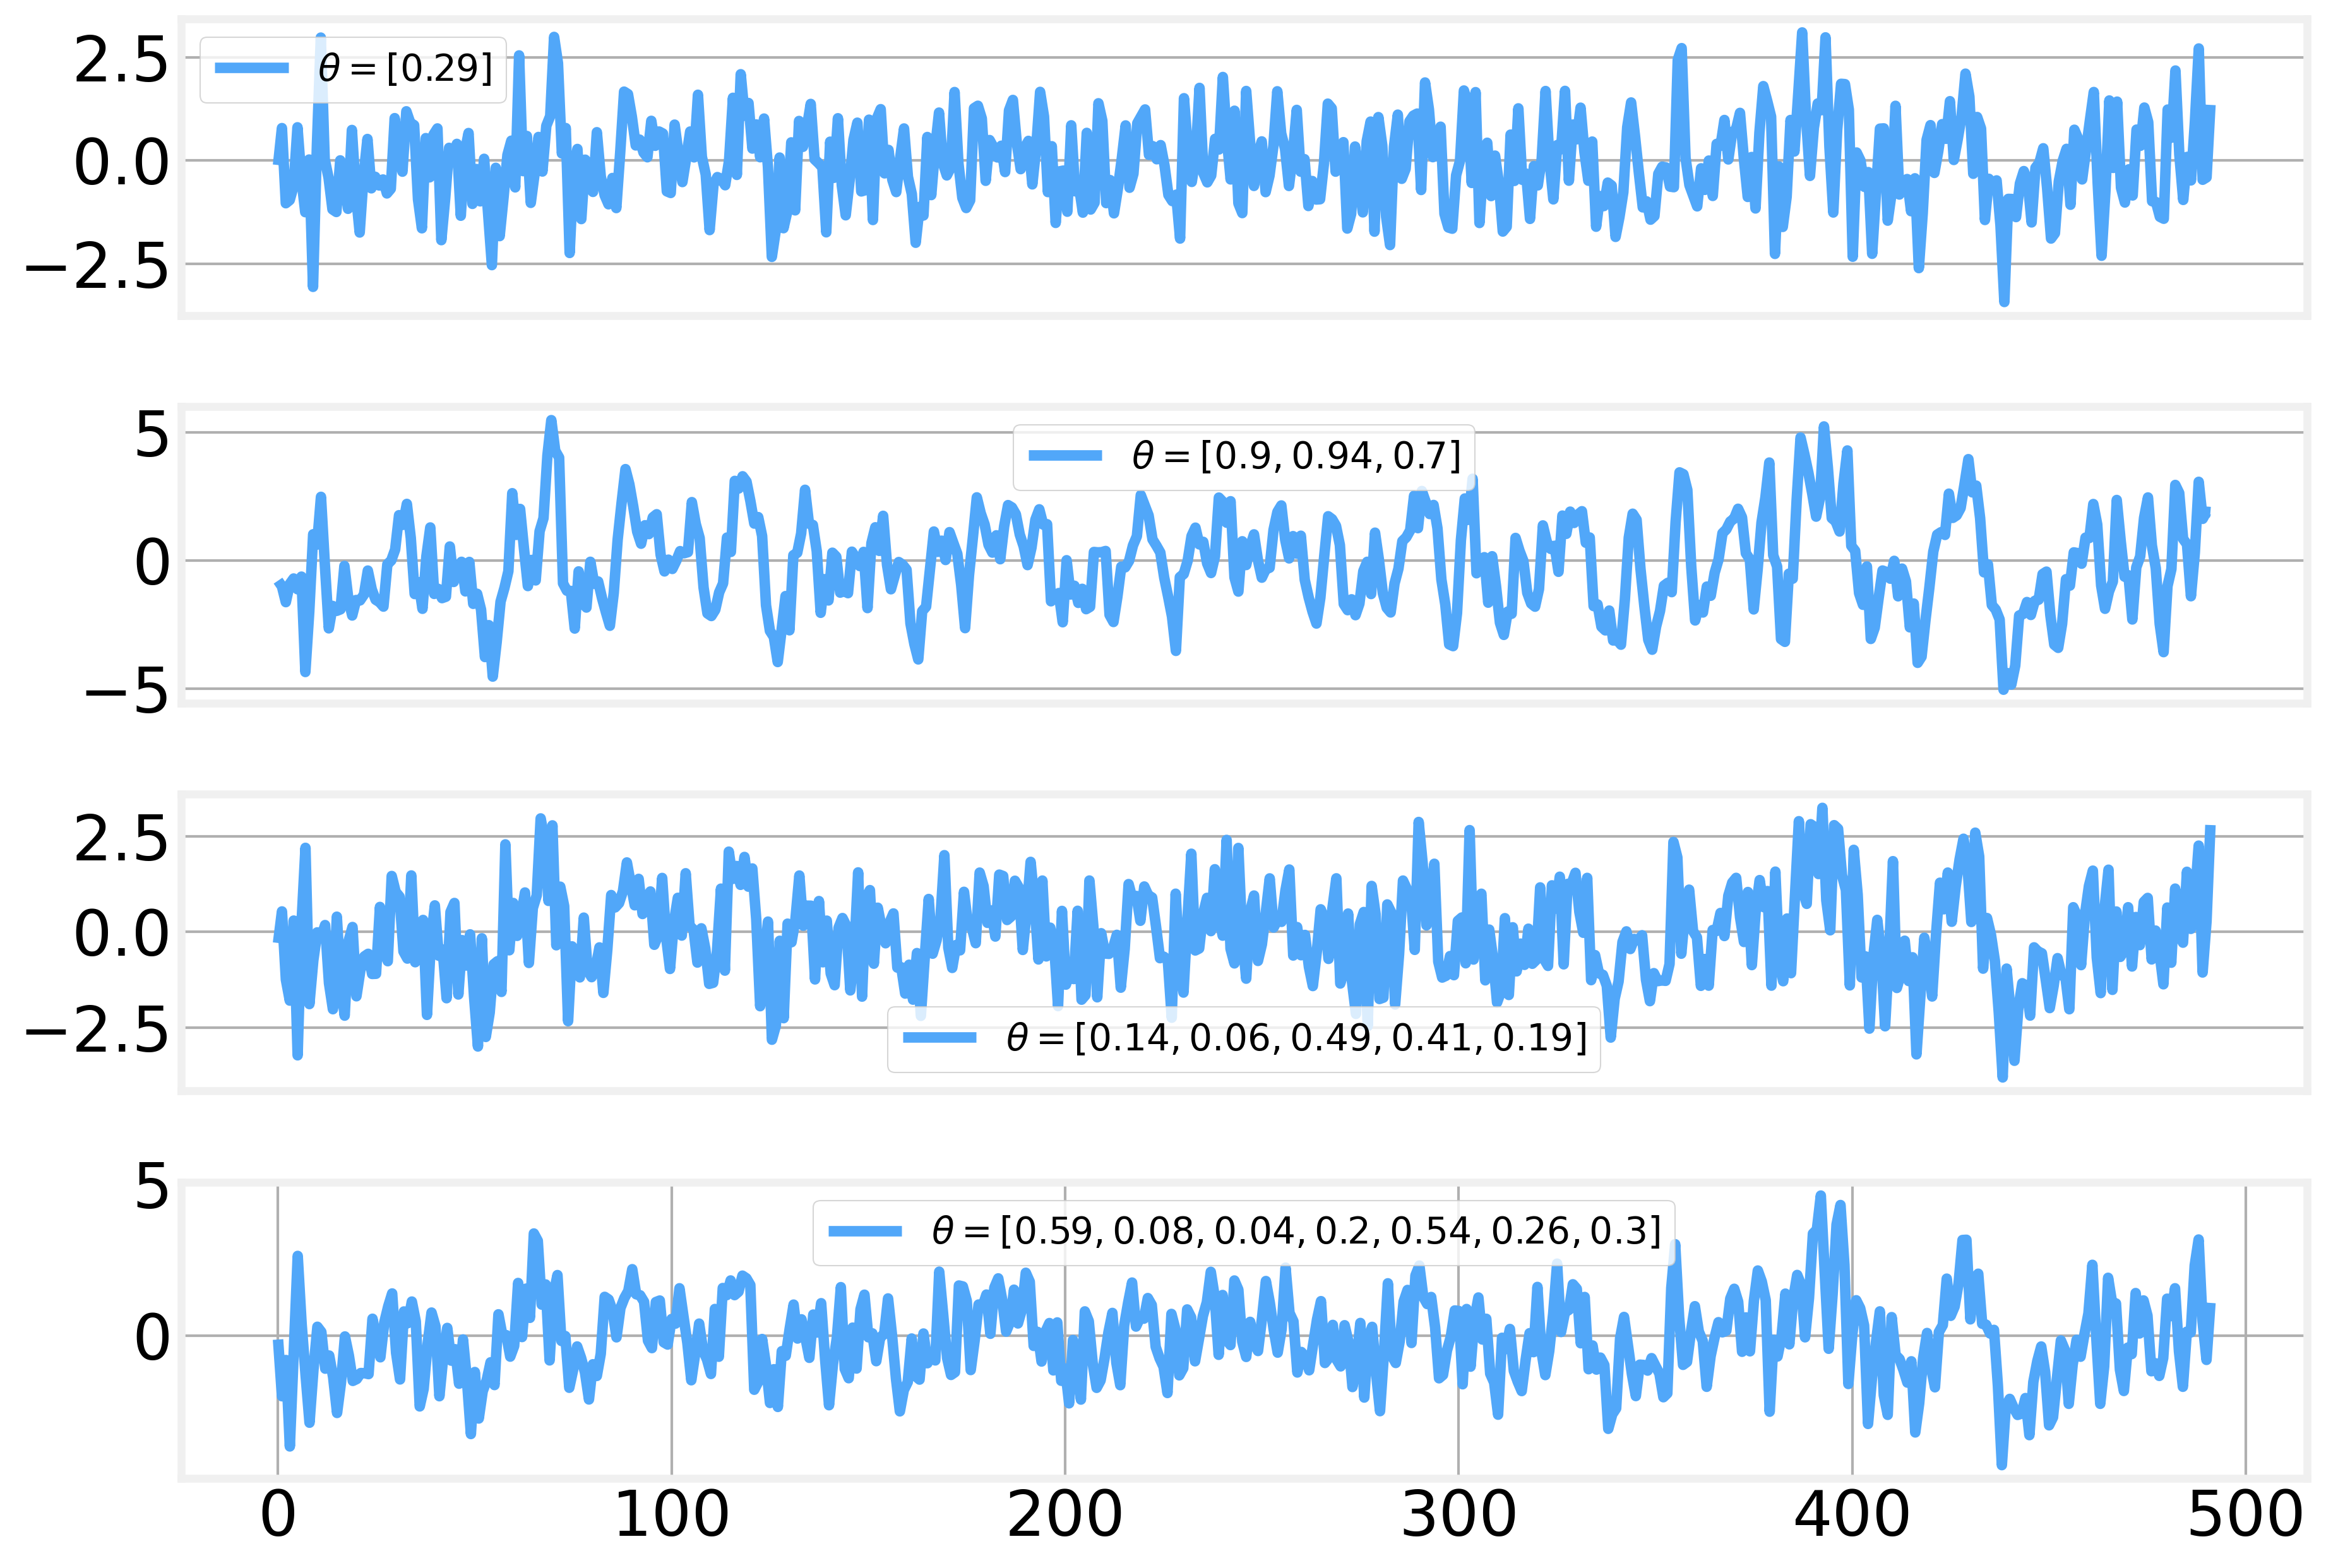

In [6]:
fig, axs = plt.subplots(4, 1)

for i in range(q_max//2):
    axs[i].plot(X_MA[i])
    axs[i].legend([r'$\theta=\left[%s\right]$' % ", ".join(thetas[i].round(2).astype('str'))], prop={'size': 14})
    axs[i].get_xaxis().set_visible(False)
    
axs[-1].get_xaxis().set_visible(True)
fig.tight_layout()

We also wish to plot the Auto-correlation function so we reintroduce the required functions defined before

In [7]:
def pearson(x, y):
    meanx = x.mean()
    meany = y.mean()
    stdx = x.std()
    stdy = y.std()
    return np.mean((x - meanx) * (y - meany)) / (stdx * stdy)

In [8]:
def acf(x, lag=40):
    return np.array([1] + [pearson(x[:-i], x[i:]) for i in range(1, lag)])

In [9]:
def acf_ci(acfv, n, alpha=0.05):
    se = [1 / np.sqrt(n)]
    se.extend(np.sqrt((1+2*np.cumsum(np.power(acfv[1:-1], 2)))/n))
    se = np.array(se)
    
    se *= stats.norm.ppf(1-alpha/2.)
    return se

In [10]:
def plot_acf(x, lag=40, alpha=0.05):
    acf_val = acf(x, lag)
    
    plt.vlines(range(lag), 0, acf_val)
    plt.scatter(np.arange(lag), acf_val, marker='o')
    plt.xlabel('lag')
    plt.ylabel('ACF')
    
    # Determine confidence interval
    ci = acf_ci(acf_val, len(x), alpha)
    plt.fill_between(np.arange(1, ci.shape[0] + 1), -ci, ci, alpha=0.25)

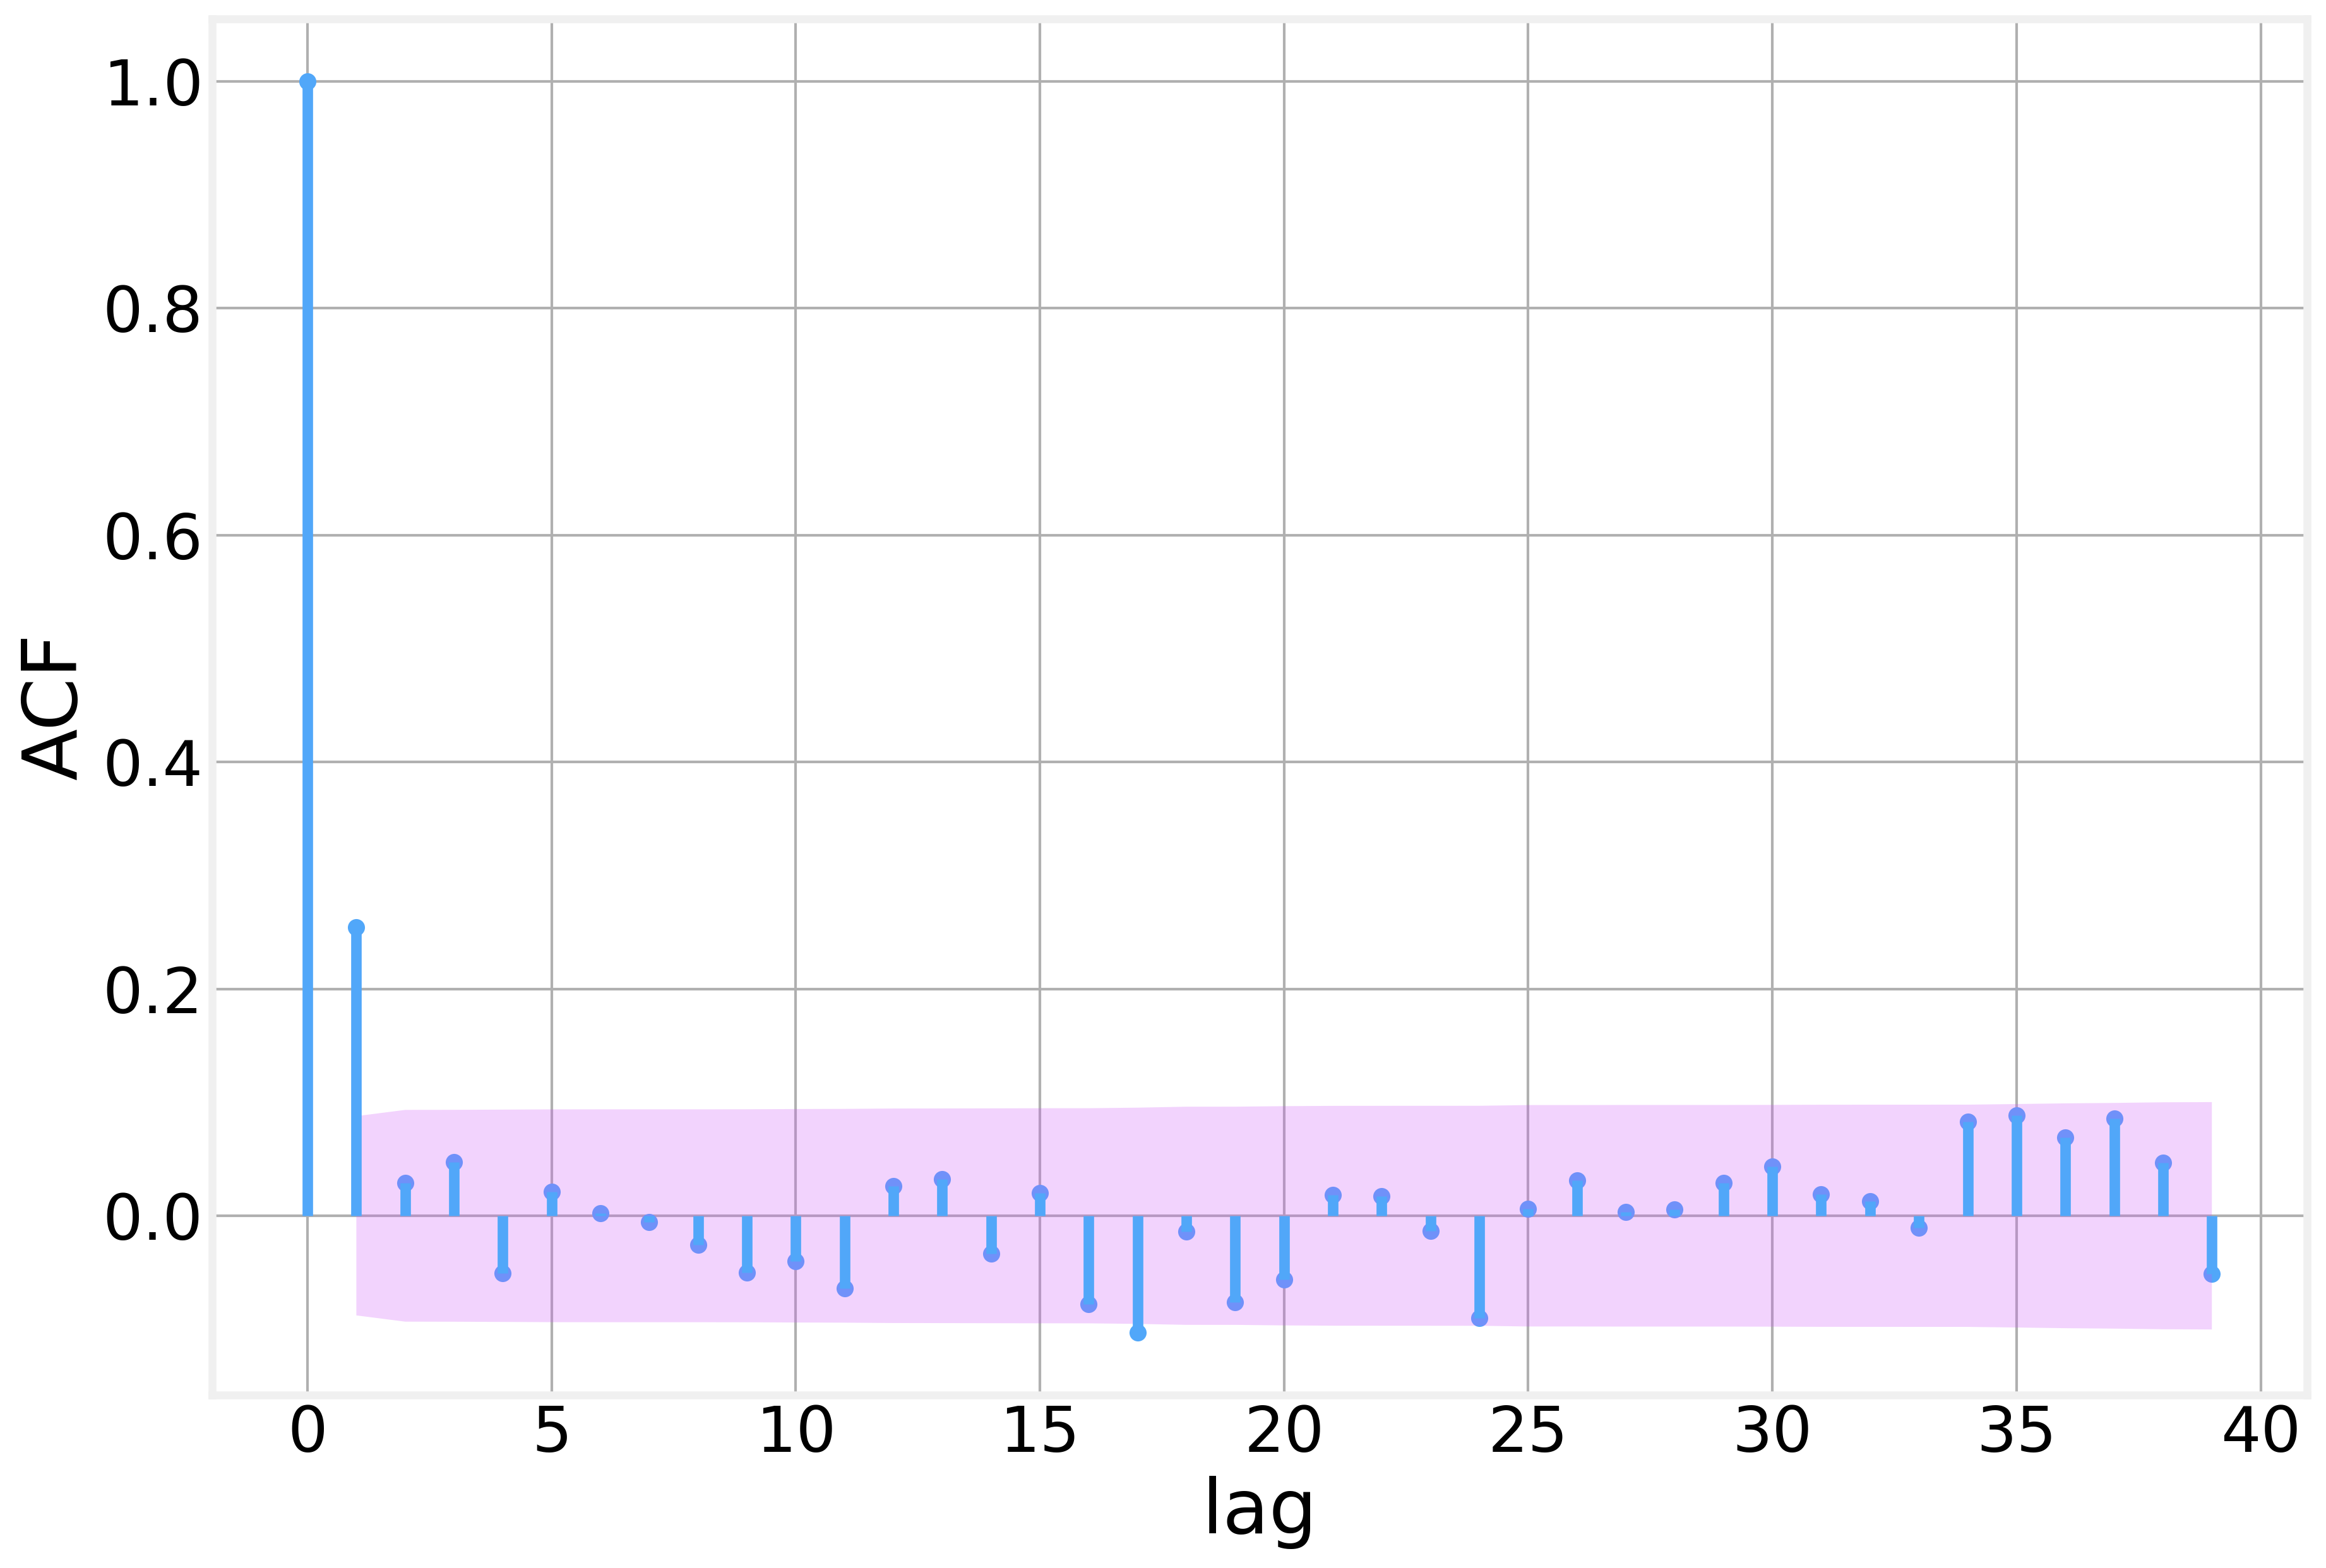

In [11]:
plot_acf(X_MA[0])

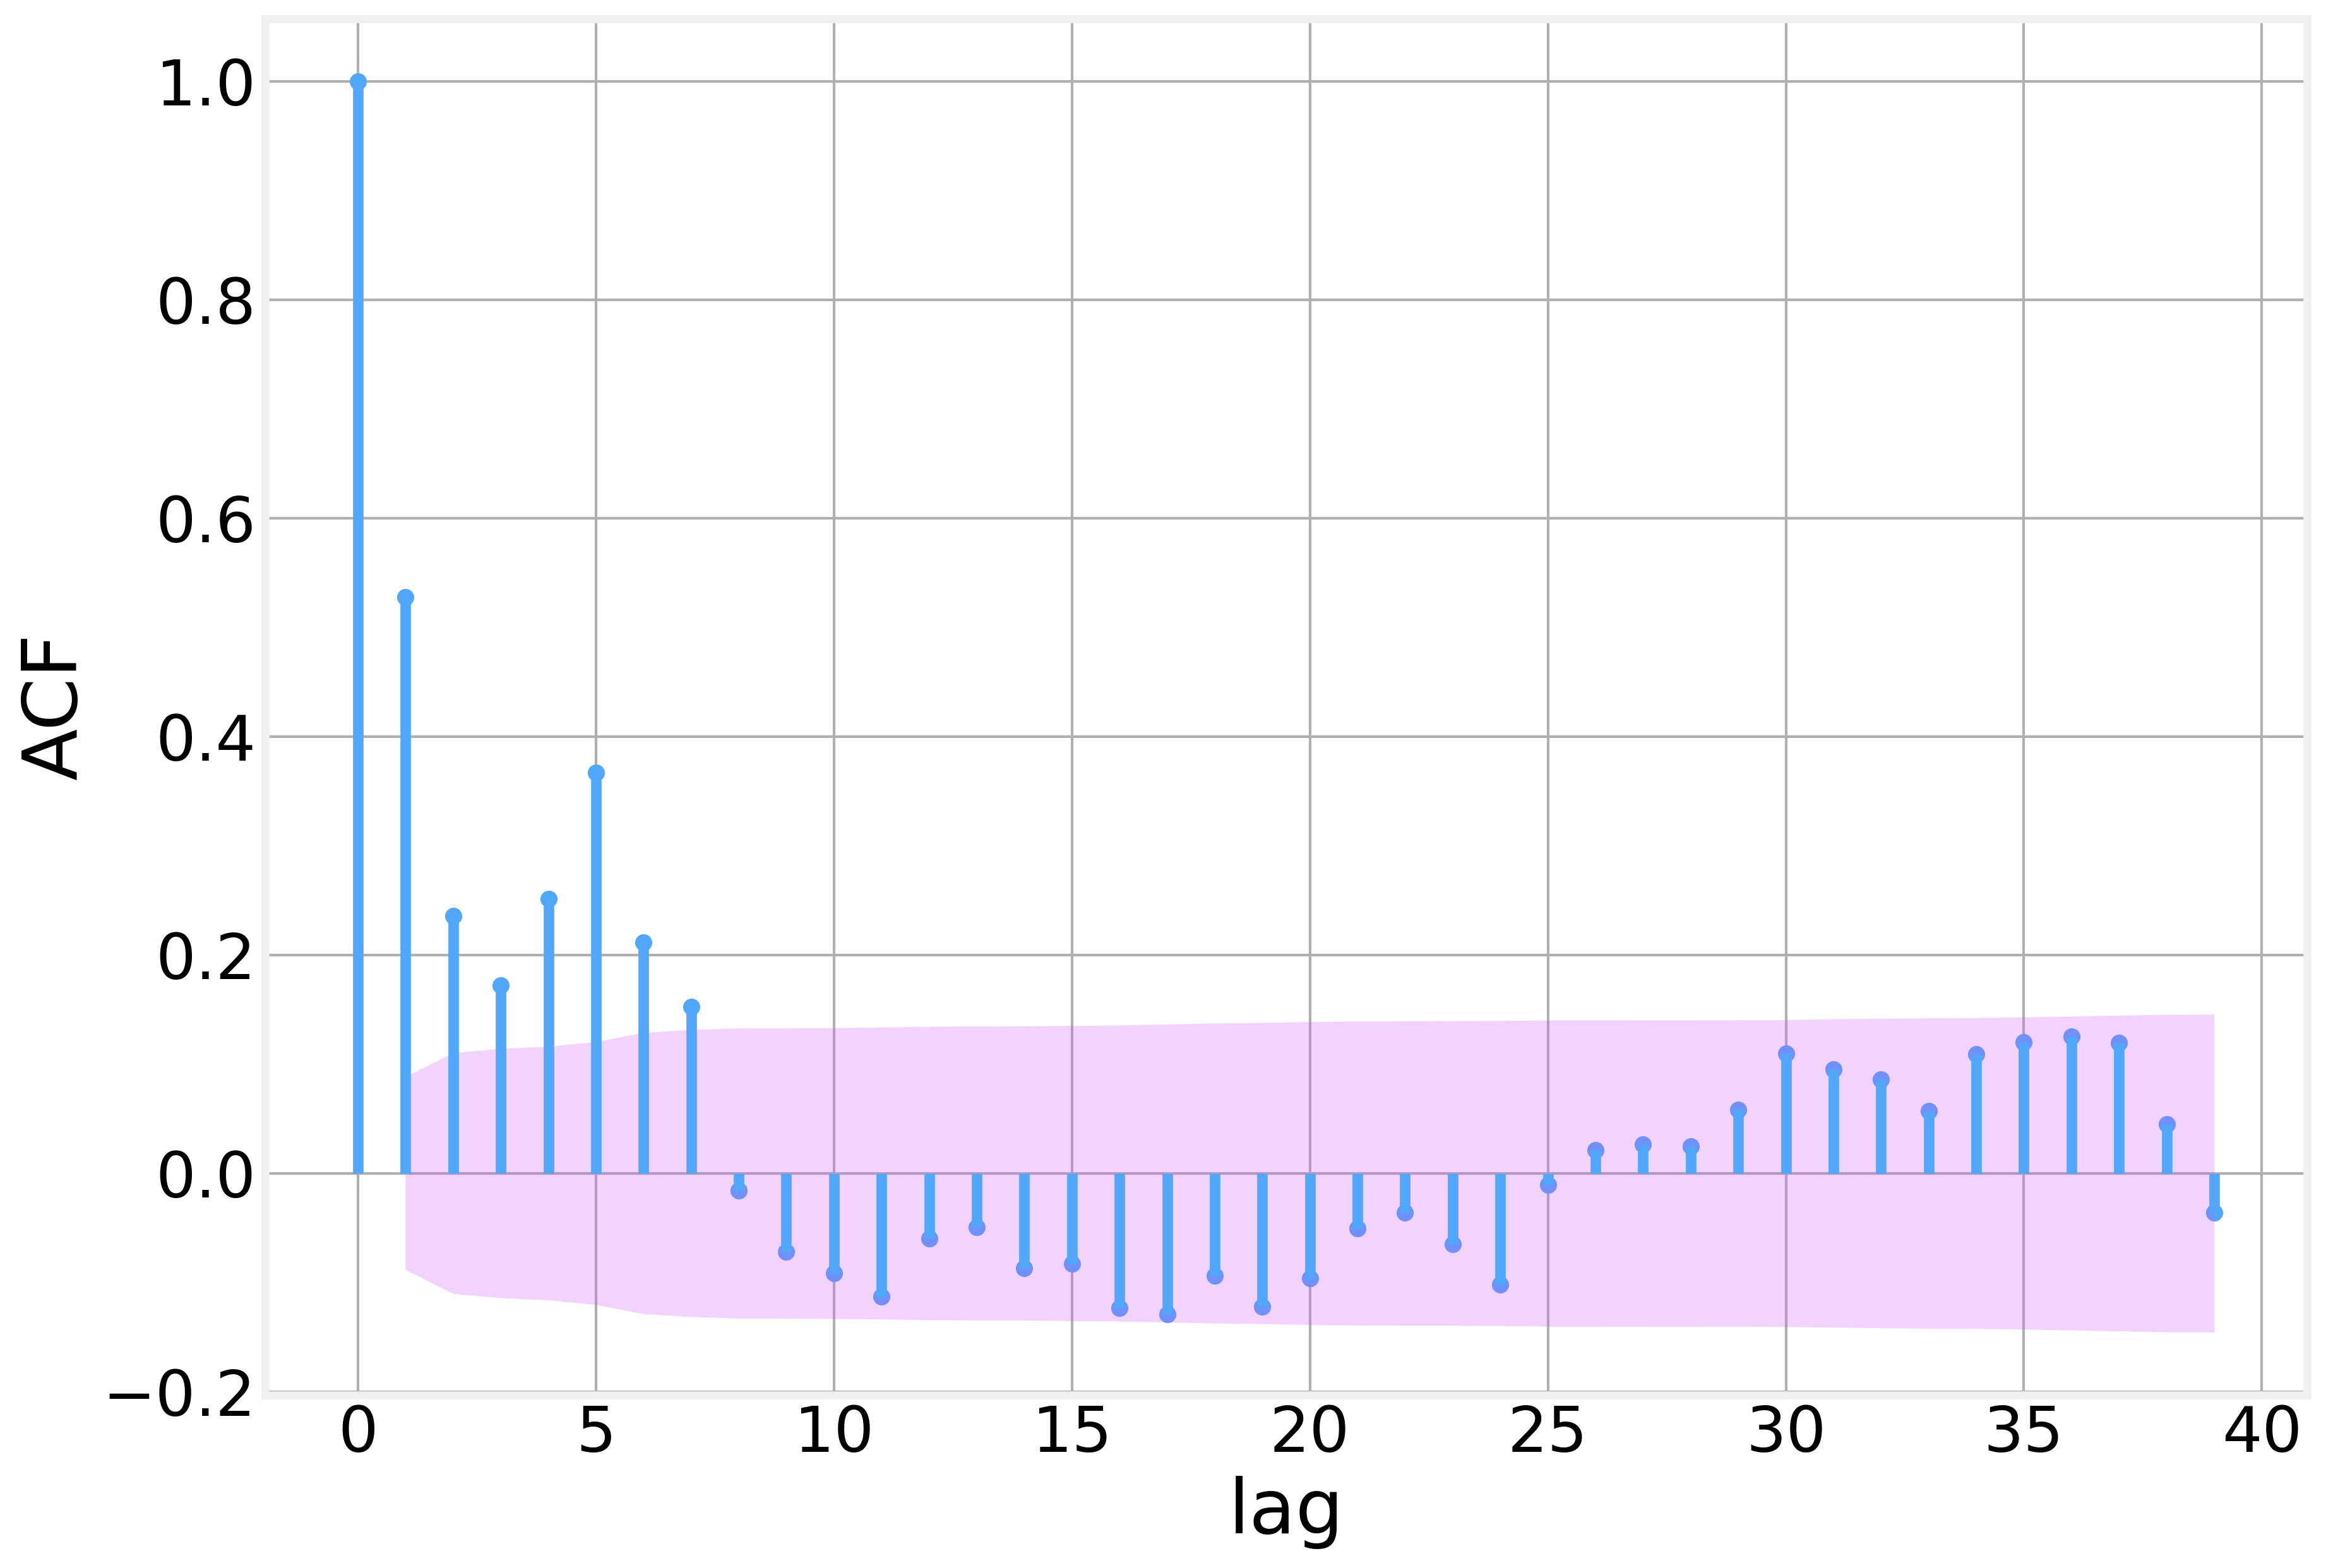

In [12]:
plot_acf(X_MA[-1])

It's easy to see that the number of significant autocorrelation lags is the same as the number of lags in the MA model

## Autoregressive Model (AR)

We now define the Auto-Regressive model. The function is similar to the MA one but using positions instead of the raw stochastic values

In [13]:
def AR(epsilon, phi, drift=0):
    phi = list(phi)
    N = len(epsilon)

    phi0 = np.array([1] + phi)
    phi0 = phi0[::-1] # Invert the order
    p = len(phi0)
    
    X = epsilon.copy()

    for i in range(p, N):
        X[i-1] = np.dot(X[i-p:i], phi0) + drift
        
    return np.array(X)

We also generate some examples

In [14]:
N = 500
phis = []
X_AR = []
p_max = 8

epsilon = np.random.normal(size=N)

for p in range(1, p_max+1, 2):
    phis.append(np.random.normal(0, 0.15, p))
    X_AR.append(AR(epsilon, phis[-1]))

and visualize them

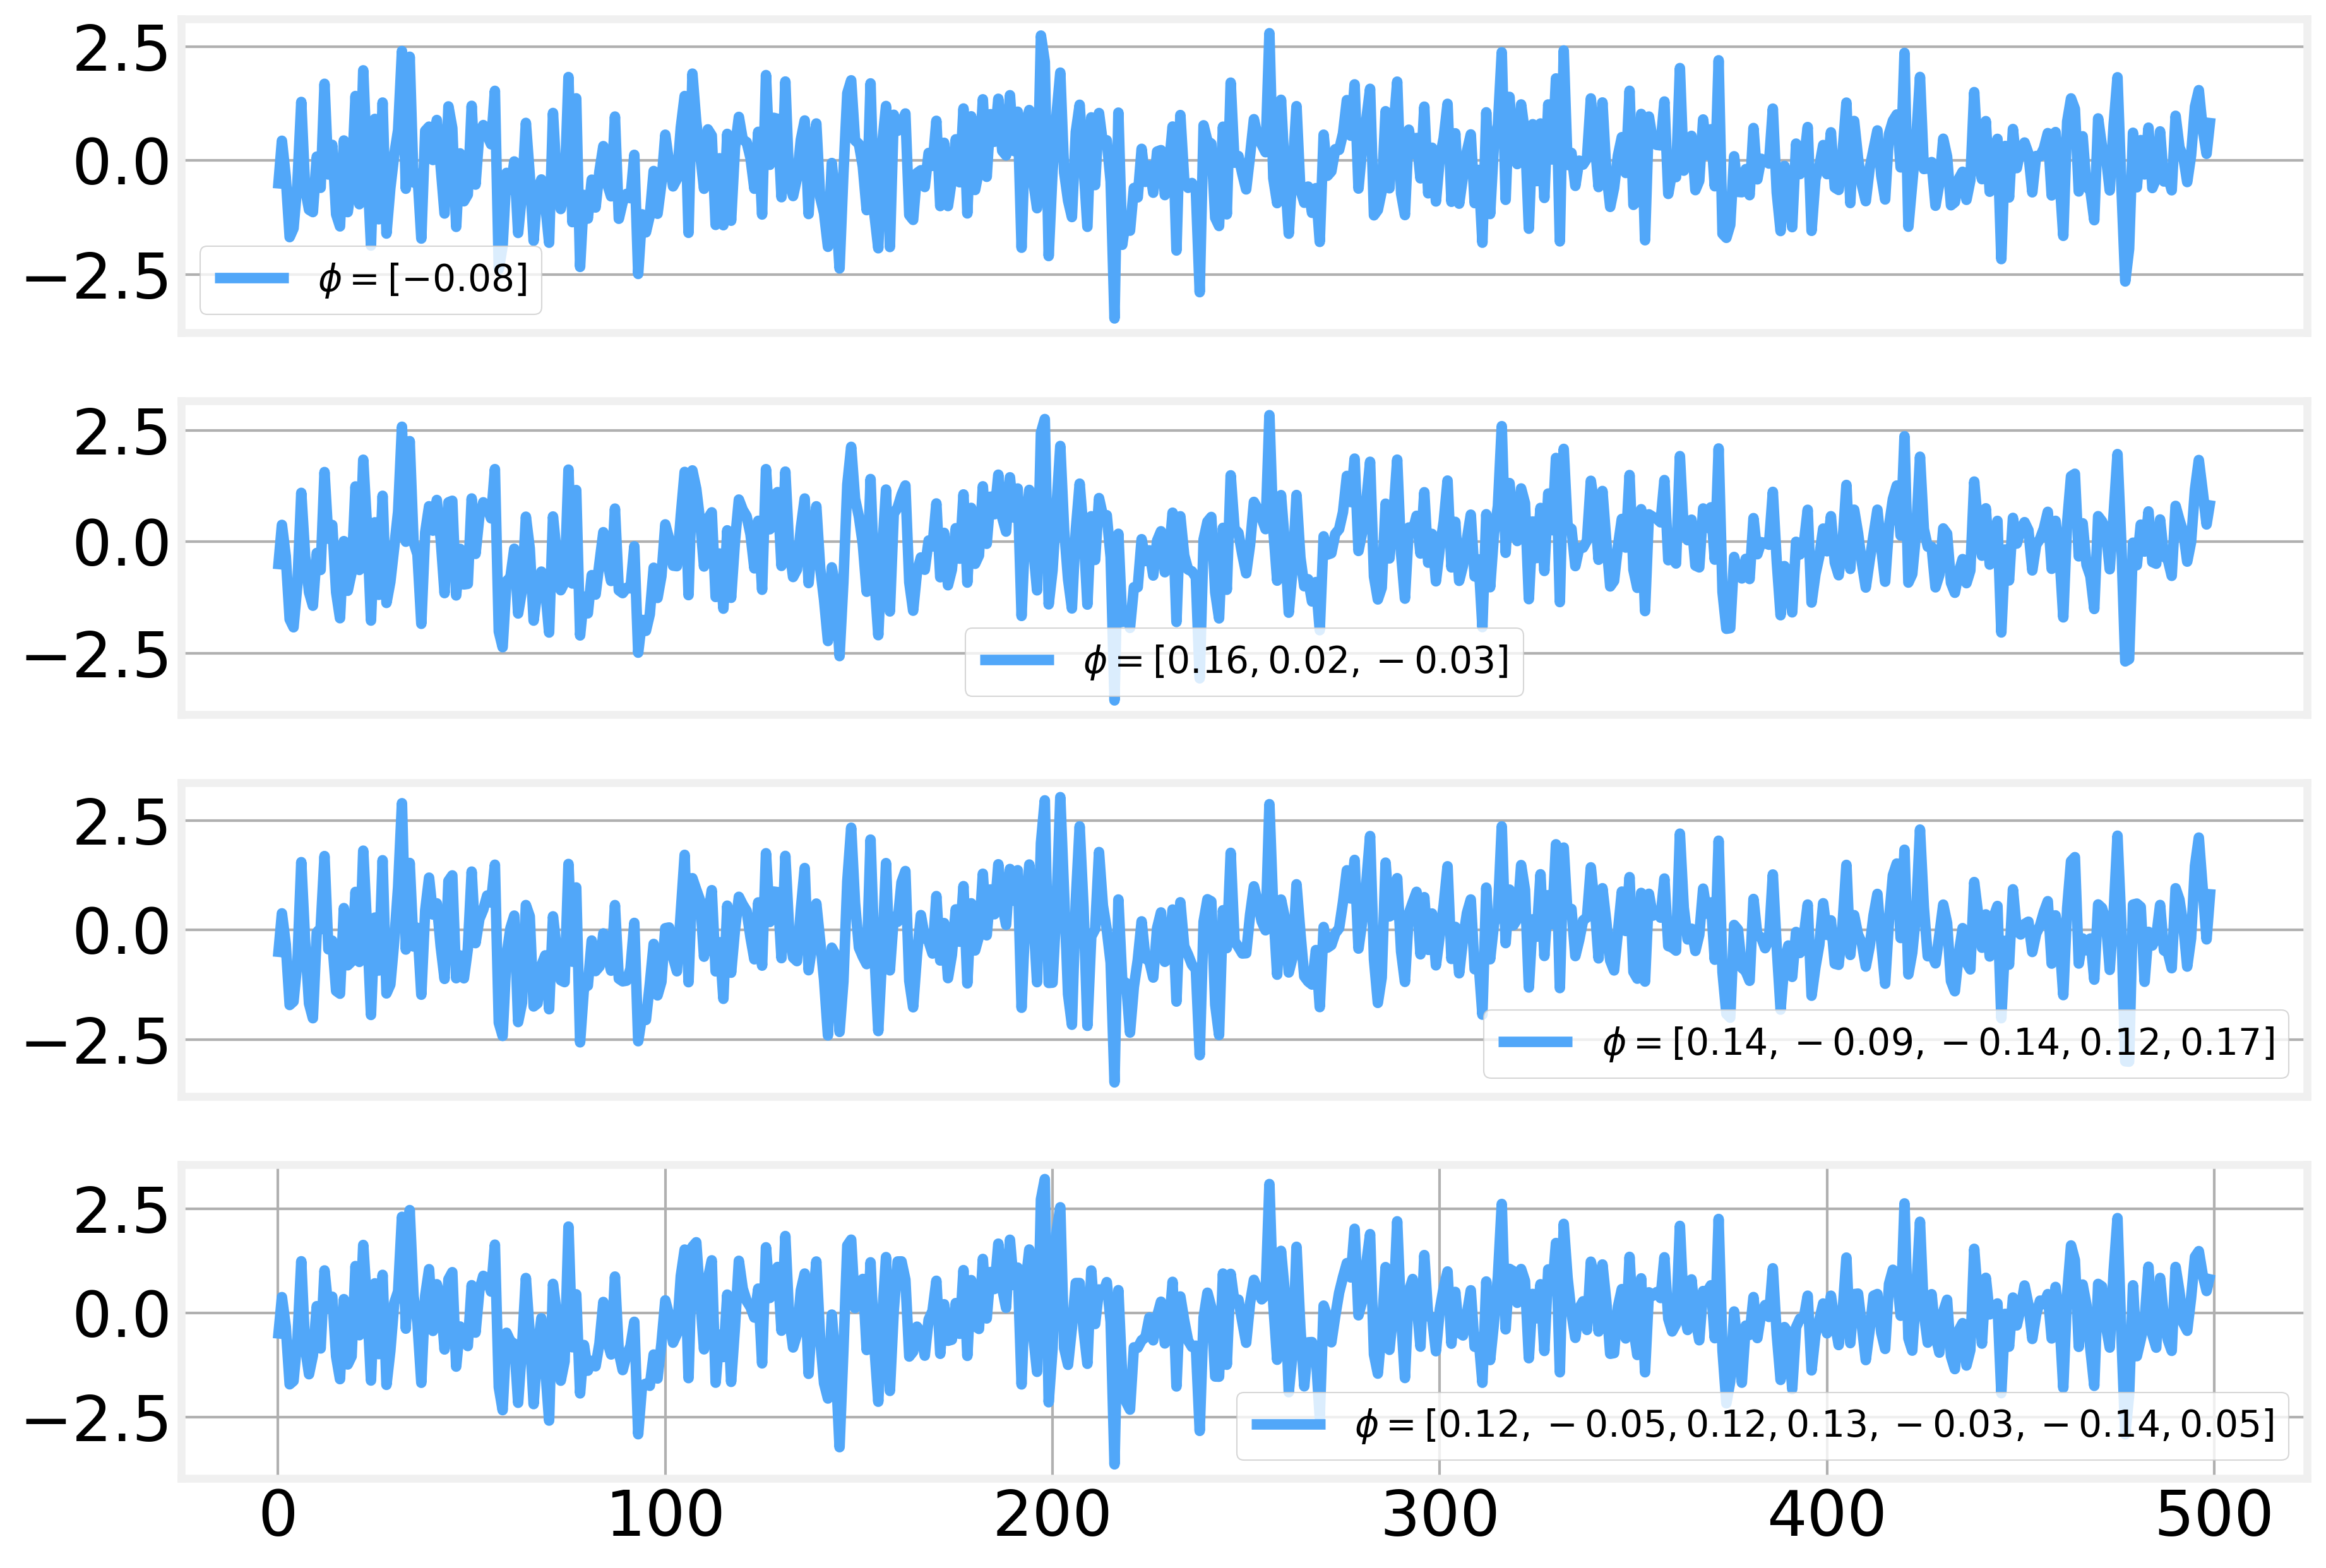

In [15]:
fig, axs = plt.subplots(4, 1)

for i in range(p_max//2):
    axs[i].plot(X_AR[i])
    axs[i].legend([r'$\phi=\left[%s\right]$' % ", ".join(phis[i].round(2).astype('str'))], prop={'size': 14})
    axs[i].get_xaxis().set_visible(False)
    
axs[-1].get_xaxis().set_visible(True)
fig.tight_layout()

And introduce the required functions for the Partial Auto-correlation function

In [16]:
def rolling(x, order):
    npoints = x.shape[0]
    running = []
    
    for i in range(npoints-order):
        running.append(x[i:i+order])
        
    return np.array(running)

In [17]:
def pacf(x, lag=40):
    y = []
    
    for i in range(3, lag + 2):
        windows = rolling(x.flatten(), i)

        xt = windows[:, -1] # Current values are at the end
        xt_l = windows[:, 0] # Lagged values are at 0
        inter = windows[:, 1:-1] # Intermediate values are in between 1 and -1

        lm = LinearRegression(fit_intercept=False).fit(inter, xt)
        xt_fit = lm.predict(inter)

        lm = LinearRegression(fit_intercept=False).fit(inter, xt_l)
        xt_l_fit = lm.predict(inter)

        y.append(pearson(xt - xt_fit, xt_l - xt_l_fit))
    
    # Pad the array with the two missing values
    pacf_1 = acf(x, 2)[1]
    return np.array([1, pacf_1] +  y)

In [18]:
def plot_pacf(x, alpha=0.05, lag=40):
    pacf_val = pacf(x, lag)
    plt.vlines(np.arange(lag + 1), 0, pacf_val)
    plt.scatter(np.arange(lag + 1), pacf_val, marker='o')
    plt.xlabel('lag')
    plt.ylabel('PACF')
    
    # Determine confidence interval
    ci = acf_ci(pacf_val, len(x))
    plt.fill_between(np.arange(1, ci.shape[0] + 1), -ci, ci, alpha=0.25)

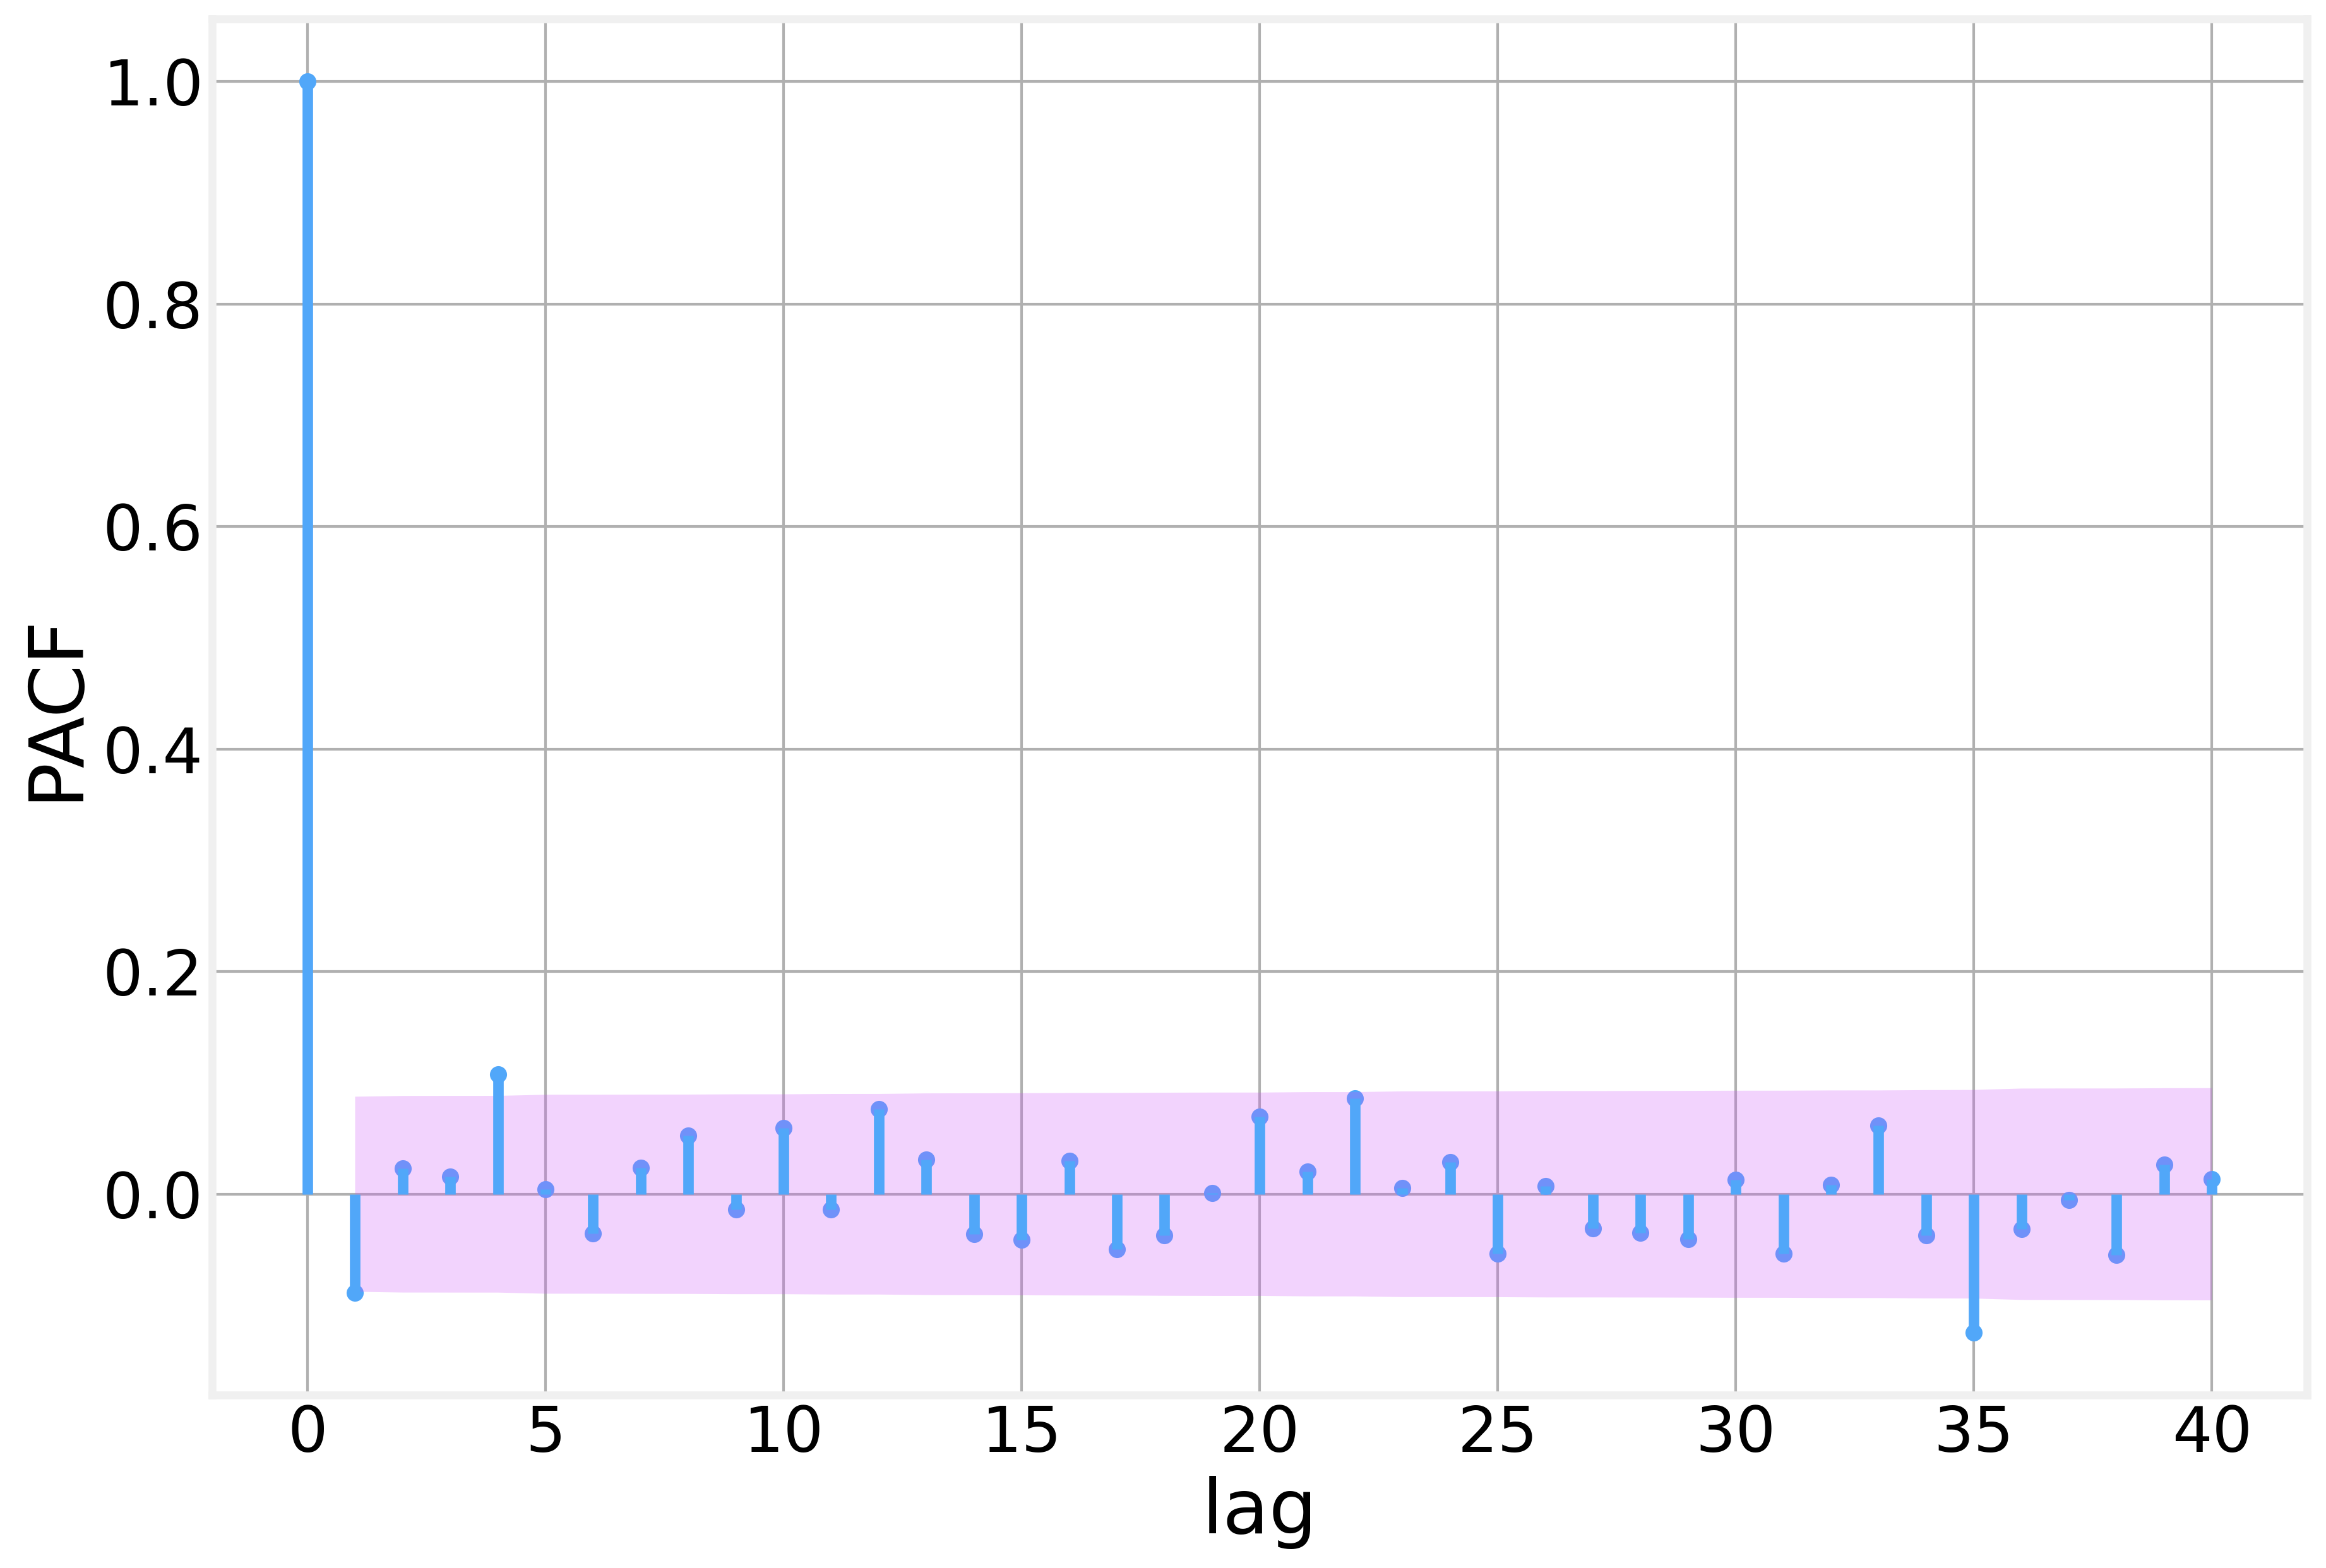

In [21]:
plot_pacf(X_AR[0])

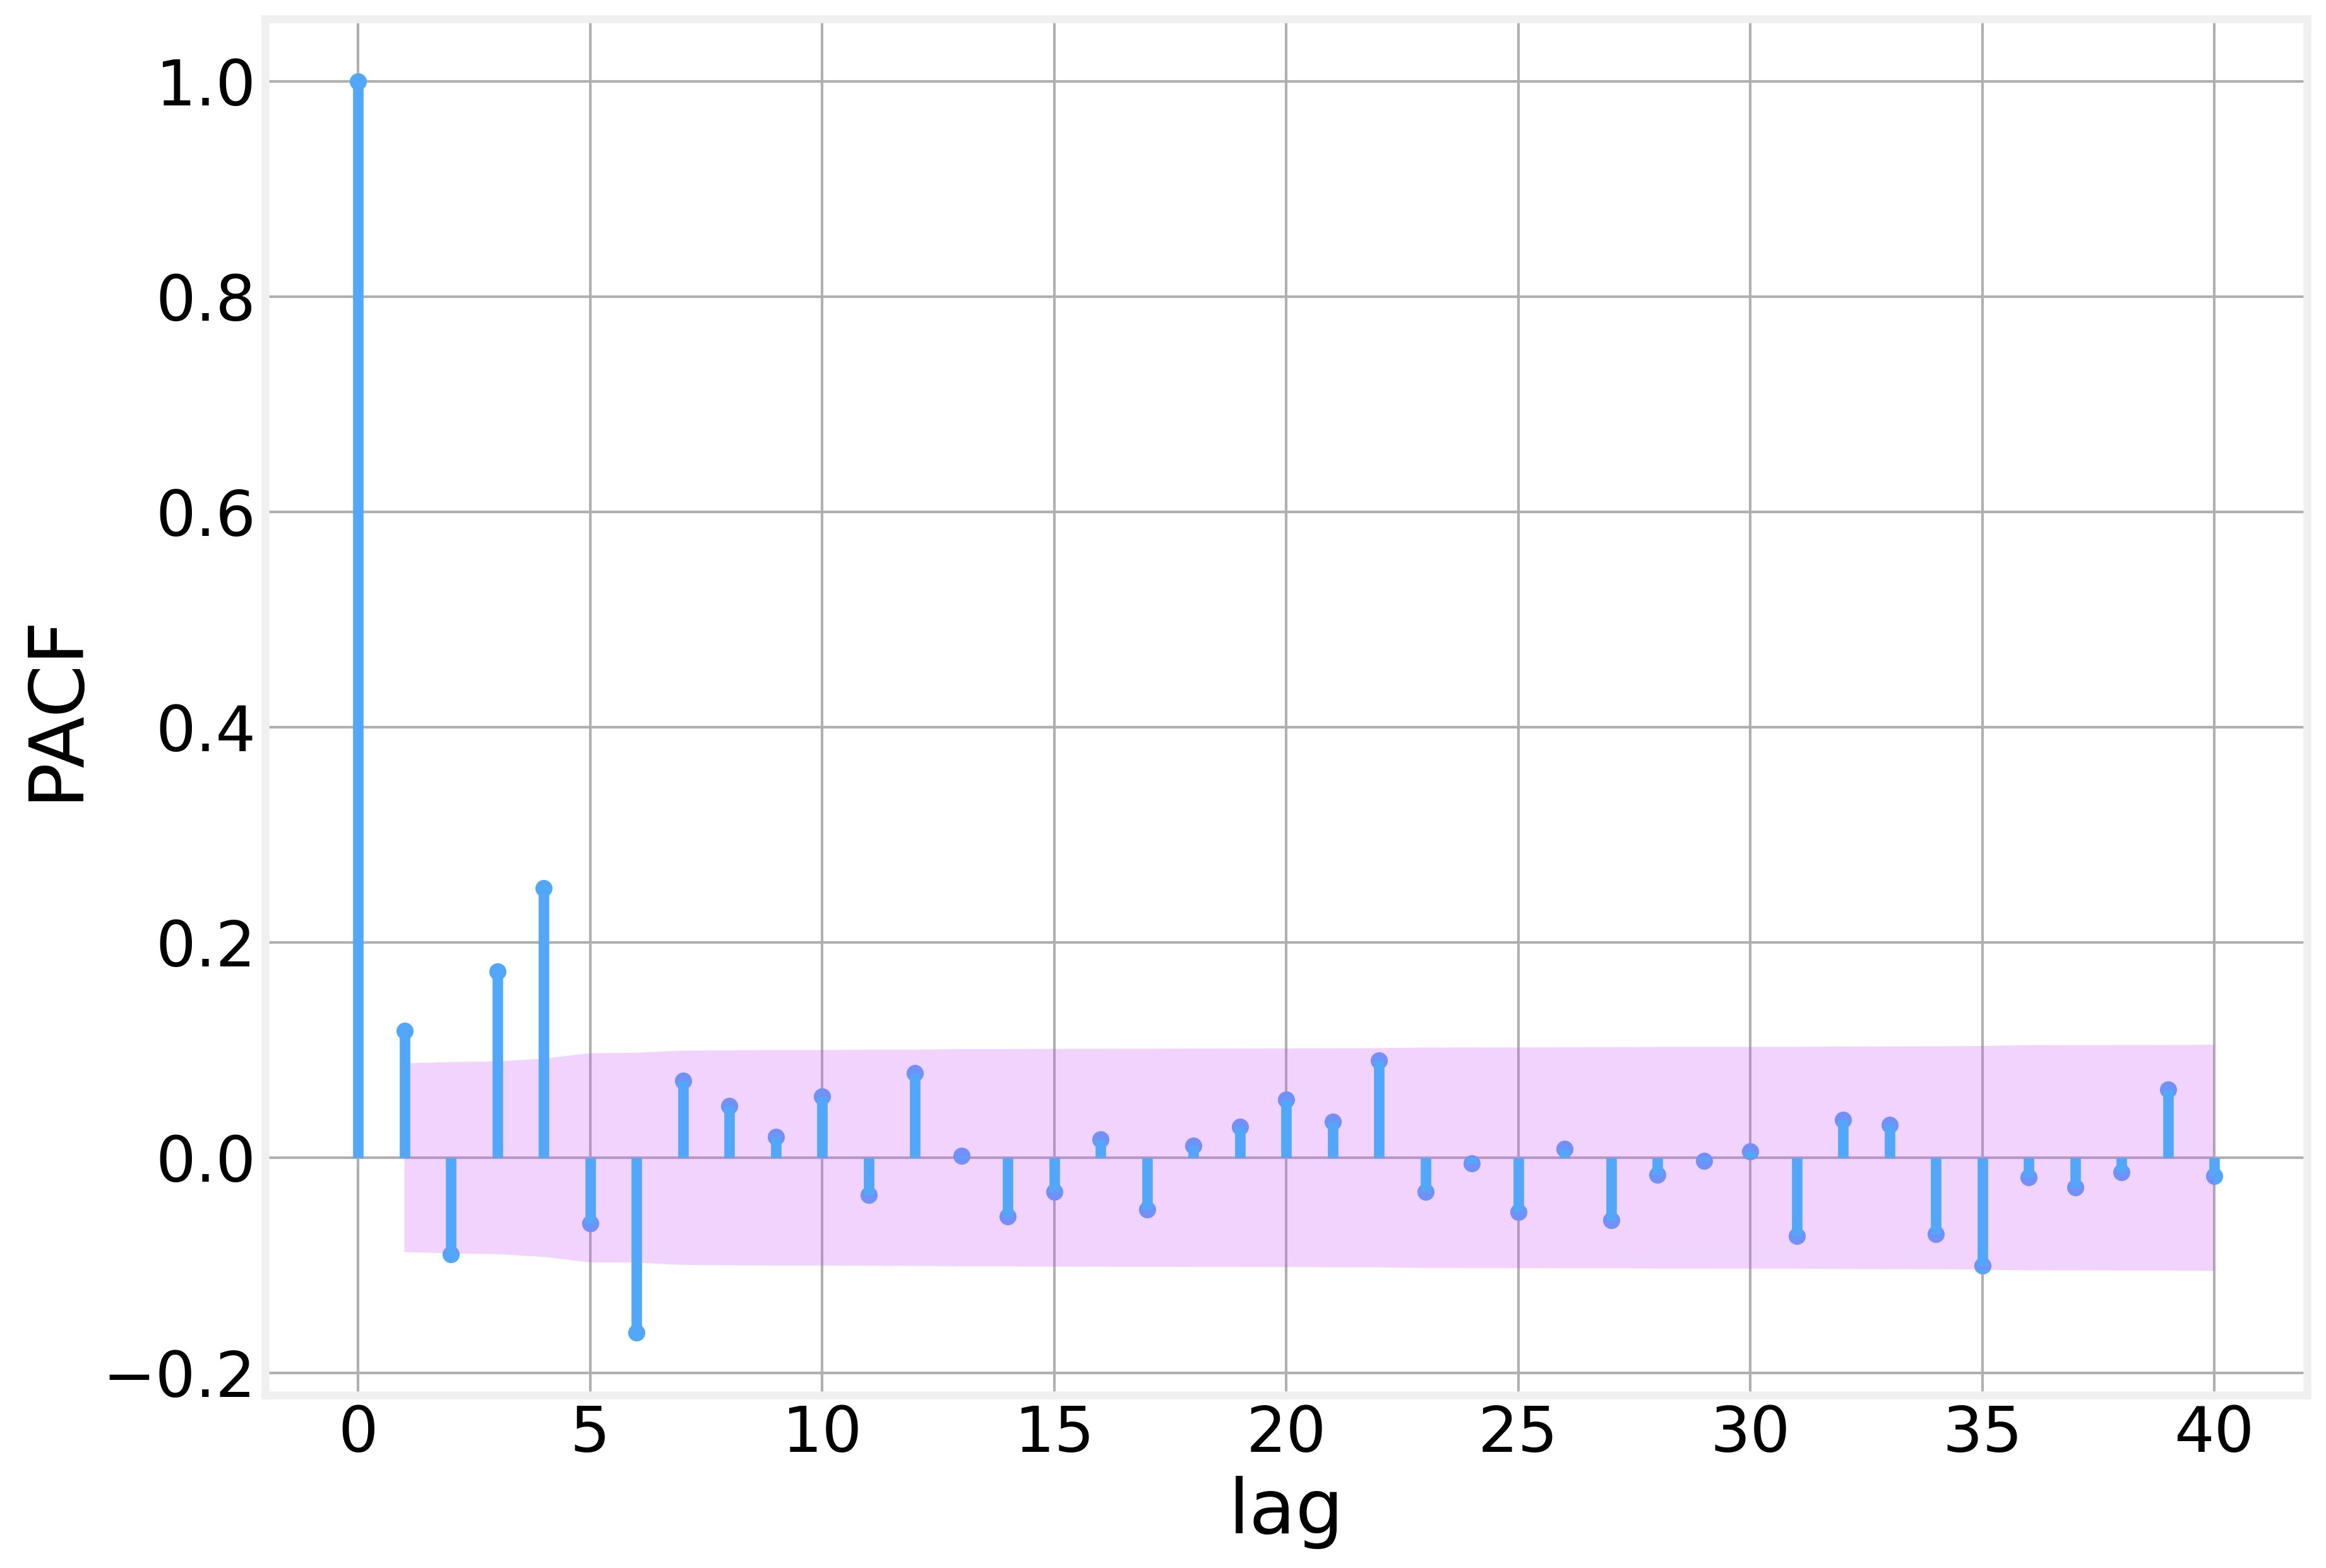

In [22]:
plot_pacf(X_AR[-1])

As with the case of ACF and the MA model the number of significant values corresponds to the lags of the AR model

# Statsmodels

Now that we have a firm understanding of all the details of the AR and MA components, we are almost ready to move on to the full fledged ARIMA model. For simplicity, we'll use the statsmodels package for the remainder of the notebook.

To get familiar with its functionality, we start with a simple linear regression

In [23]:
anscomb = pd.read_csv('data/Anscombe1.dat', sep=' ', header=None, names=['x1', 'y'])

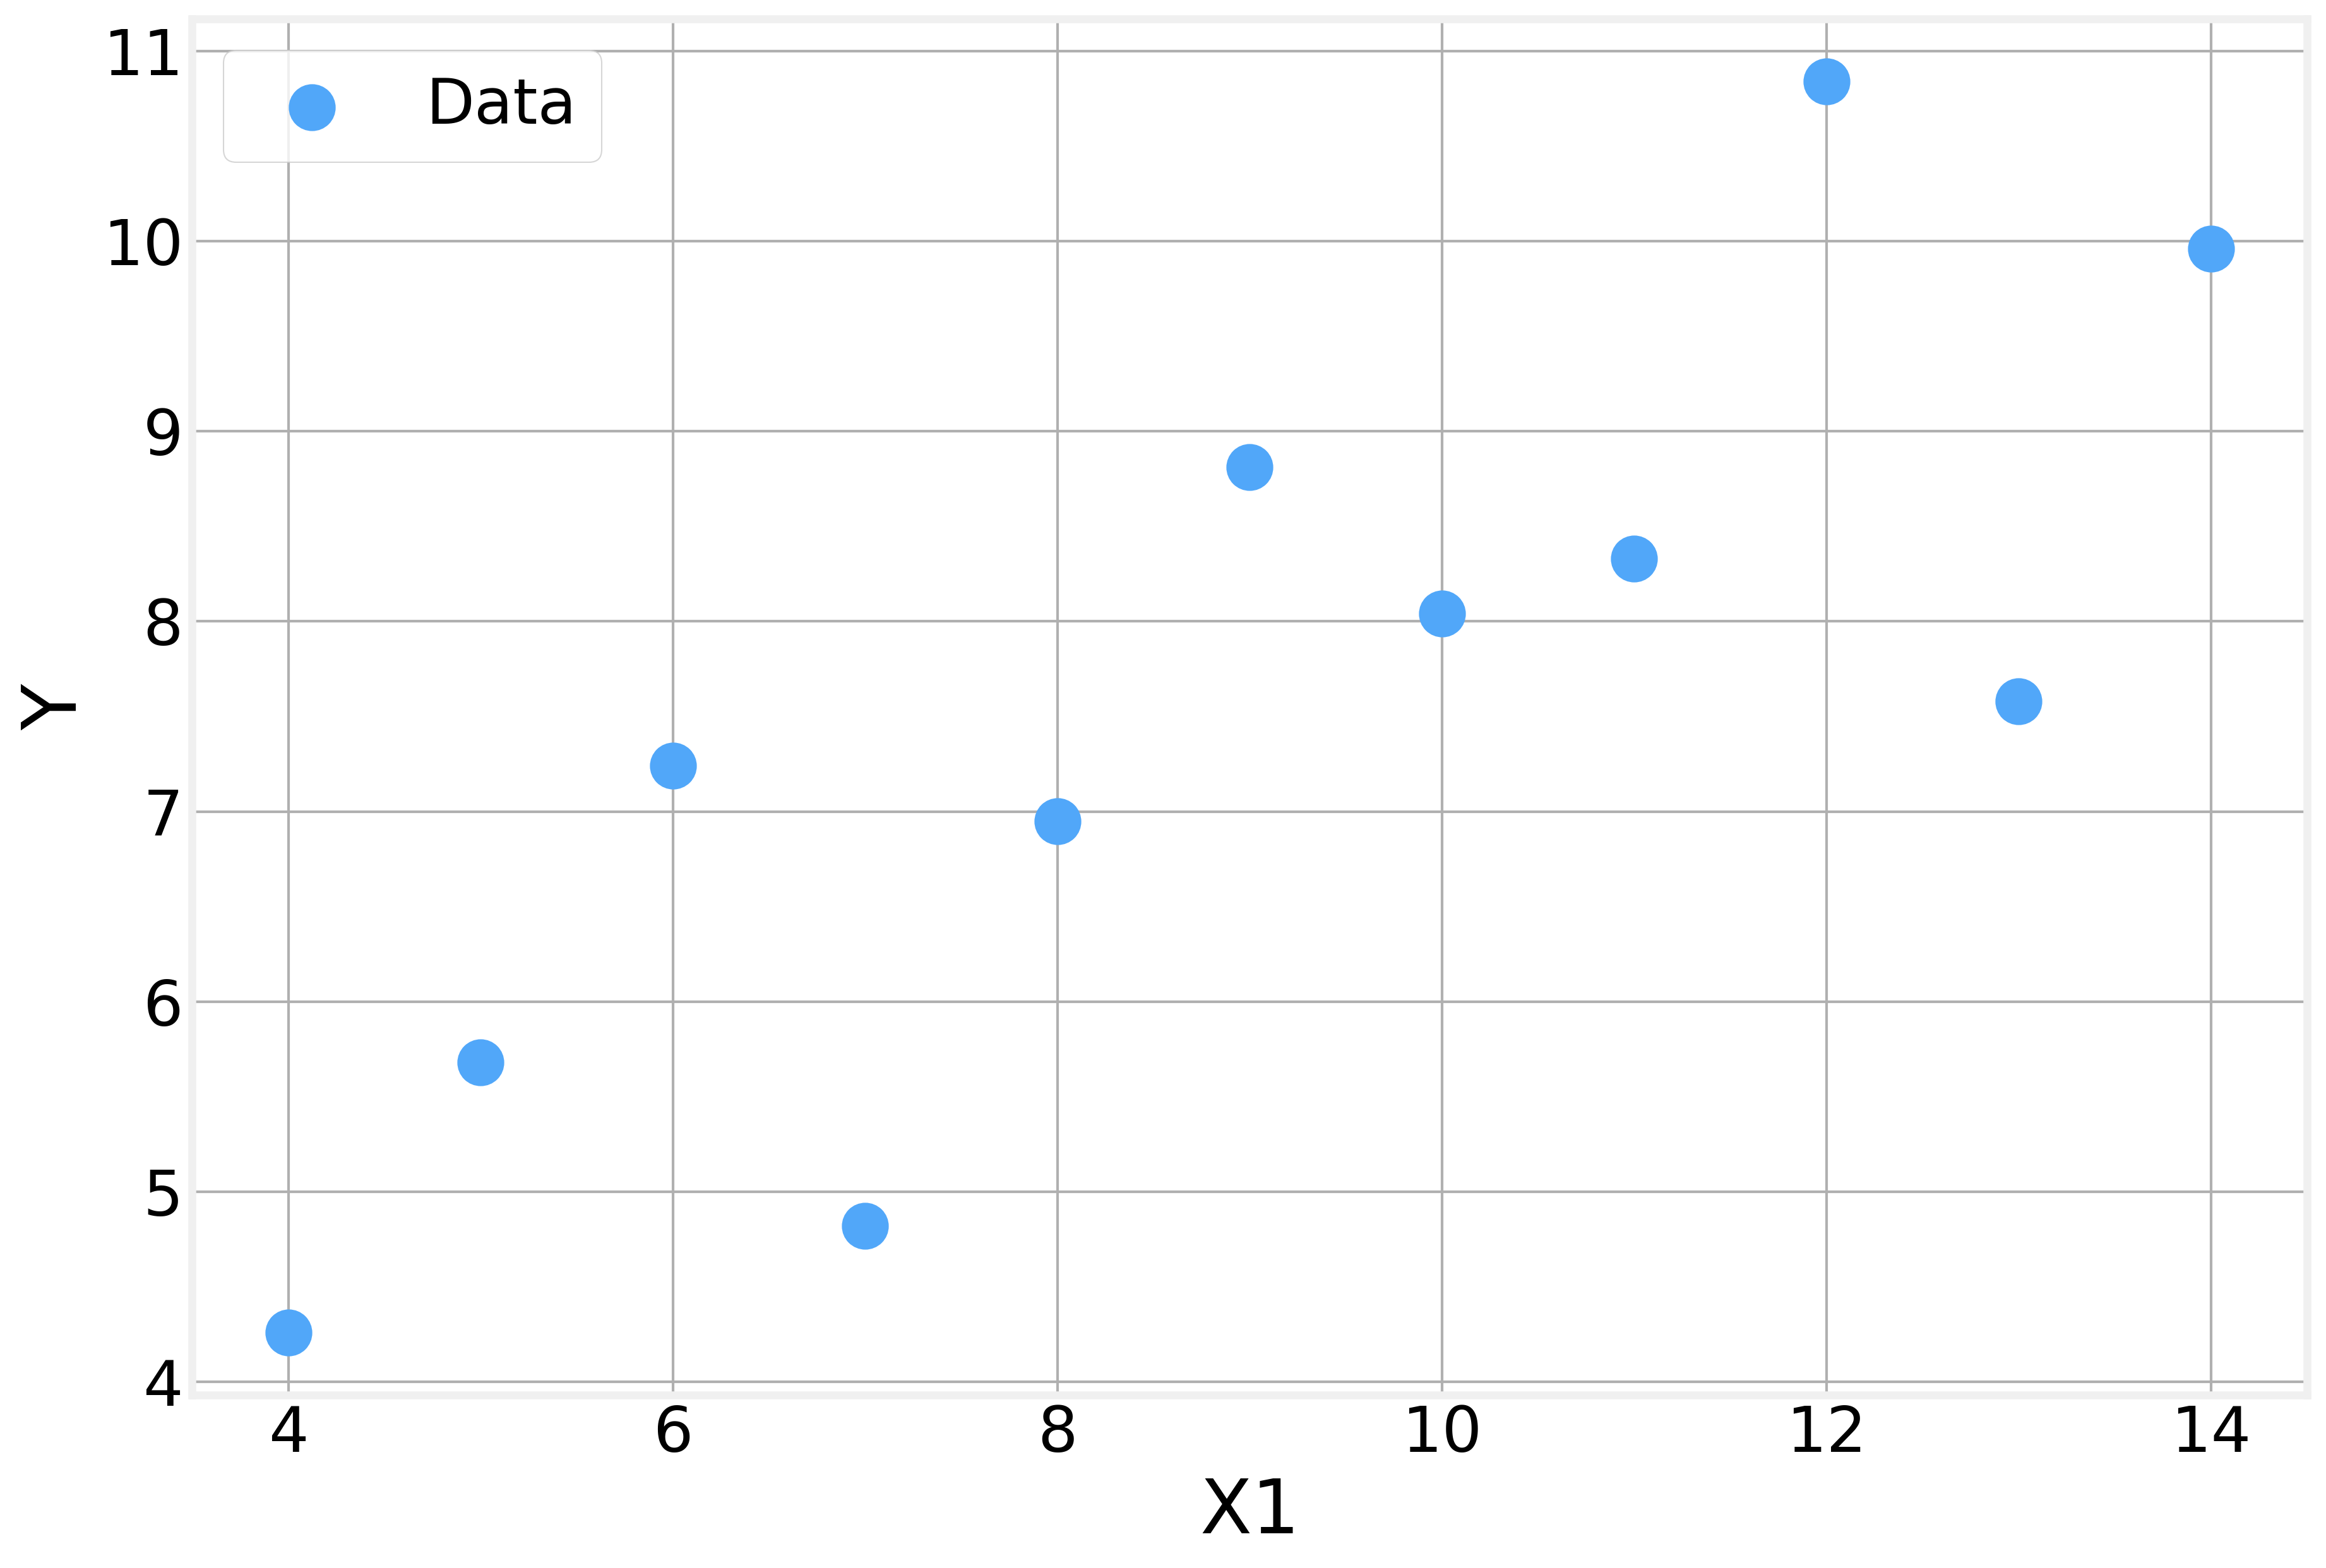

In [24]:
ax = anscomb.plot.scatter(x='x1', y='y', s=300)
ax.set_xlabel('X1')
ax.set_ylabel('Y')
ax.legend(['Data'], loc='upper left')

We explicitly add an intercept

In [25]:
anscomb['const'] = 1

And perform the fit

In [26]:
model = sm.OLS(anscomb.y, anscomb[['const', 'x1']]).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.667
Model:                            OLS   Adj. R-squared:                  0.629
Method:                 Least Squares   F-statistic:                     17.99
Date:                Mon, 16 Aug 2021   Prob (F-statistic):            0.00217
Time:                        15:23:01   Log-Likelihood:                -16.841
No. Observations:                  11   AIC:                             37.68
Df Residuals:                       9   BIC:                             38.48
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.0001      1.125      2.667      0.026       0.456       5.544
x1             0.5001      0.118      4.241      0.002       0.233       0.767
==============================================================================
Omnibus:                        0.082   Durbin-Watson:                   3.212
Prob(Omnibus):                  0.960   Jarque-Bera (JB):                0.289
Skew:                          -0.122   Prob(JB):                        0.865
Kurtosis:                       2.244   Cond. No.                         29.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

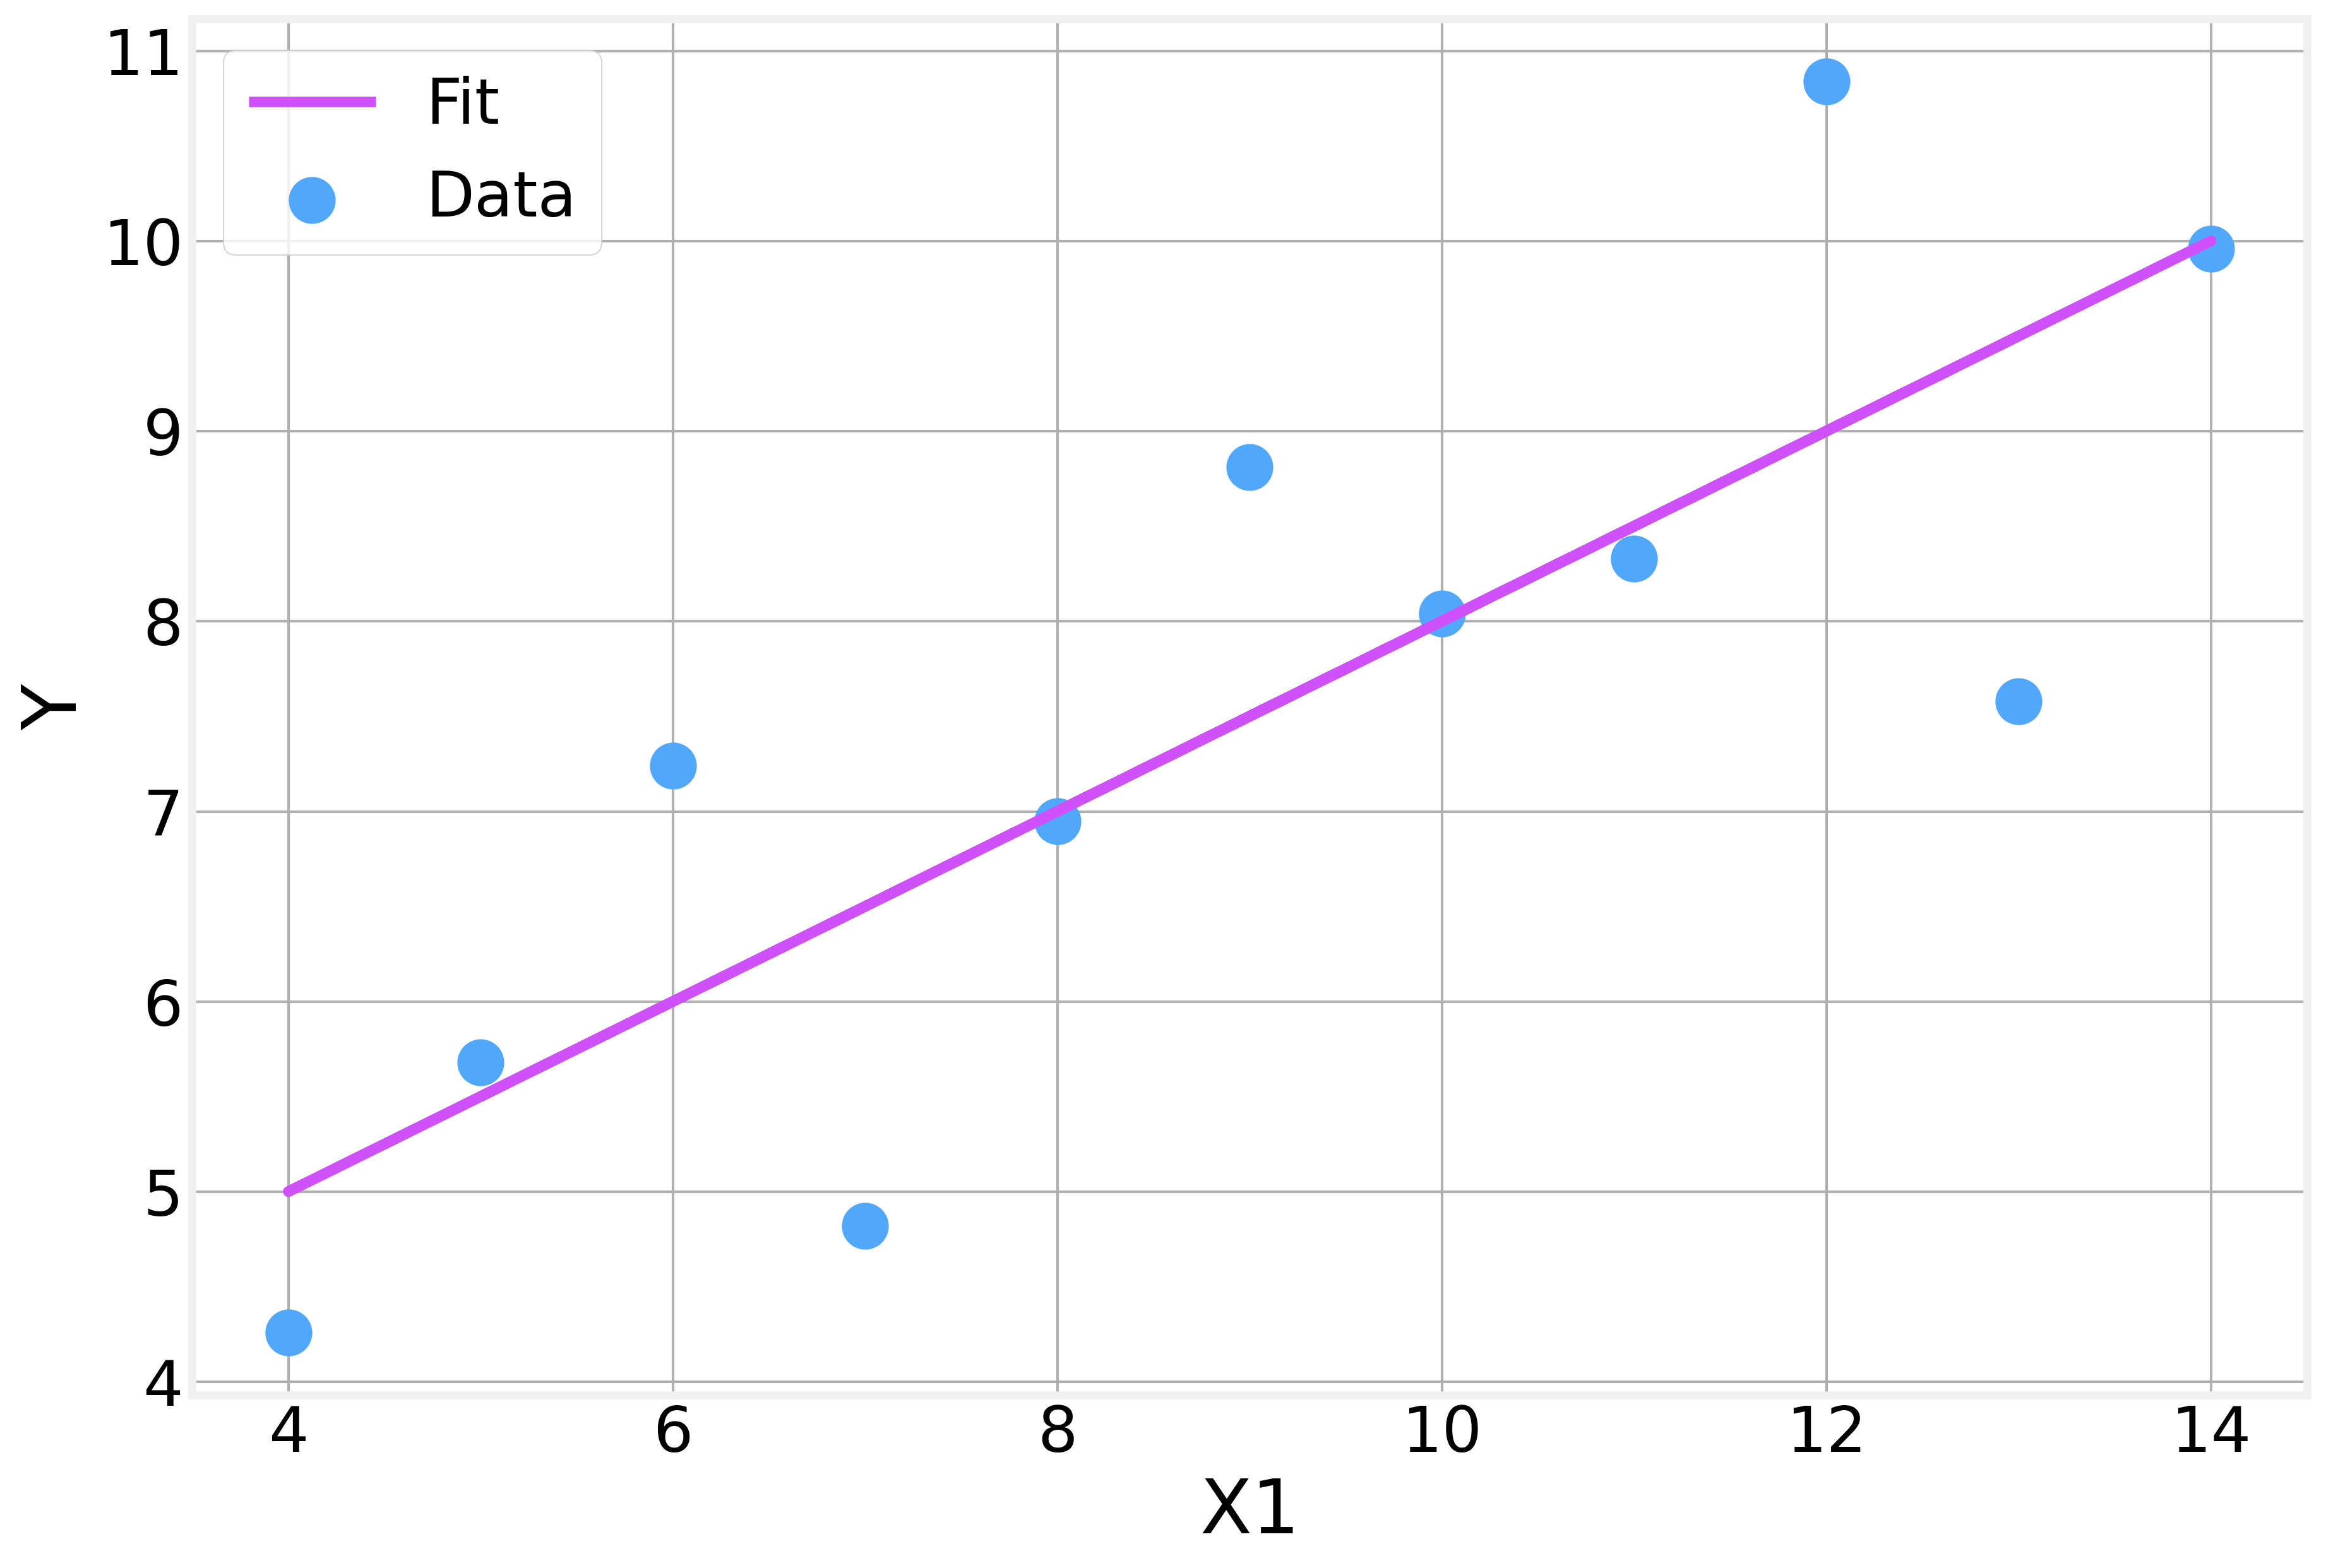

In [27]:
ax = anscomb.plot.scatter(x='x1', y='y', s=300)
ax.plot(anscomb.x1, model.predict(anscomb[['const', 'x1']]), color=colors[1])
ax.set_xlabel('X1')
ax.set_ylabel('Y')
ax.legend(['Fit', 'Data'], loc='upper left')

# ARIMA Model

In [28]:
ILI = pd.read_csv('data/CDC.csv')

In [29]:
ILI

Year  Week  Percent of Deaths Due to Pneumonia and Influenza  Expected  \
0    2012     1                                          8.479120   8.15718   
1    2012     2                                          8.343472   8.22181   
2    2012     3                                          8.370908   8.27534   
3    2012     4                                          8.448458   8.31696   
4    2012     5                                          8.140332   8.34602   
..    ...   ...                                               ...       ...   
398  2019    34                                          5.085333   5.24916   
399  2019    35                                          5.031743   5.26200   
400  2019    36                                          4.951483   5.28715   
401  2019    37                                          4.781635   5.32427   
402  2019    38                                          4.985358   5.37284   

     Threshold  All Deaths  Pneumonia Deaths  Influenza Deaths  
0      8.49104       51102              4323                10  
1      8.55556       50962              4245                 7  
2      8.60898       51010              4261                 9  
3      8.65049       50163              4227                11  
4      8.67945       49568              4026                 9  
..         ...         ...               ...               ...  
398    5.58794       46172              2343                 5  
399    5.60078       44577              2231                12  
400    5.62593       43078              2122                11  
401    5.66305       38857              1845                13  
402    5.71162       28684              1421                 9  

[403 rows x 8 columns]

We convert the year and week number to an actual date. For convenience, we use the Monday (day 1) when computing the date.

In [30]:
ILI['Date'] = ILI[['Year', 'Week']].apply(lambda x: "%s-%02u-1" % (x.Year, x.Week), axis=1)
ILI['Date'] = pd.to_datetime(ILI['Date'], format='%Y-%U-%w')
ILI.head()

Year  Week  Percent of Deaths Due to Pneumonia and Influenza  Expected  \
0  2012     1                                          8.479120   8.15718   
1  2012     2                                          8.343472   8.22181   
2  2012     3                                          8.370908   8.27534   
3  2012     4                                          8.448458   8.31696   
4  2012     5                                          8.140332   8.34602   

   Threshold  All Deaths  Pneumonia Deaths  Influenza Deaths       Date  
0    8.49104       51102              4323                10 2012-01-02  
1    8.55556       50962              4245                 7 2012-01-09  
2    8.60898       51010              4261                 9 2012-01-16  
3    8.65049       50163              4227                11 2012-01-23  
4    8.67945       49568              4026                 9 2012-01-30

And extract only the information we're going to use

In [31]:
ILI = ILI[['Date', 'Percent of Deaths Due to Pneumonia and Influenza']].set_index('Date')

Our timeseries is then:

Text(0, 0.5, 'Pneumonia and Influenza Deaths (%)')

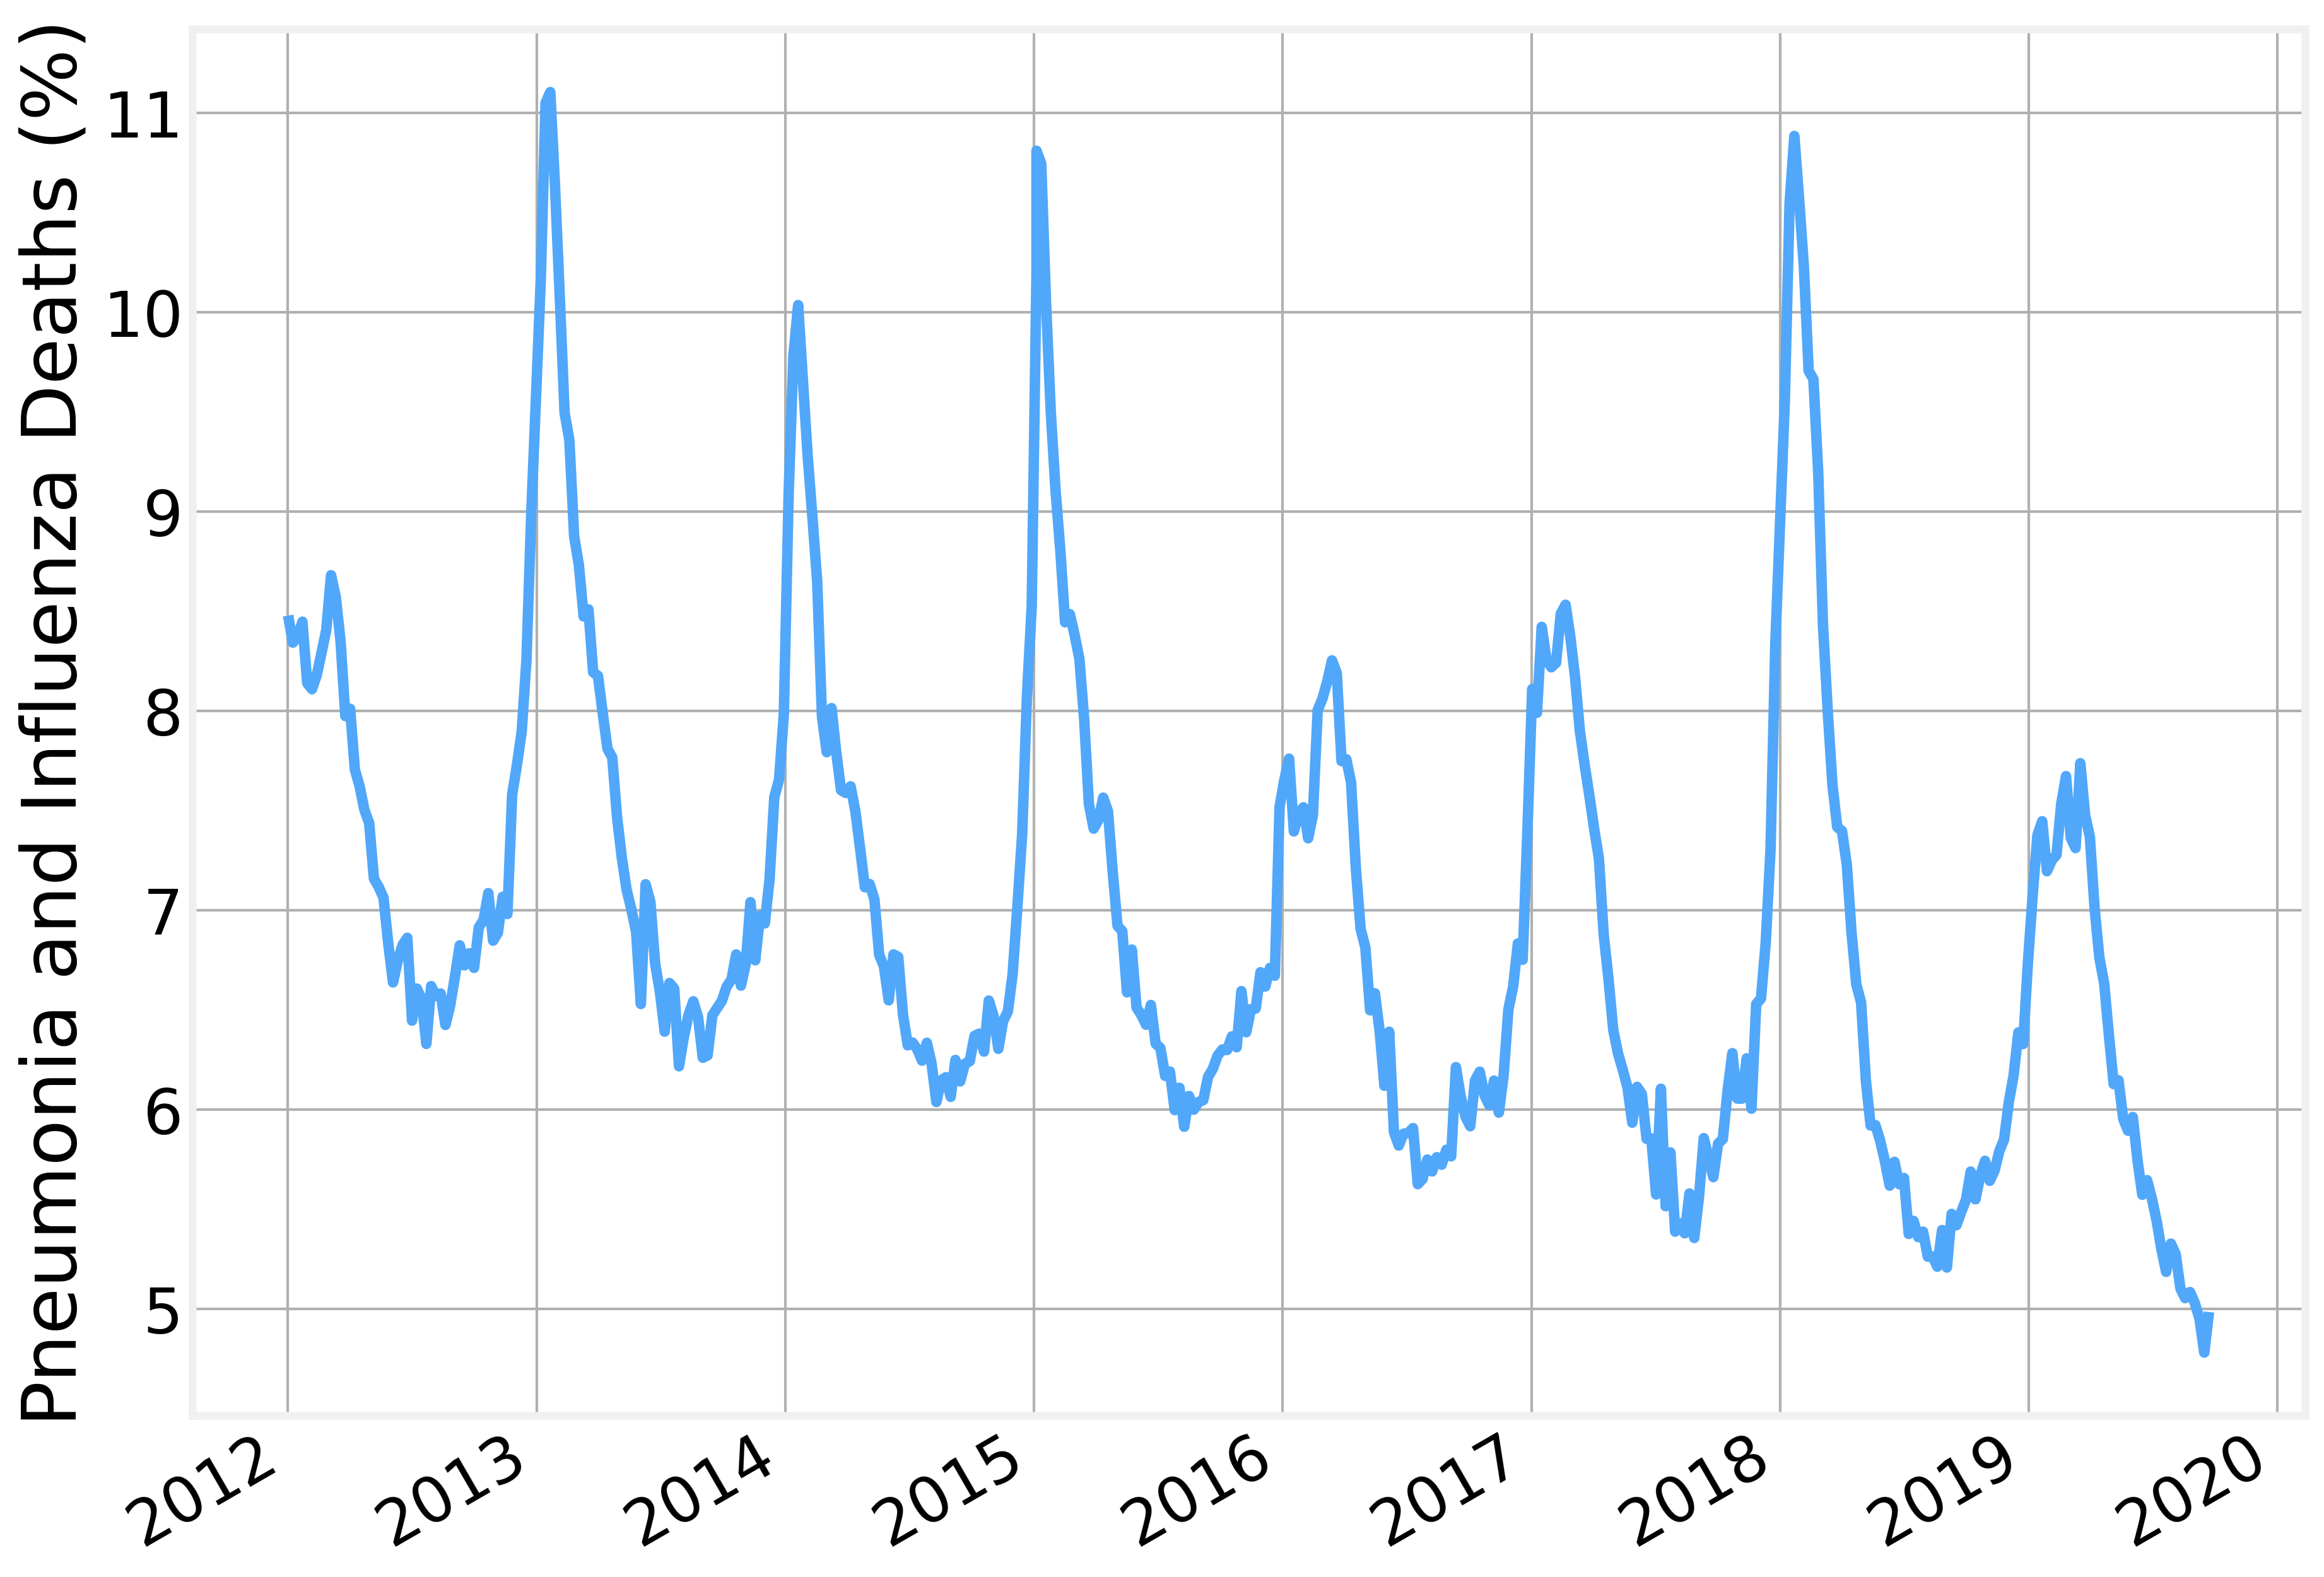

In [32]:
ax=ILI.plot(legend=None)
ax.set_xlabel(None)
ax.set_ylabel('Pneumonia and Influenza Deaths (%)')

We start by performing an Augmented Dickey-Fuller test to confirm that the time series is stationary

In [36]:
adf, pvalue, critical, results = sm.tsa.stattools.adfuller(ILI, regresults=True)

which indeed is confirmed by the p-value

In [37]:
pvalue

0.00016034951684142202

The next step is then to plot the Autocorrelation function

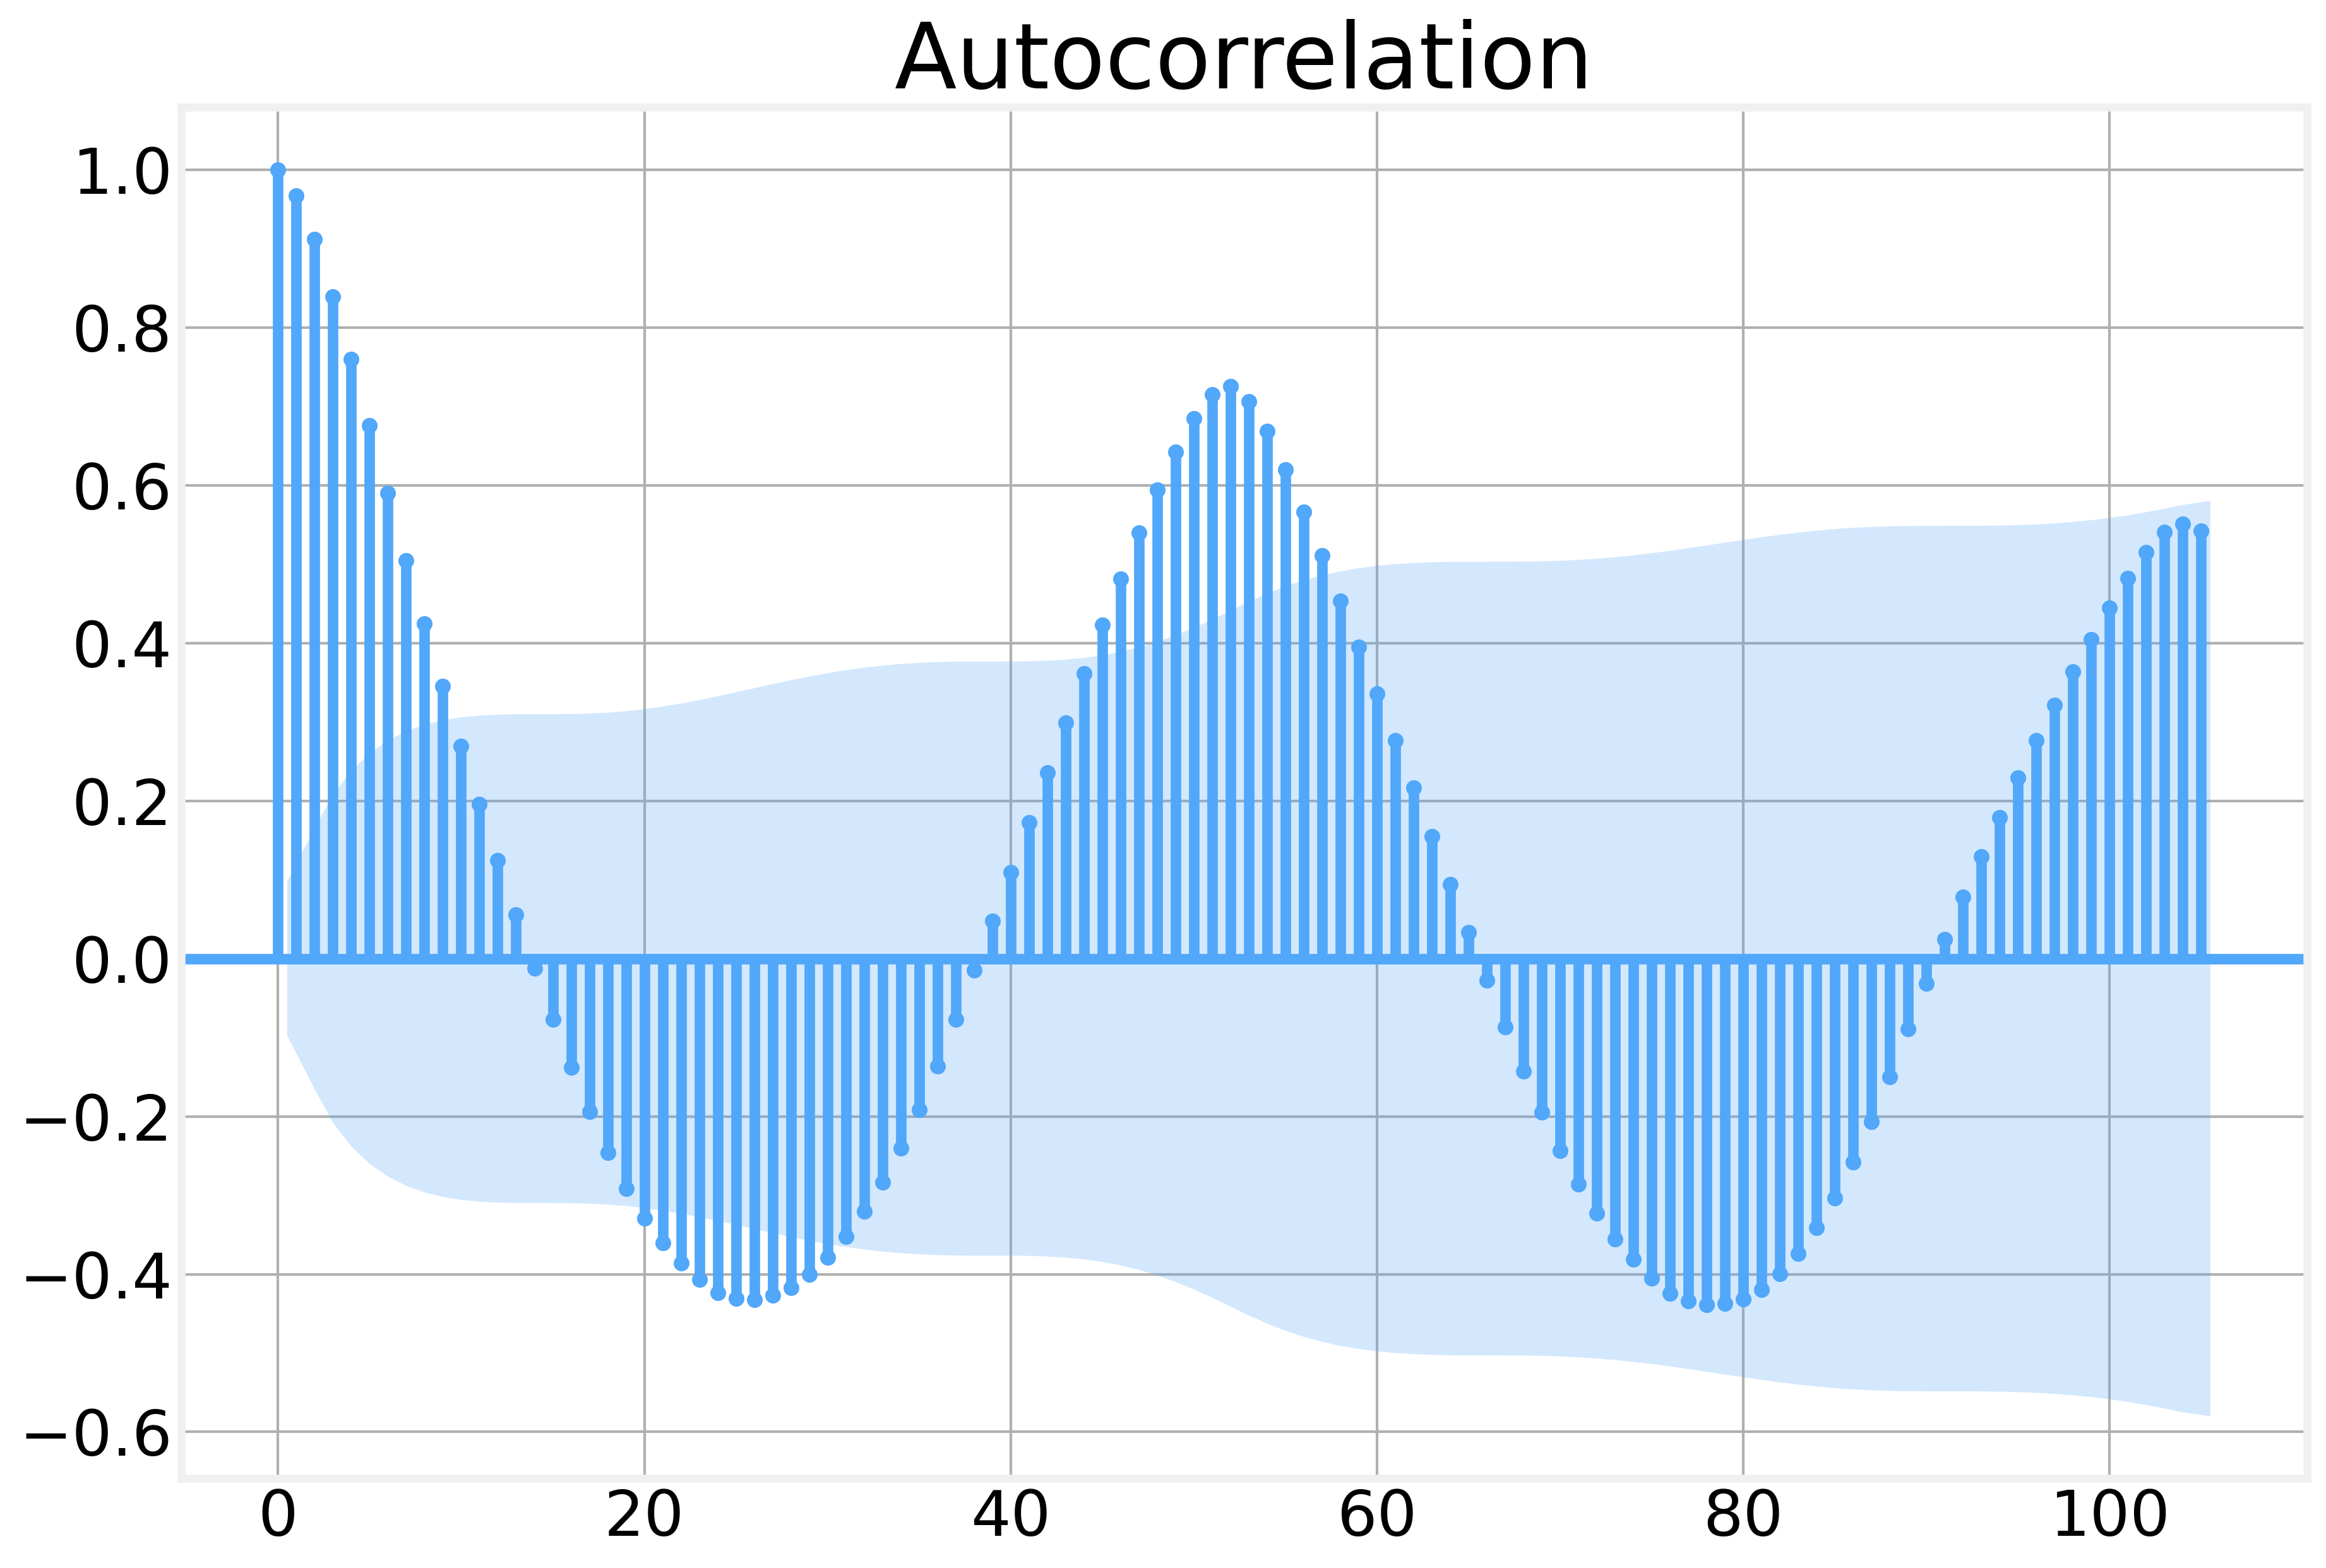

In [38]:
sm.graphics.tsa.plot_acf(ILI, lags=105);

This seems to indicate that the time series is not stationary. Indeed, the oscilating pattern of the ACF is a clue that the have a strong seasonal behavior every 52 weeks. We can (for now) bypass this problem by taking the first difference of the original timeseries

In [39]:
ILI2 = ILI.diff(1).dropna()[:'2018']

In [40]:
ILI2.tail()

Percent of Deaths Due to Pneumonia and Influenza
Date                                                        
2018-12-03                                          0.187939
2018-12-10                                          0.132627
2018-12-17                                          0.216503
2018-12-24                                         -0.058391
2018-12-31                                          0.408337

Let us visualize the difference dataset

Text(0, 0.5, 'WoW change')

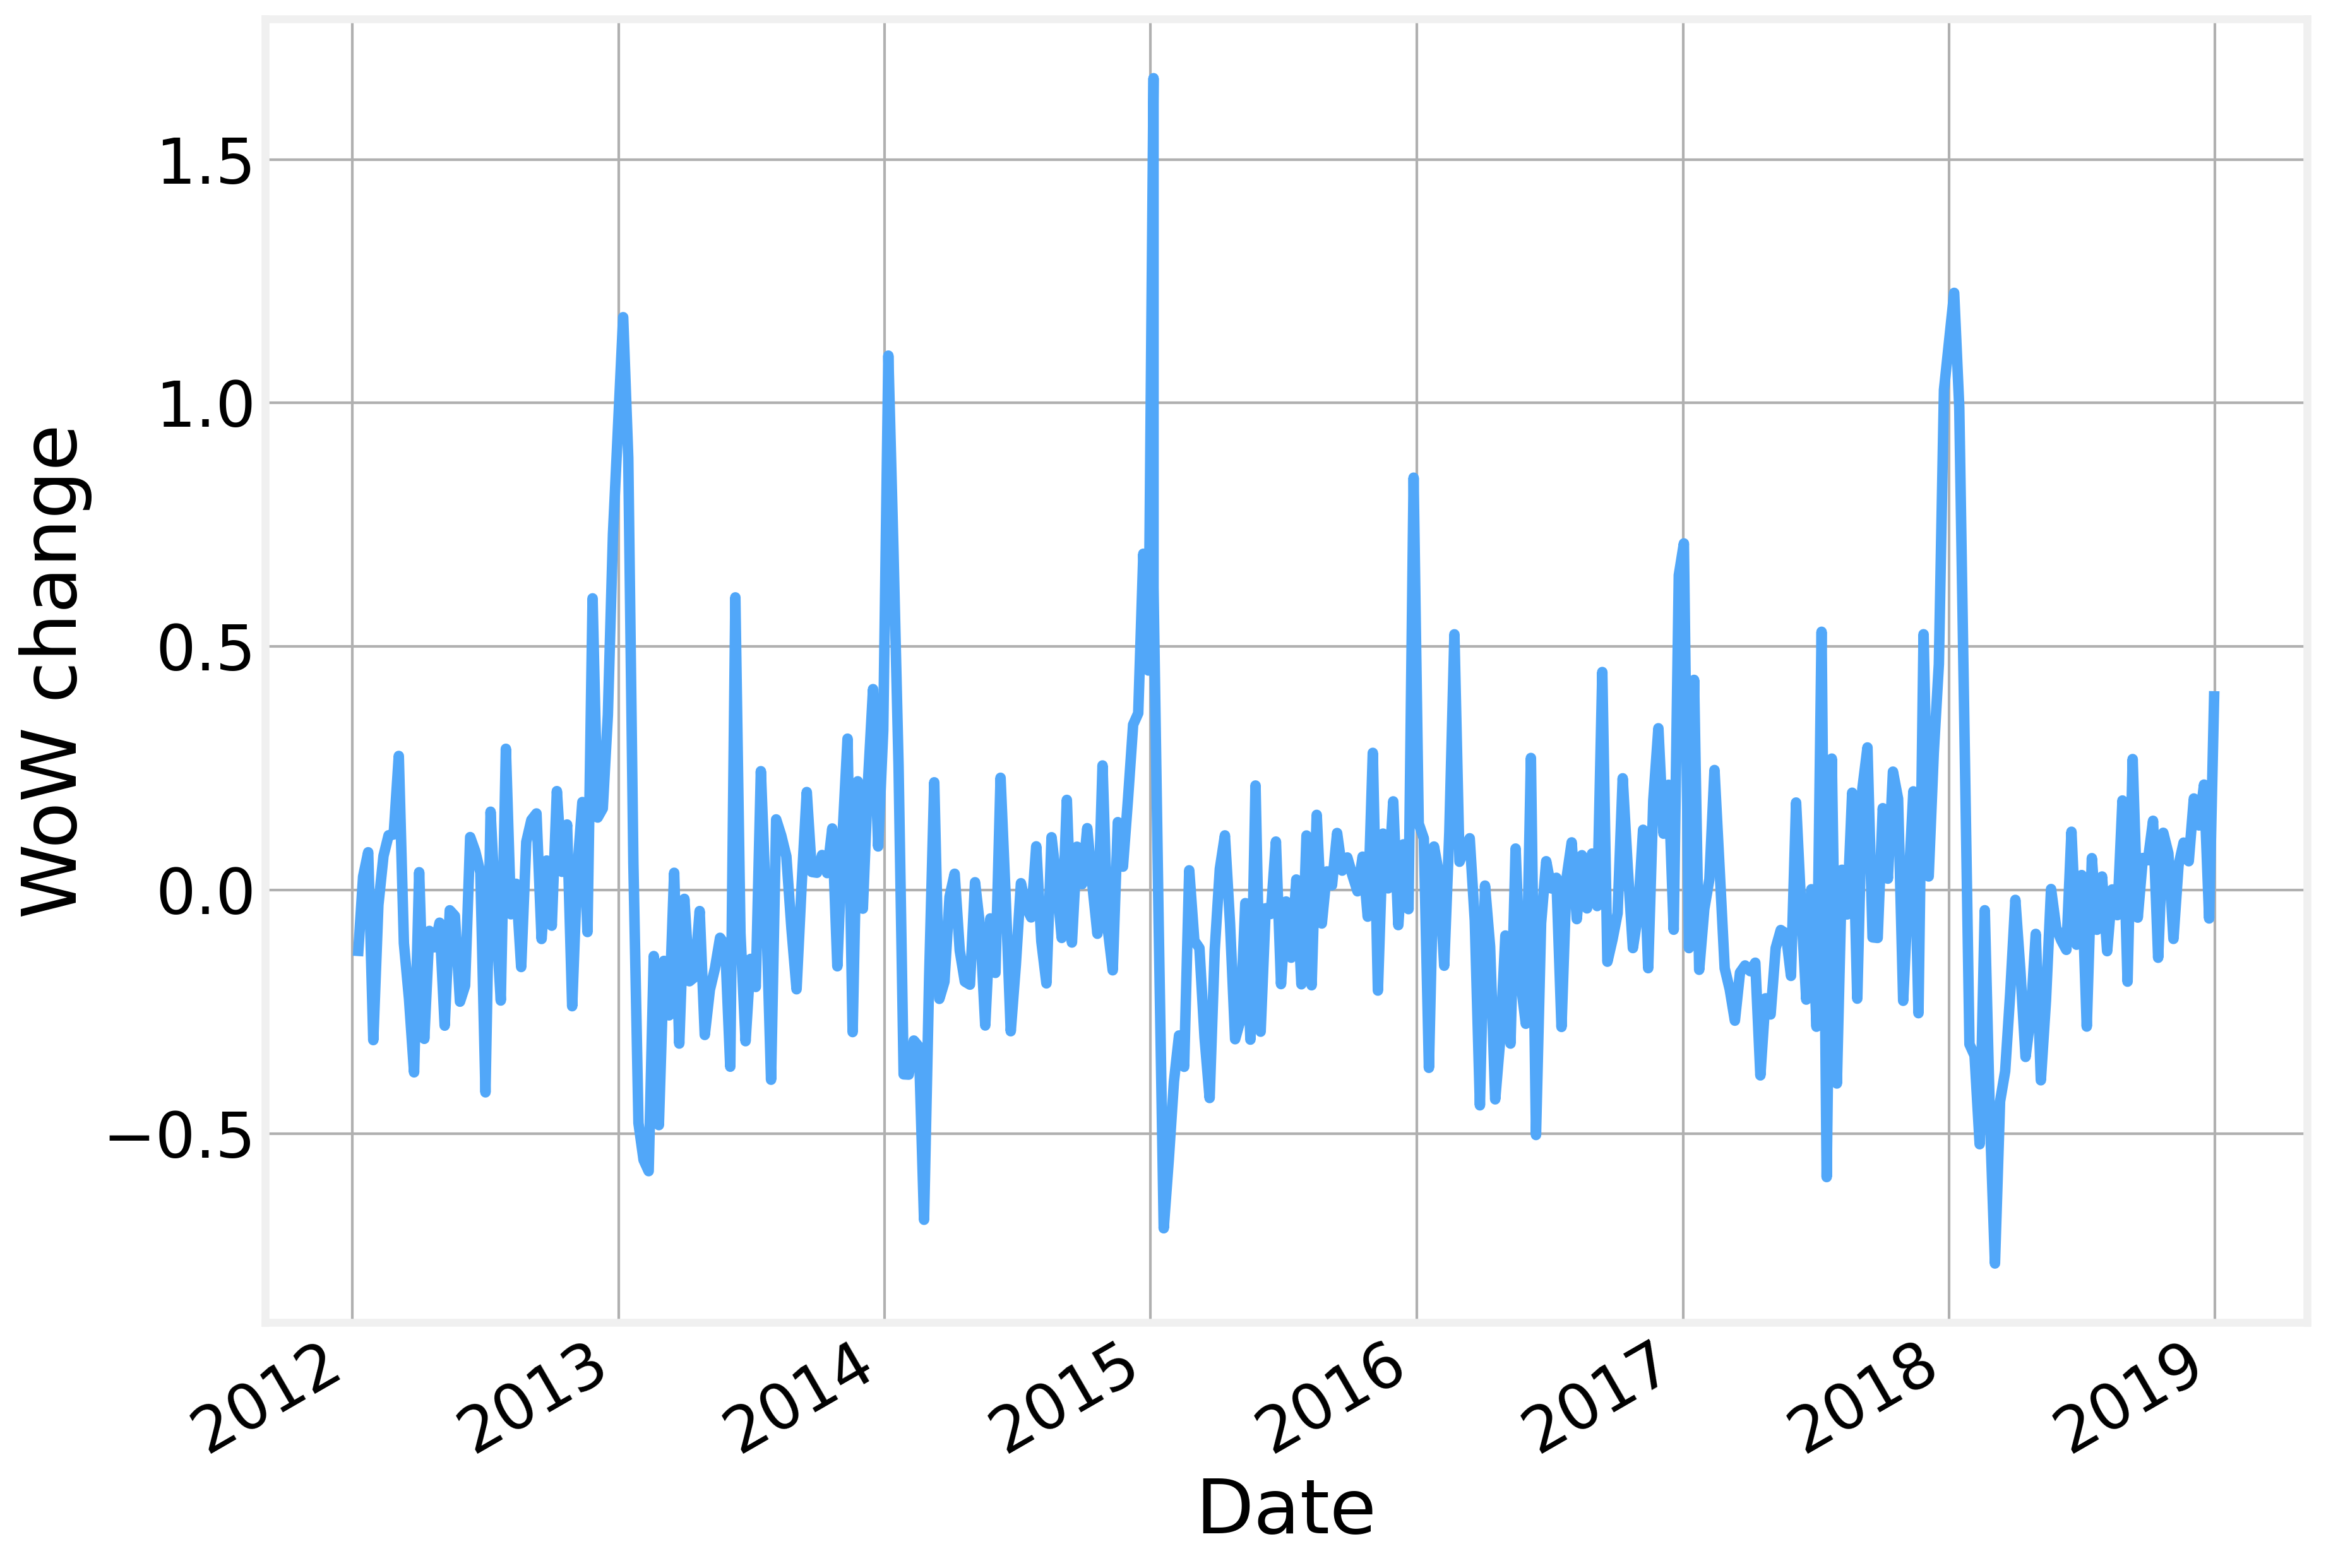

In [41]:
ax = ILI2.plot(legend=None)
ax.set_ylabel('WoW change')

Now, when we plot the auto-correlation function we find something much more reasonable, with significant lags up to 2

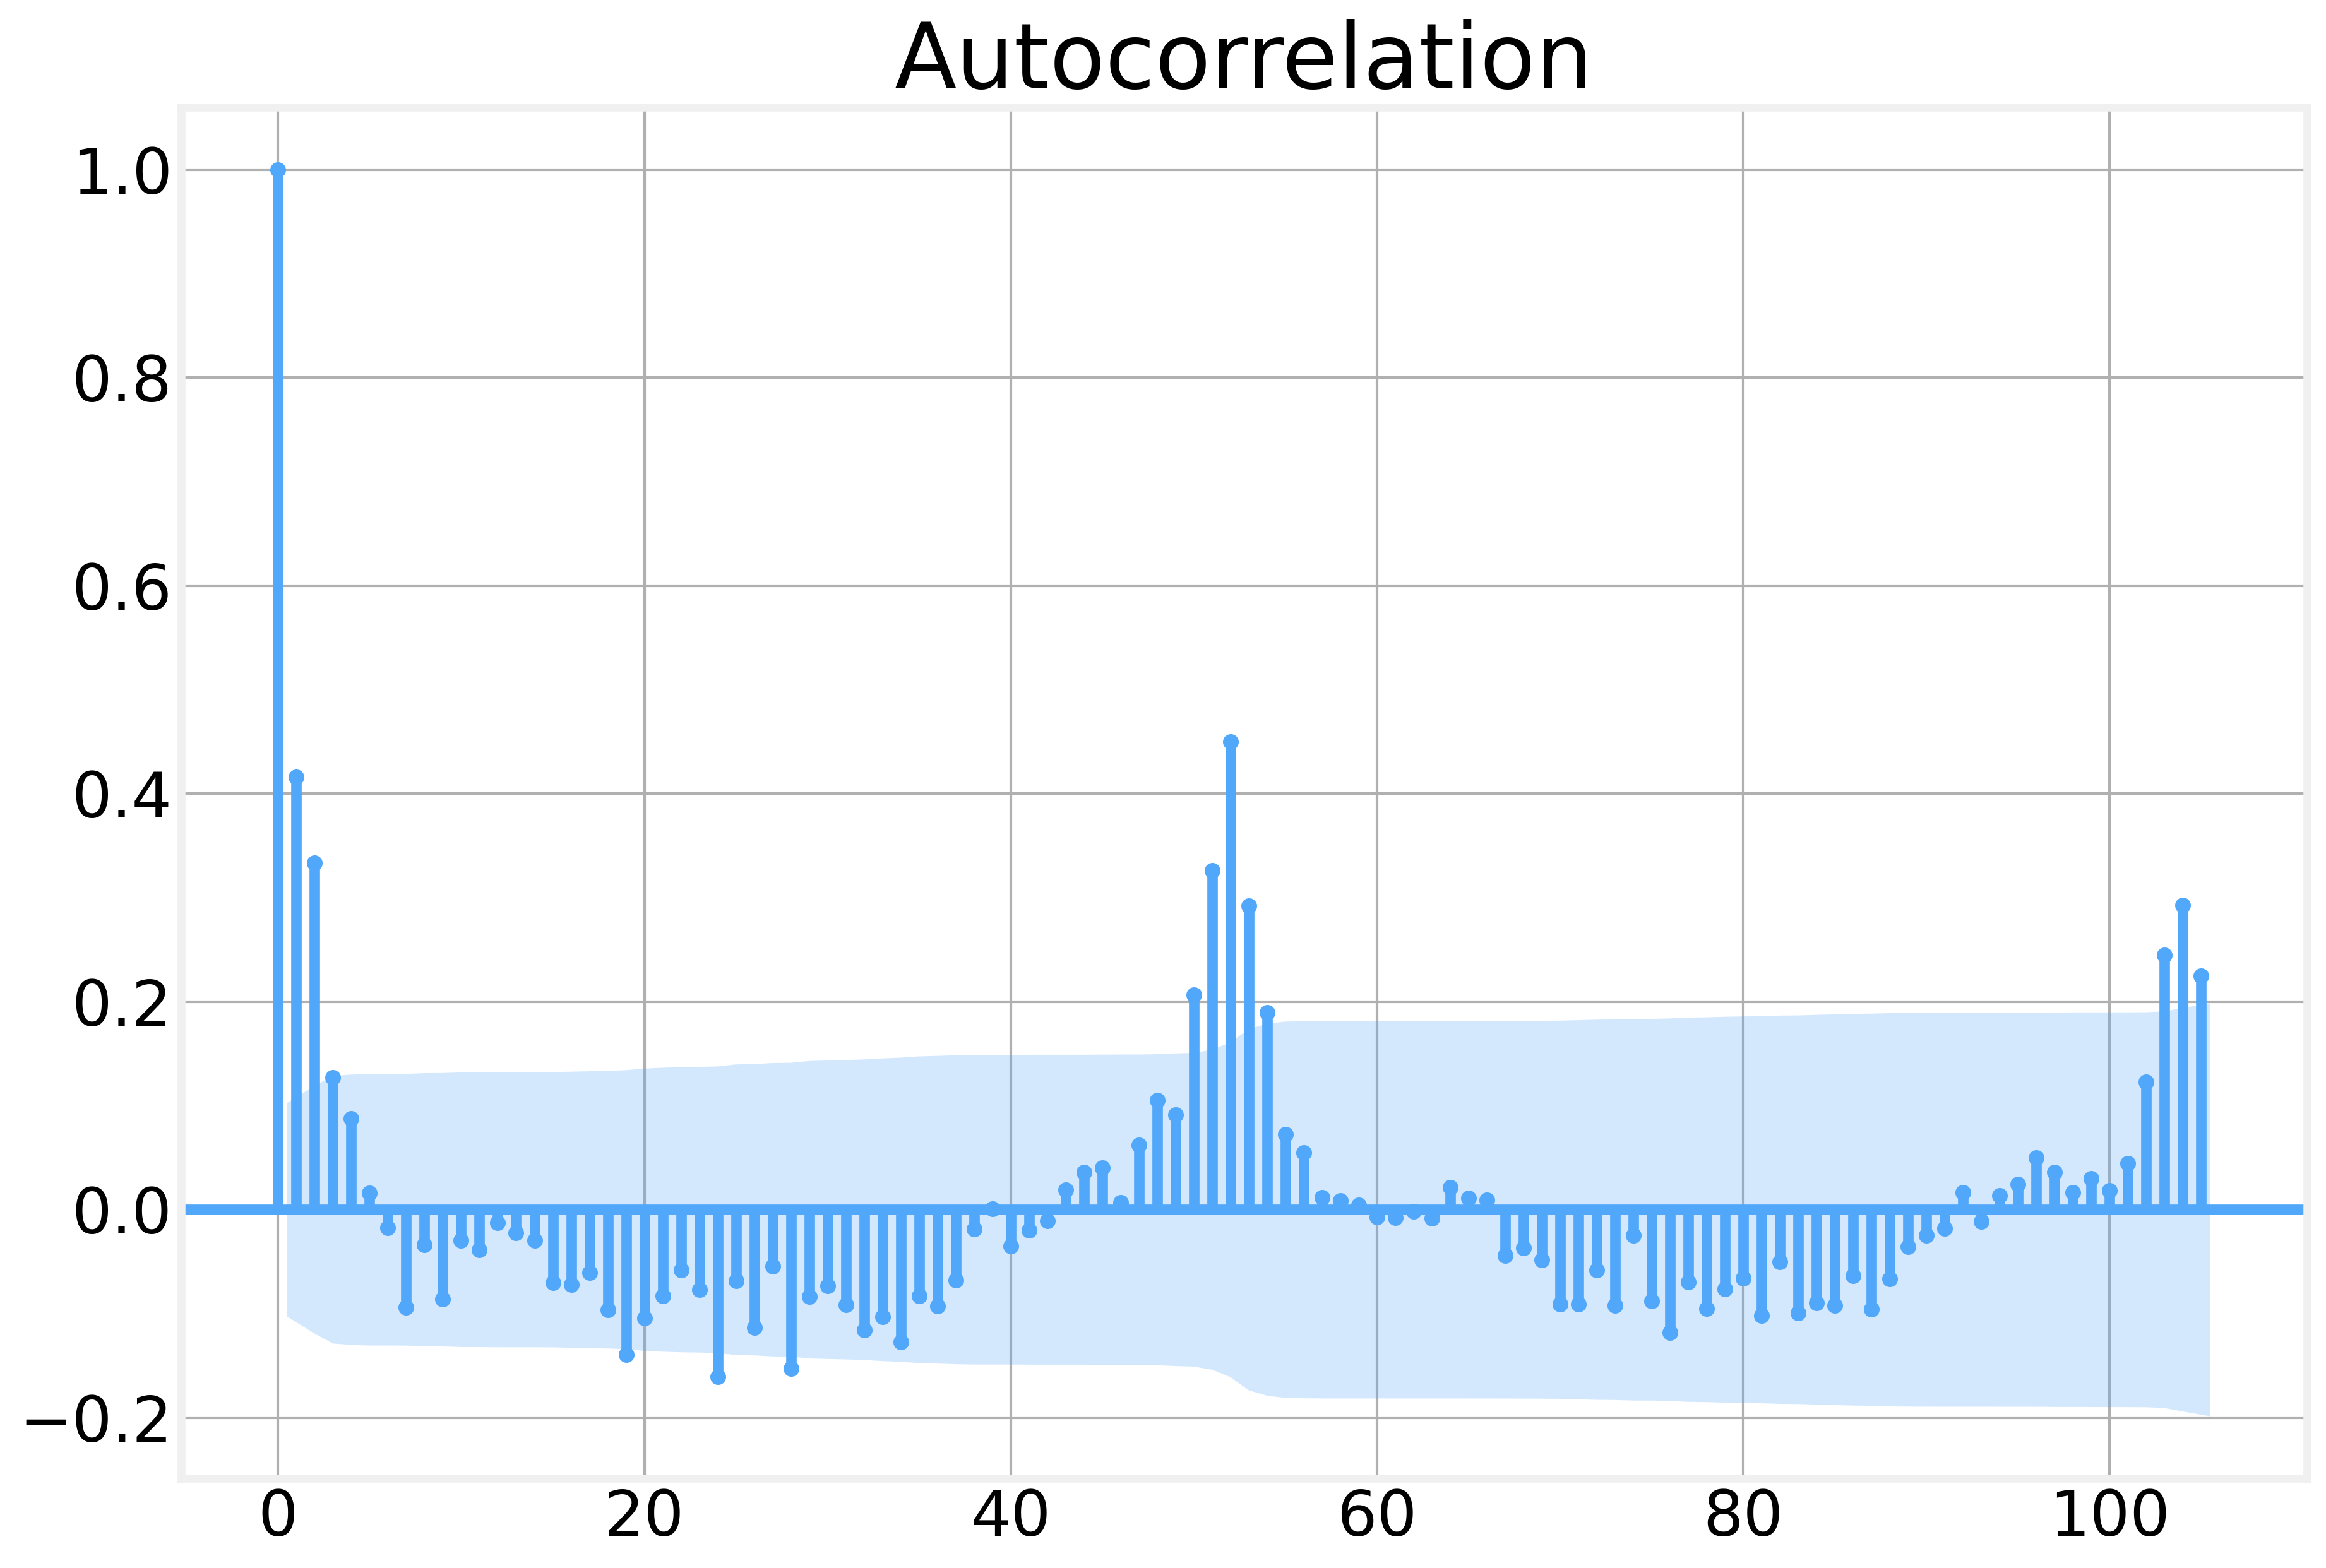

In [42]:
sm.graphics.tsa.plot_acf(ILI2, lags=105);

Although we haven't completely removed the seasonal behavior it is much reduced.

Next we plot the PACF

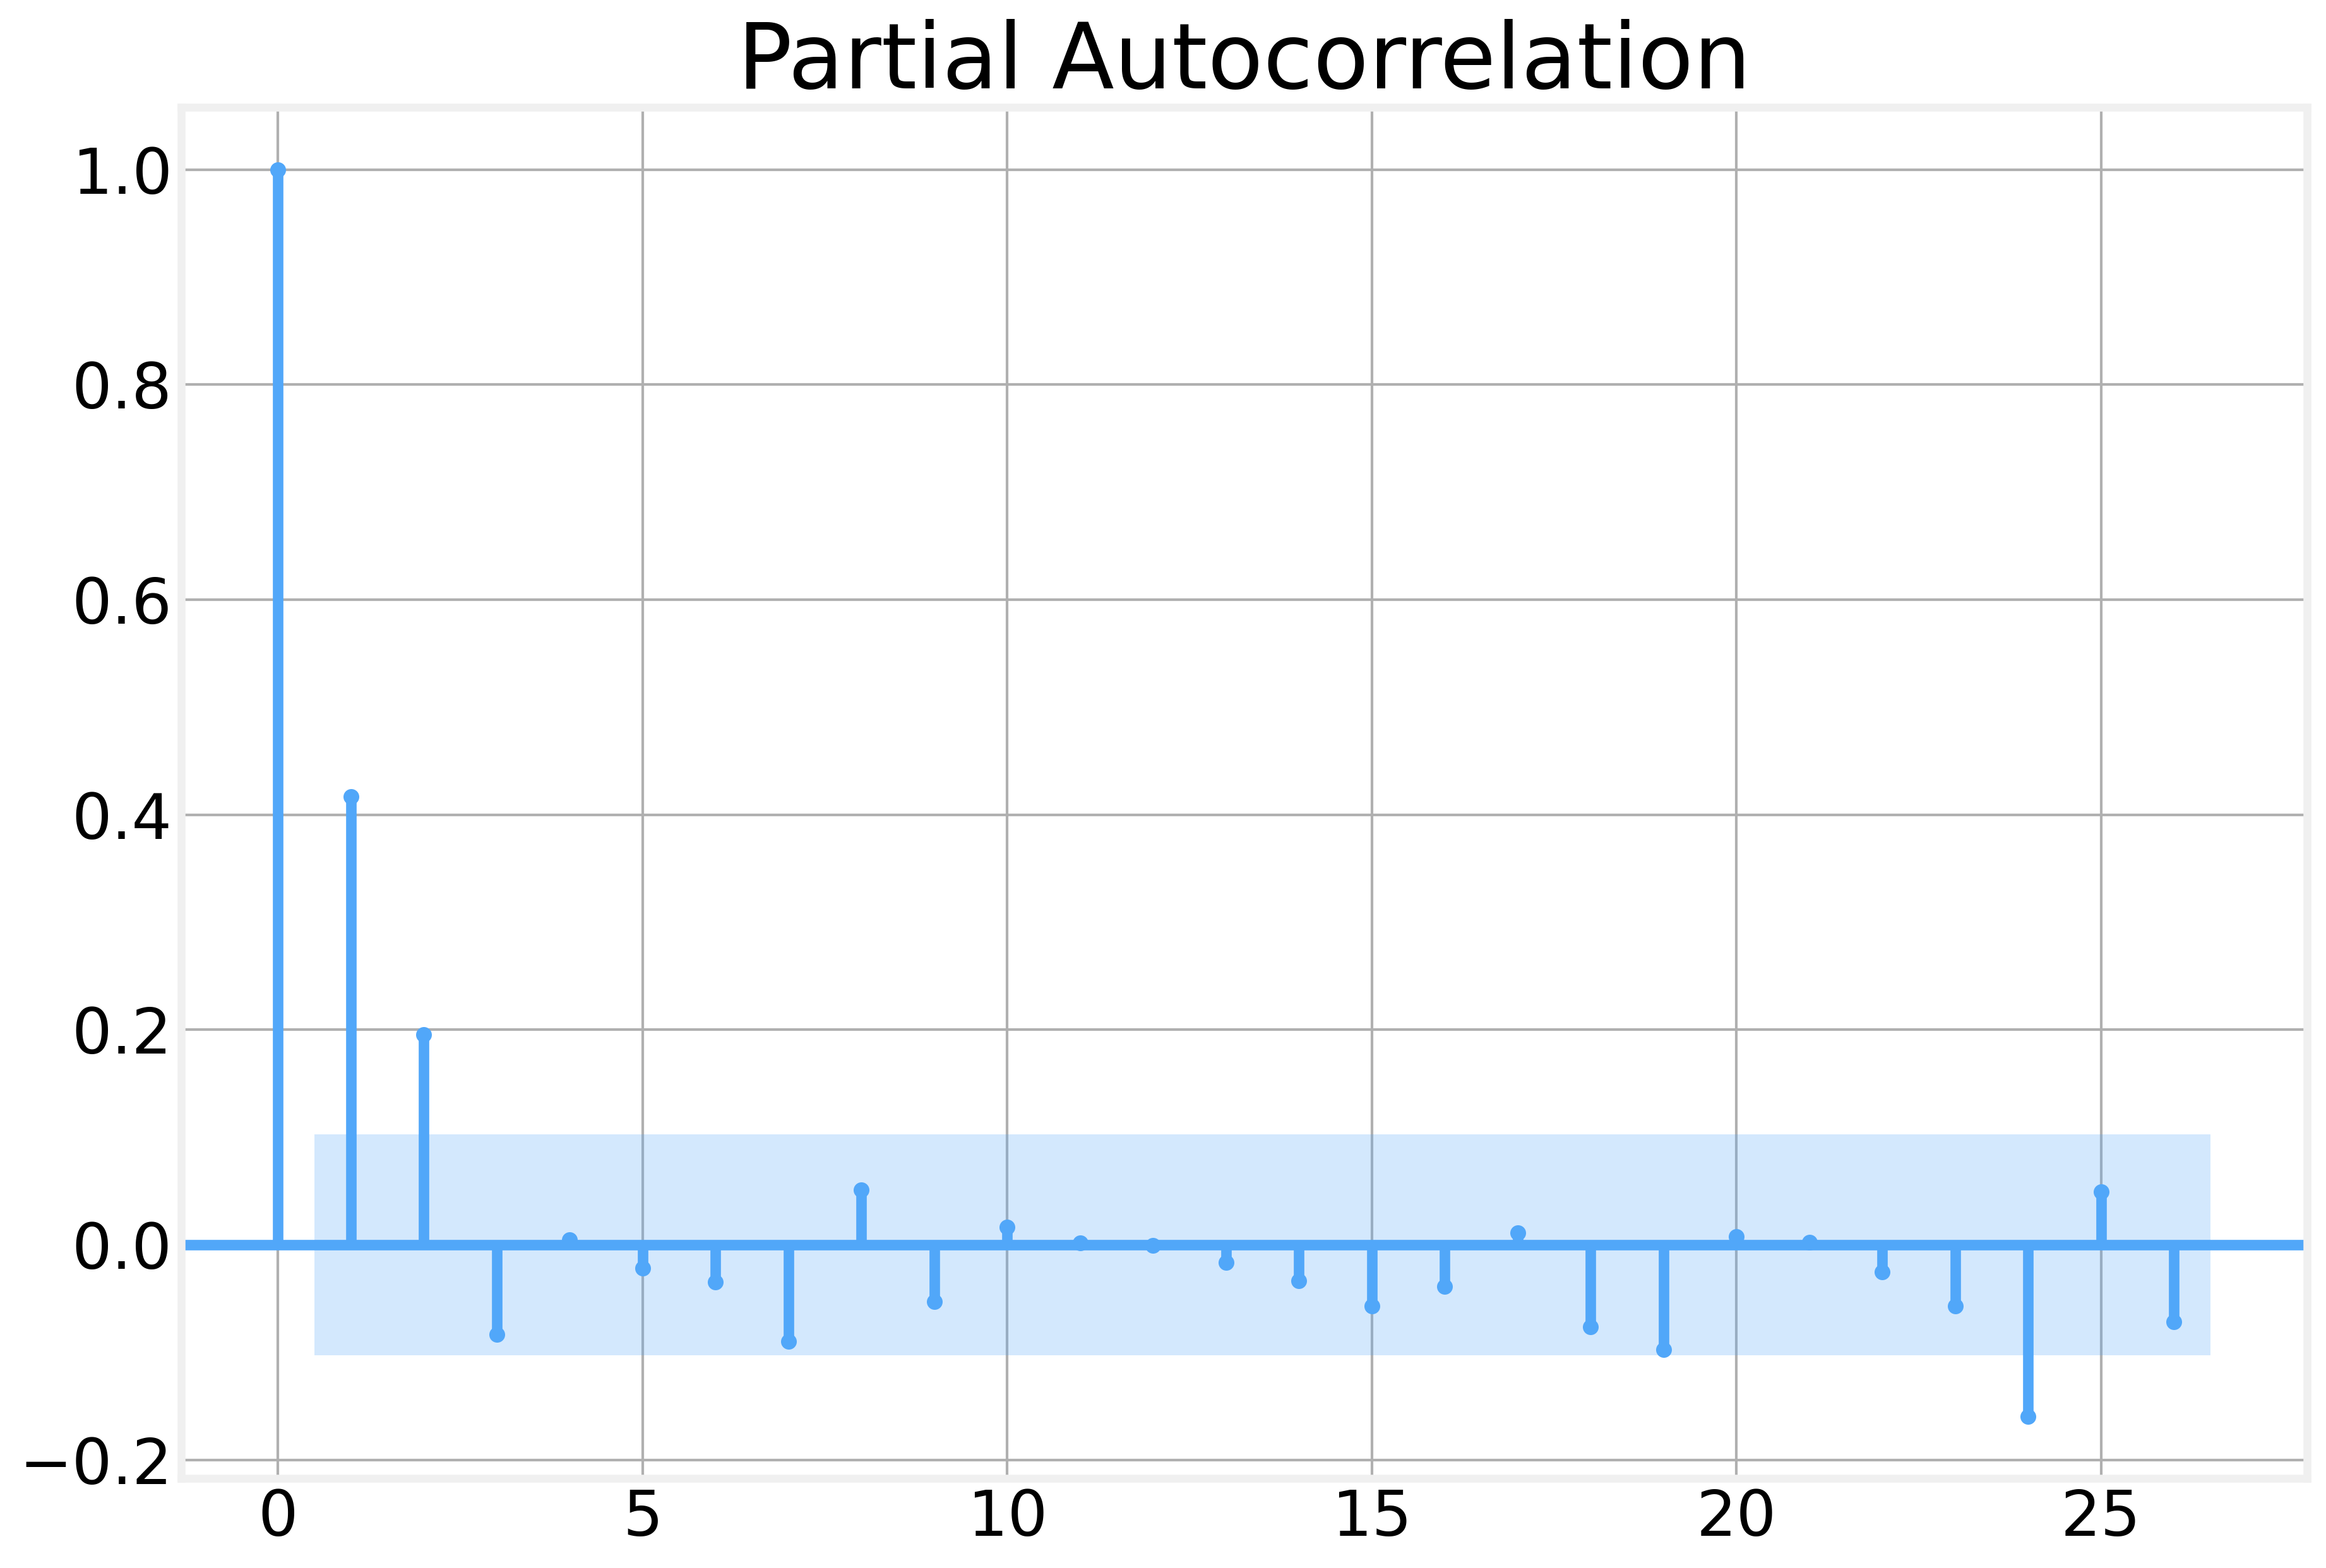

In [43]:
sm.graphics.tsa.plot_pacf(ILI2);

And again find two significant lags

In [44]:
model = sm.tsa.ARIMA(ILI[:'2018'], (2, 1, 2))
results = model.fit()

In [45]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                             ARIMA Model Results                                              
==============================================================================================================
Dep. Variable:     D.Percent of Deaths Due to Pneumonia and Influenza   No. Observations:                  364
Model:                                                 ARIMA(2, 1, 2)   Log Likelihood                 -25.016
Method:                                                       css-mle   S.D. of innovations              0.259
Date:                                                Mon, 16 Aug 2021   AIC                             62.032
Time:                                                        15:30:13   BIC                             85.415
Sample:                                                             1   HQIC                            71.325
                                                                                                              
============================================================================================================================
                                                               coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------
const                                                       -0.0042      0.027     -0.154      0.877      -0.057       0.049
ar.L1.D.Percent of Deaths Due to Pneumonia and Influenza     0.0477      0.370      0.129      0.897      -0.678       0.773
ar.L2.D.Percent of Deaths Due to Pneumonia and Influenza     0.2714      0.316      0.859      0.390      -0.348       0.891
ma.L1.D.Percent of Deaths Due to Pneumonia and Influenza     0.3046      0.373      0.817      0.414      -0.426       1.035
ma.L2.D.Percent of Deaths Due to Pneumonia and Influenza     0.0540      0.219      0.246      0.805      -0.376       0.484
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.8336           +0.0000j            1.8336            0.0000
AR.2           -2.0094           +0.0000j            2.0094            0.5000
MA.1           -2.8200           -3.2501j            4.3030           -0.3637
MA.2           -2.8200           +3.2501j            4.3030            0.3637
-----------------------------------------------------------------------------
"""

Text(0, 0.5, 'Pneumonia and Influenza Deaths (%)')

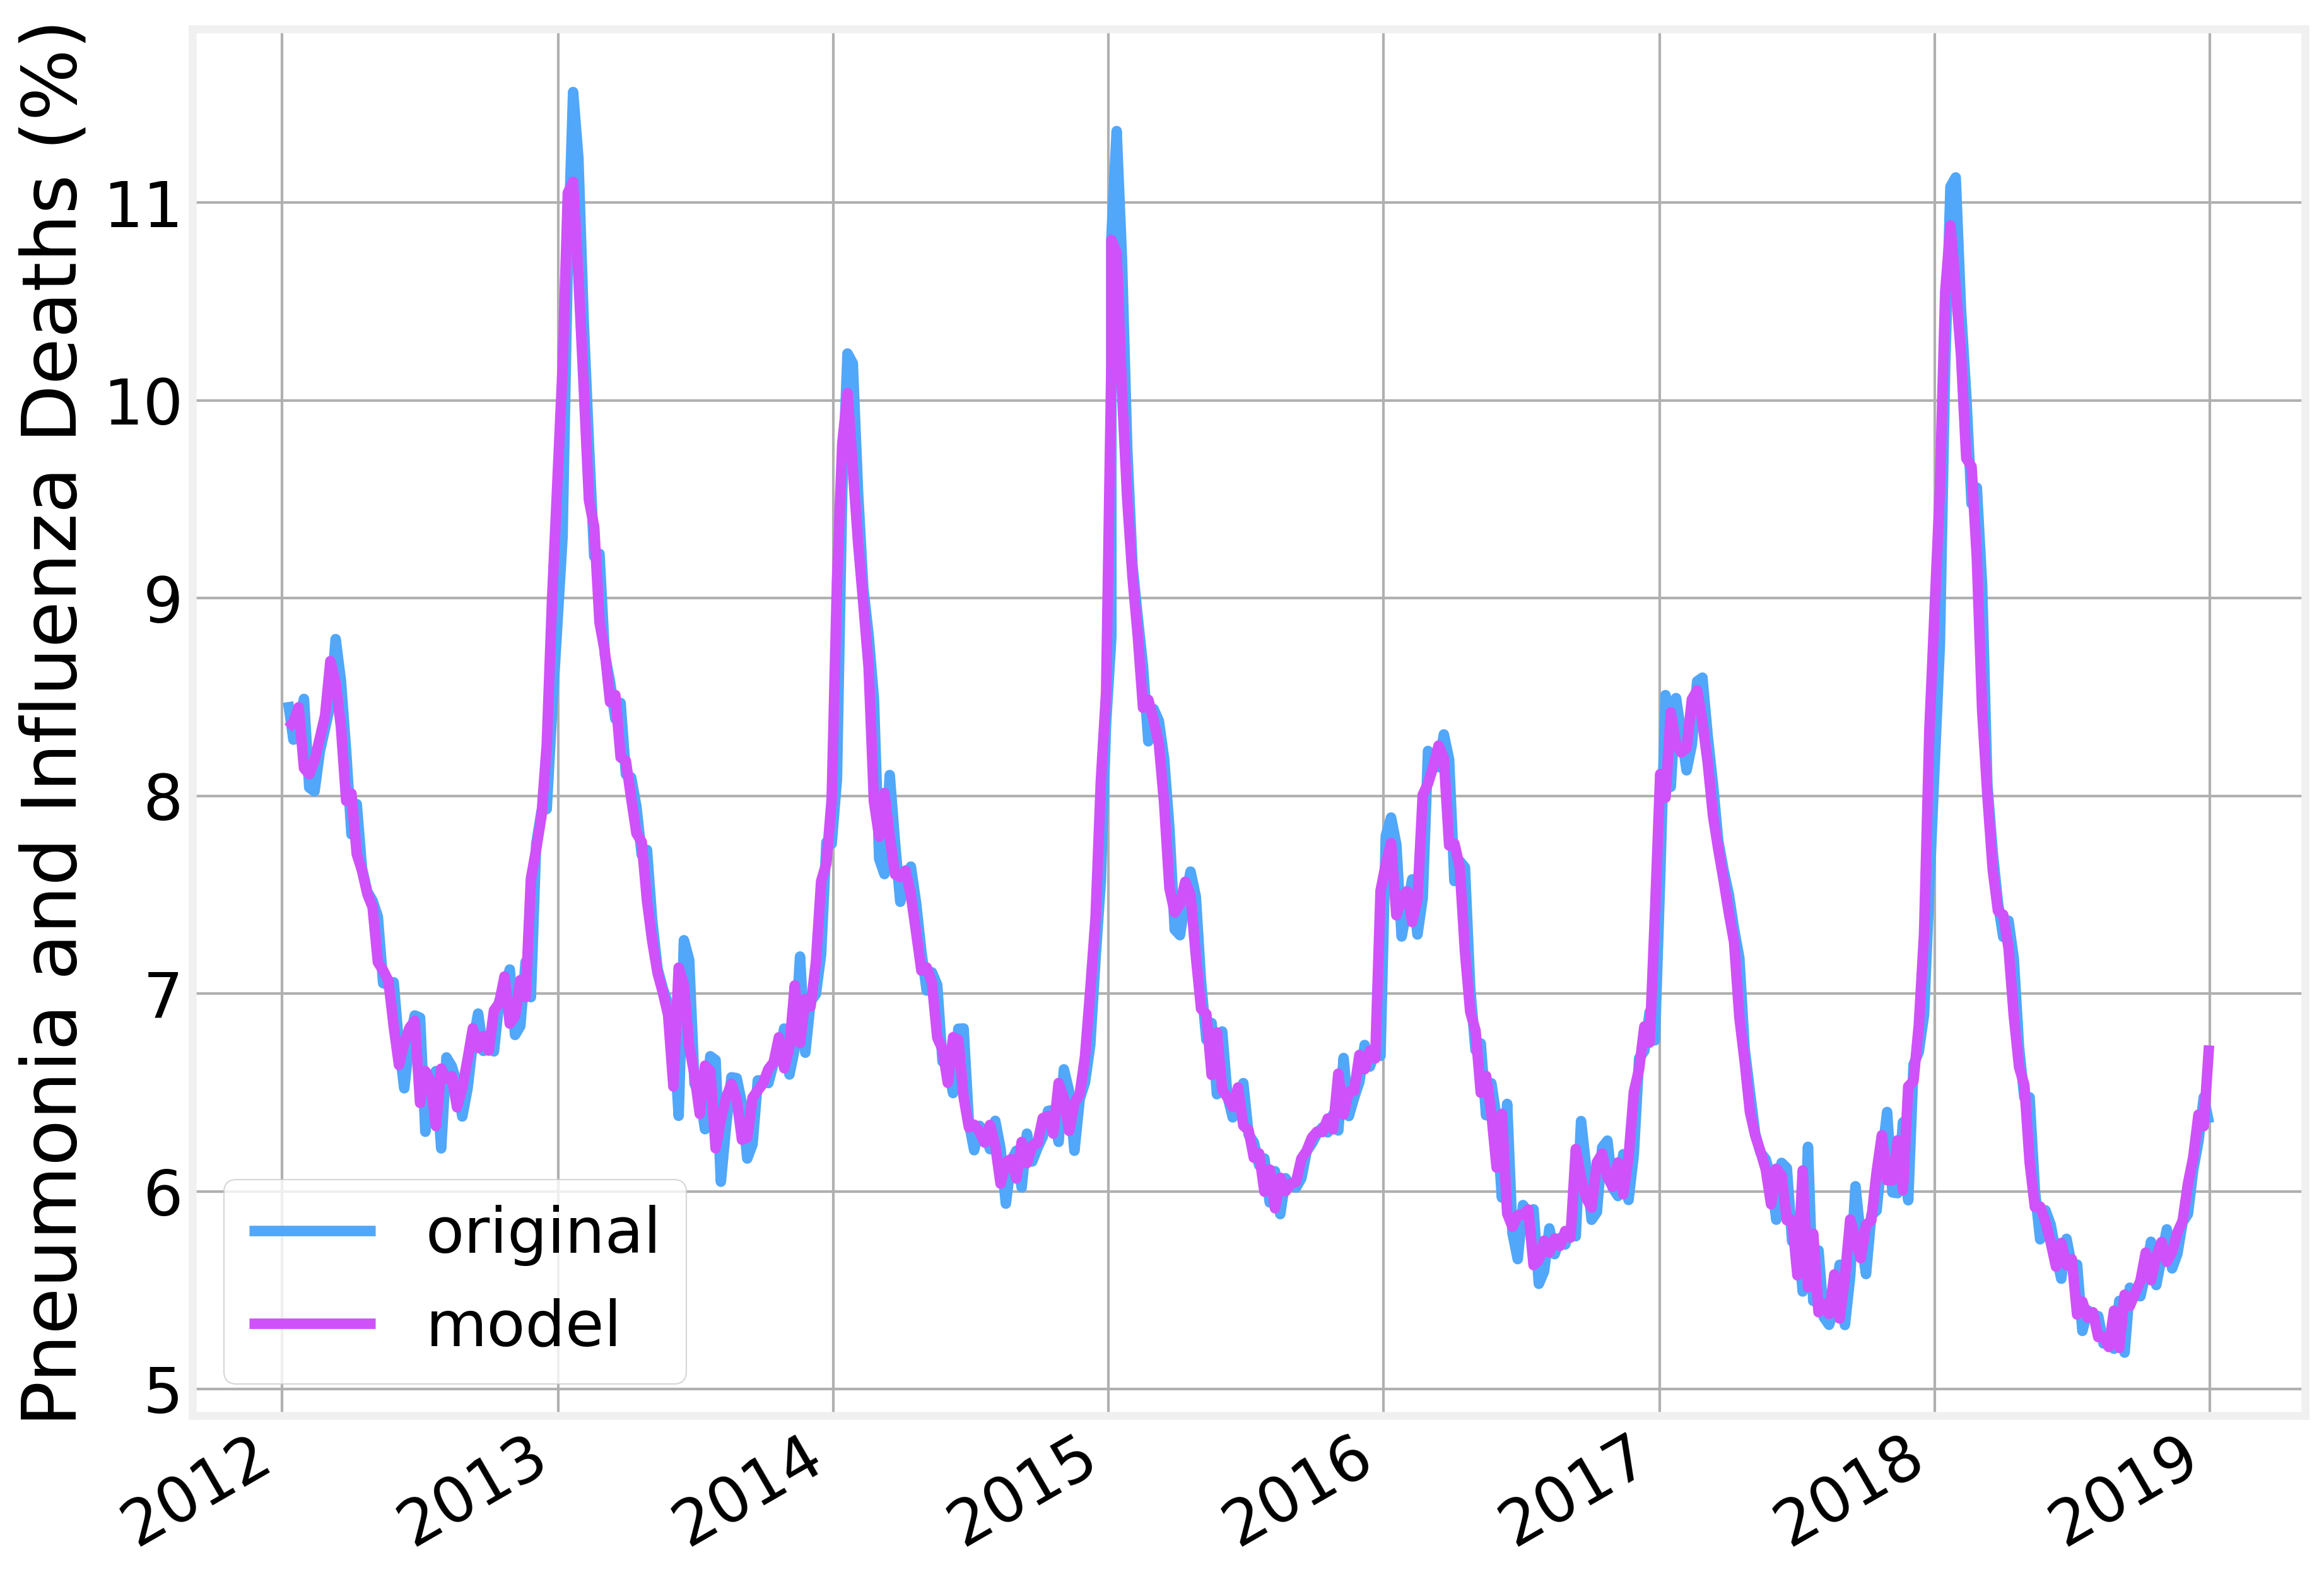

In [46]:
fig, ax = plt.subplots(1, 1)
pred_sm = results.plot_predict(ax=ax)
plt.legend(['original', 'model'])
ax.set_xlabel(None)
ax.set_ylabel('Pneumonia and Influenza Deaths (%)')

Text(0, 0.5, 'Pneumonia and Influenza Deaths (%)')

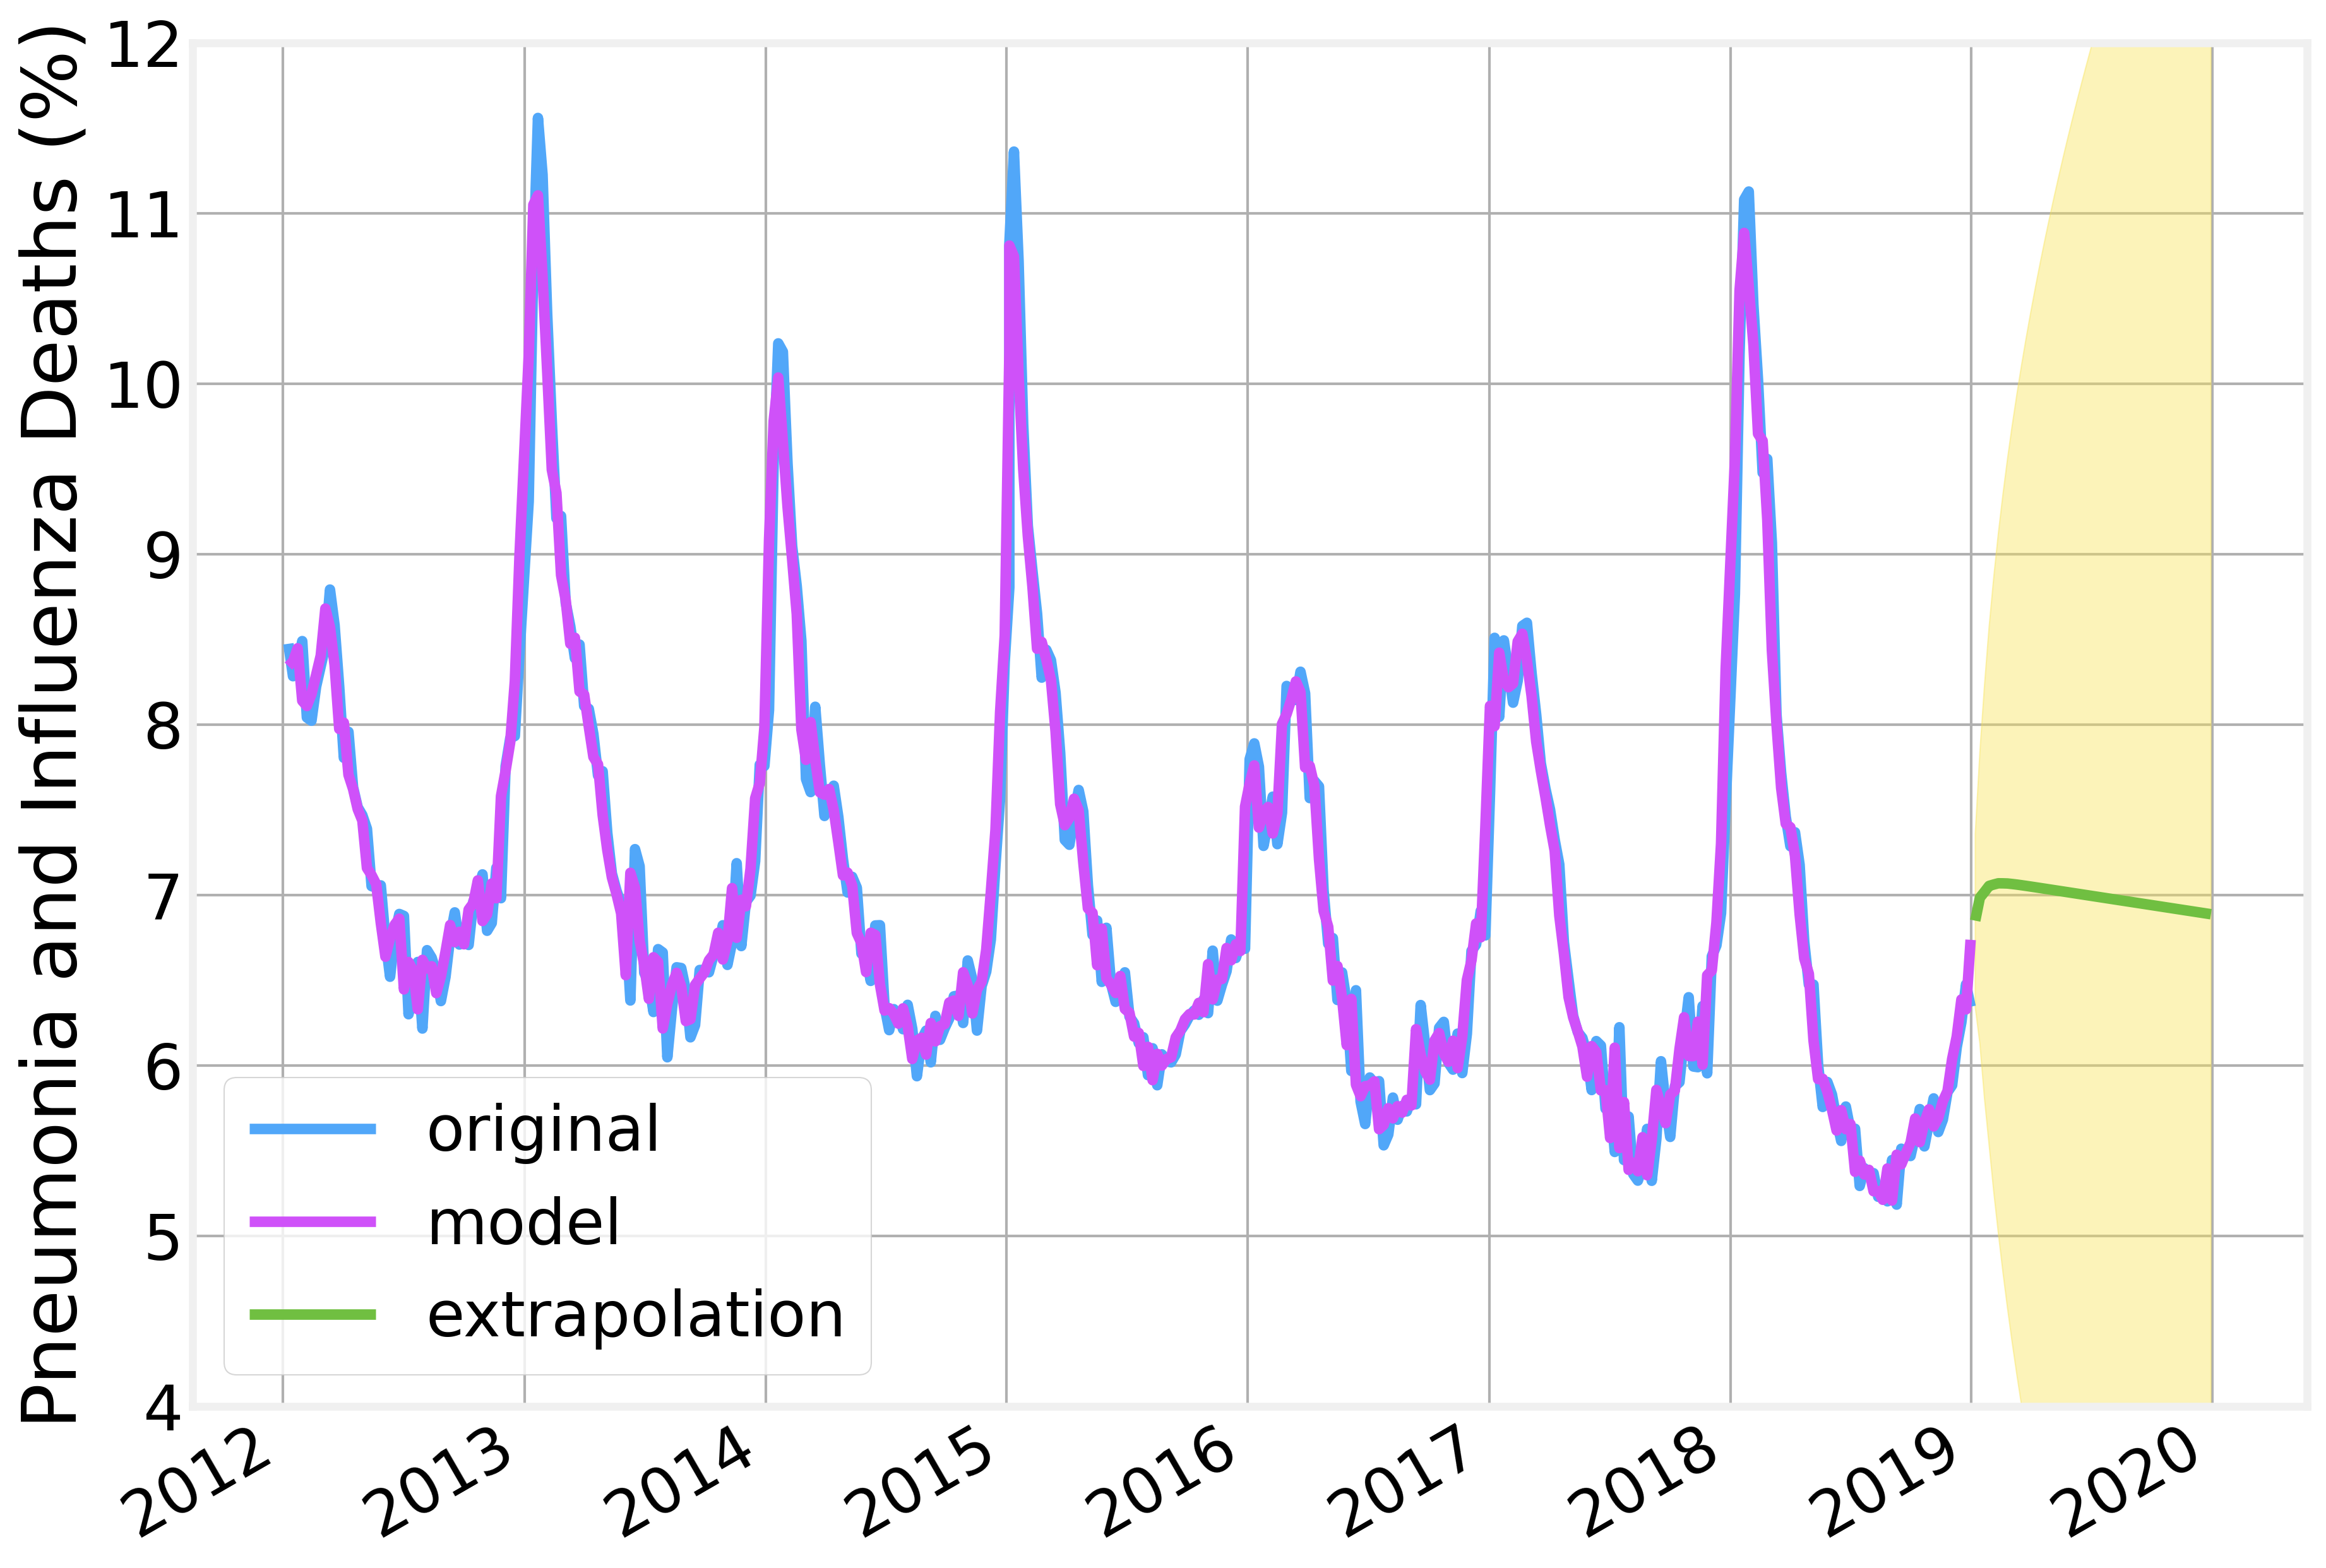

In [47]:
fig, ax = plt.subplots(1, 1)
results.plot_predict(ax=ax);

new_weeks = ILI2.index[-1]+pd.timedelta_range('7 day', periods=52, freq='7d')
forecast = results.forecast(steps=52)
ax.plot(new_weeks, forecast[0])
ax.fill_between(new_weeks, forecast[2].T[0], forecast[2].T[1], alpha=0.4, color=colors[4])

ax.legend(['original', 'model', 'extrapolation'])
ax.set_ylim(4, 12)
ax.set_xlabel(None)
ax.set_ylabel('Pneumonia and Influenza Deaths (%)')

# SARIMA

In [48]:
seasonal_ILI = ILI.diff(52).diff(1).dropna().copy()

Text(0.5, 0, '')

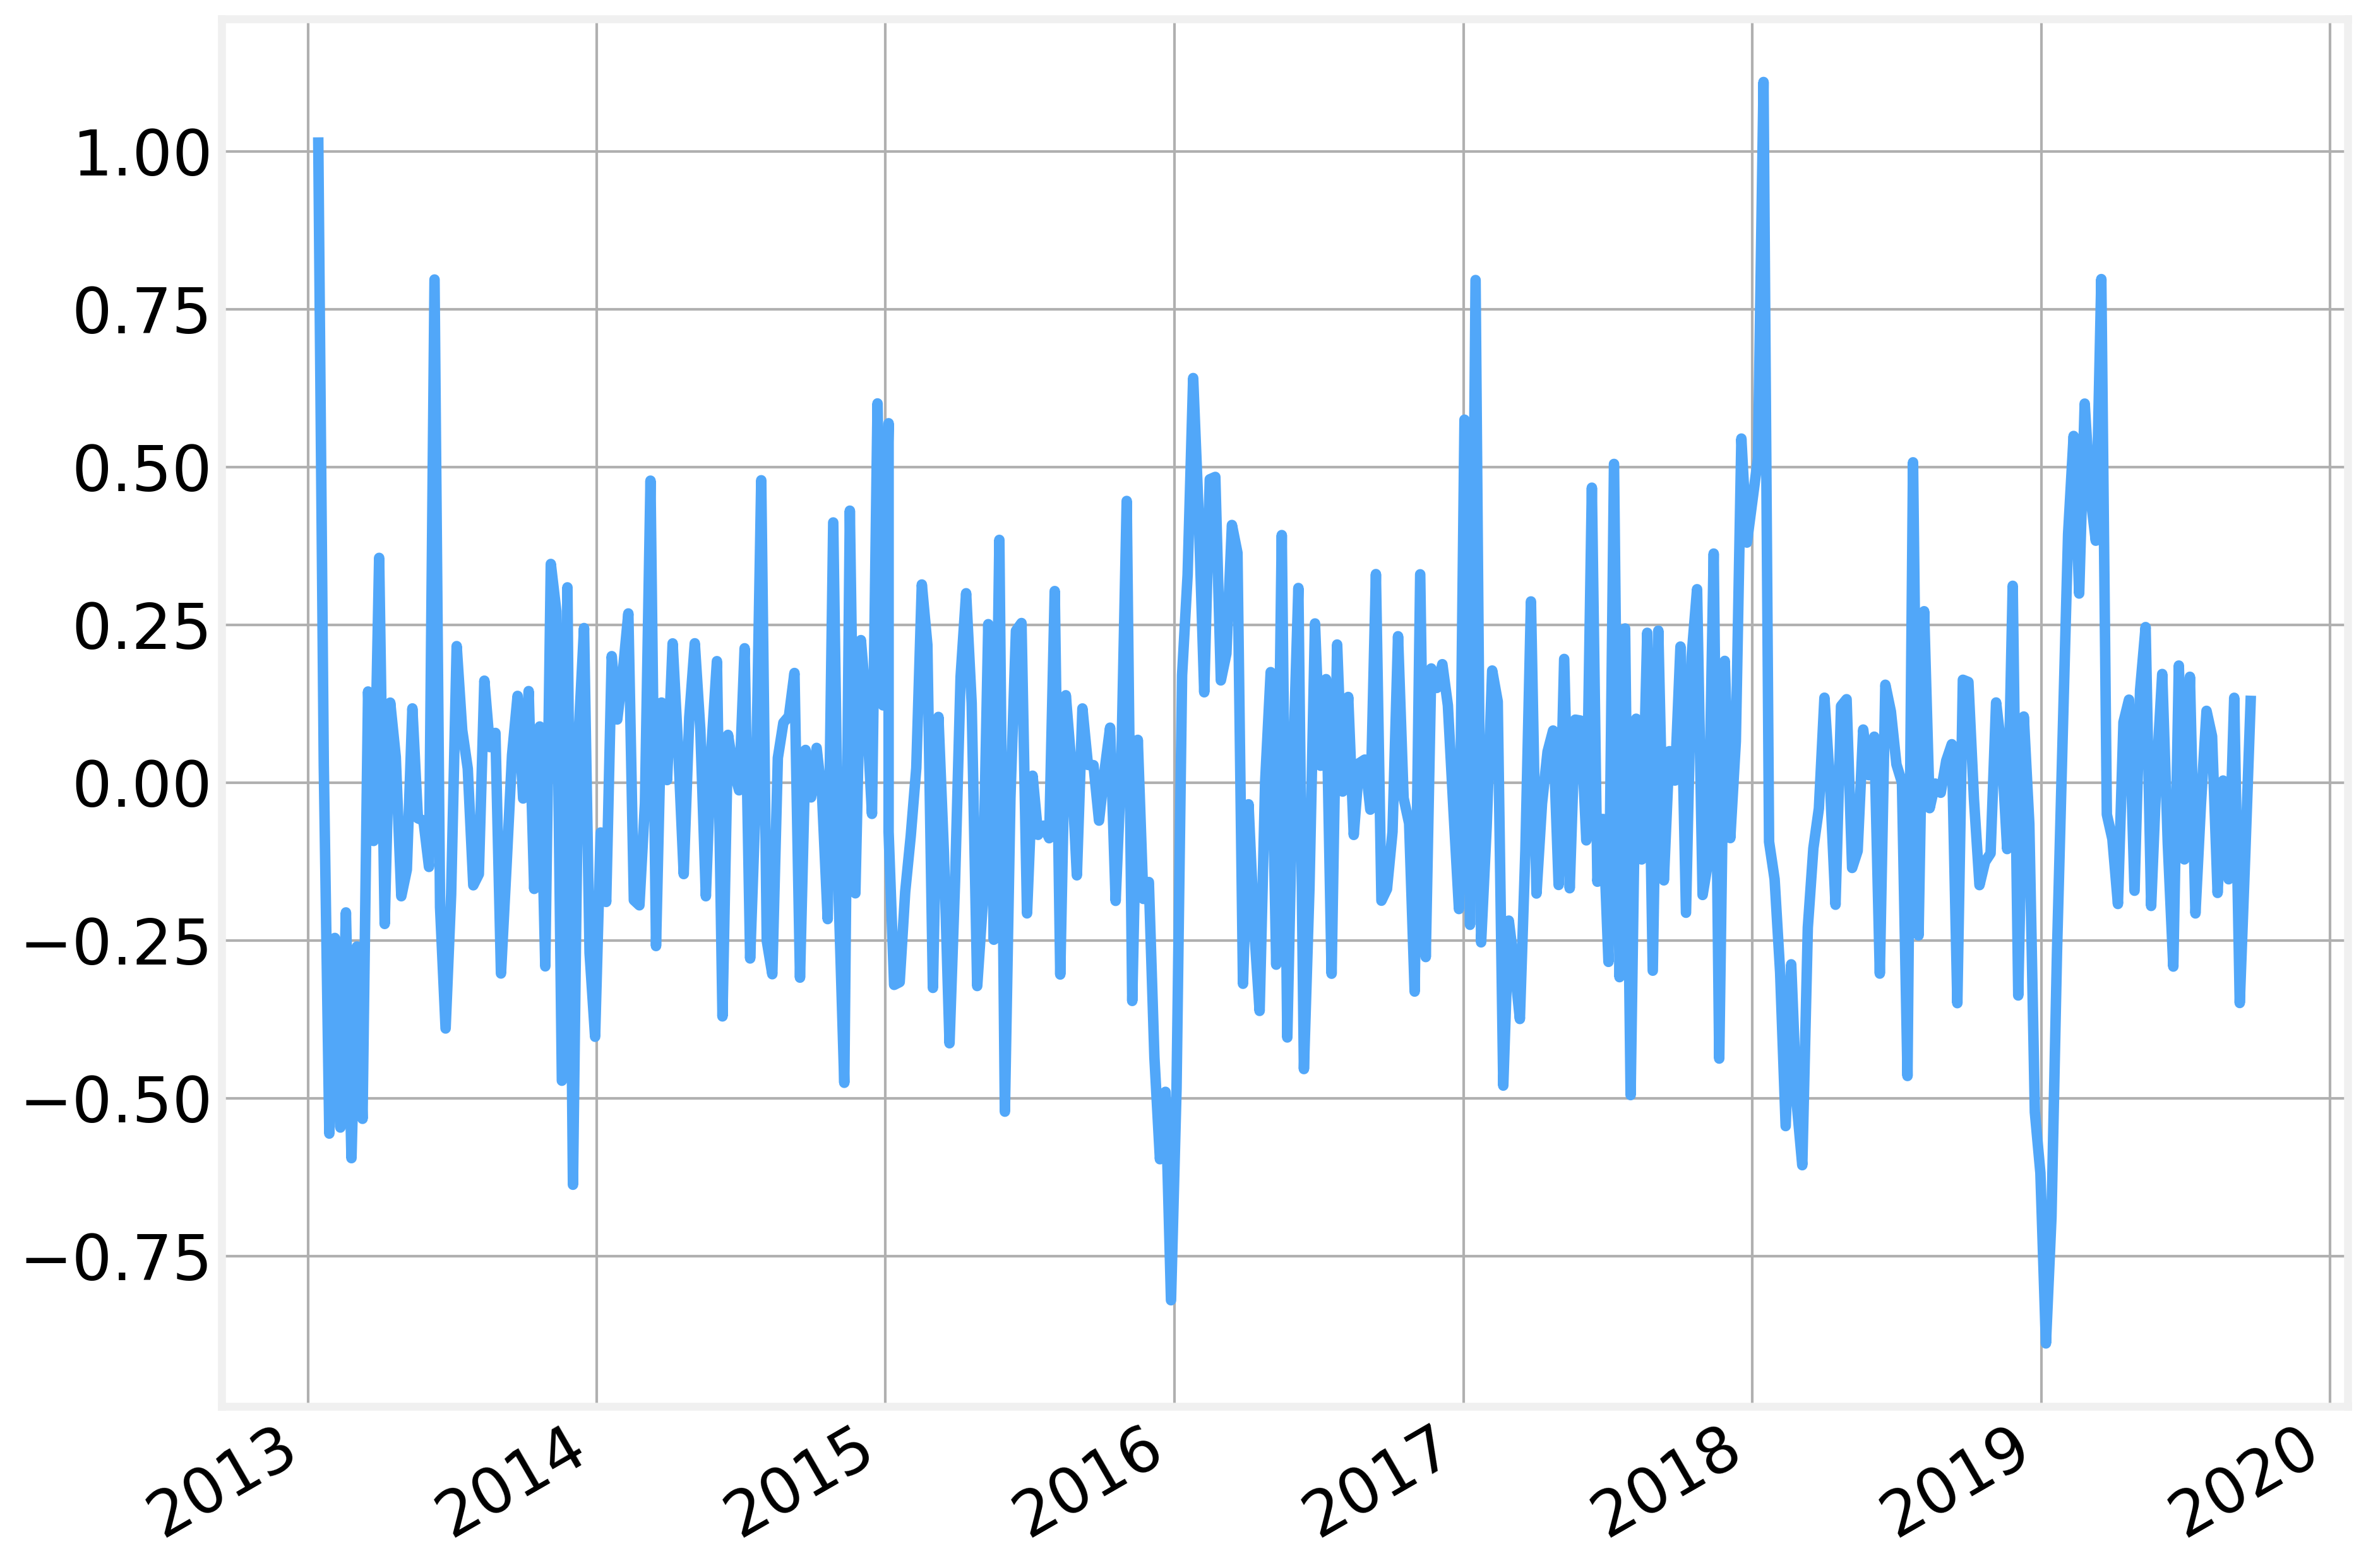

In [49]:
ax = seasonal_ILI.plot(legend=None)
ax.set_xlabel(None)

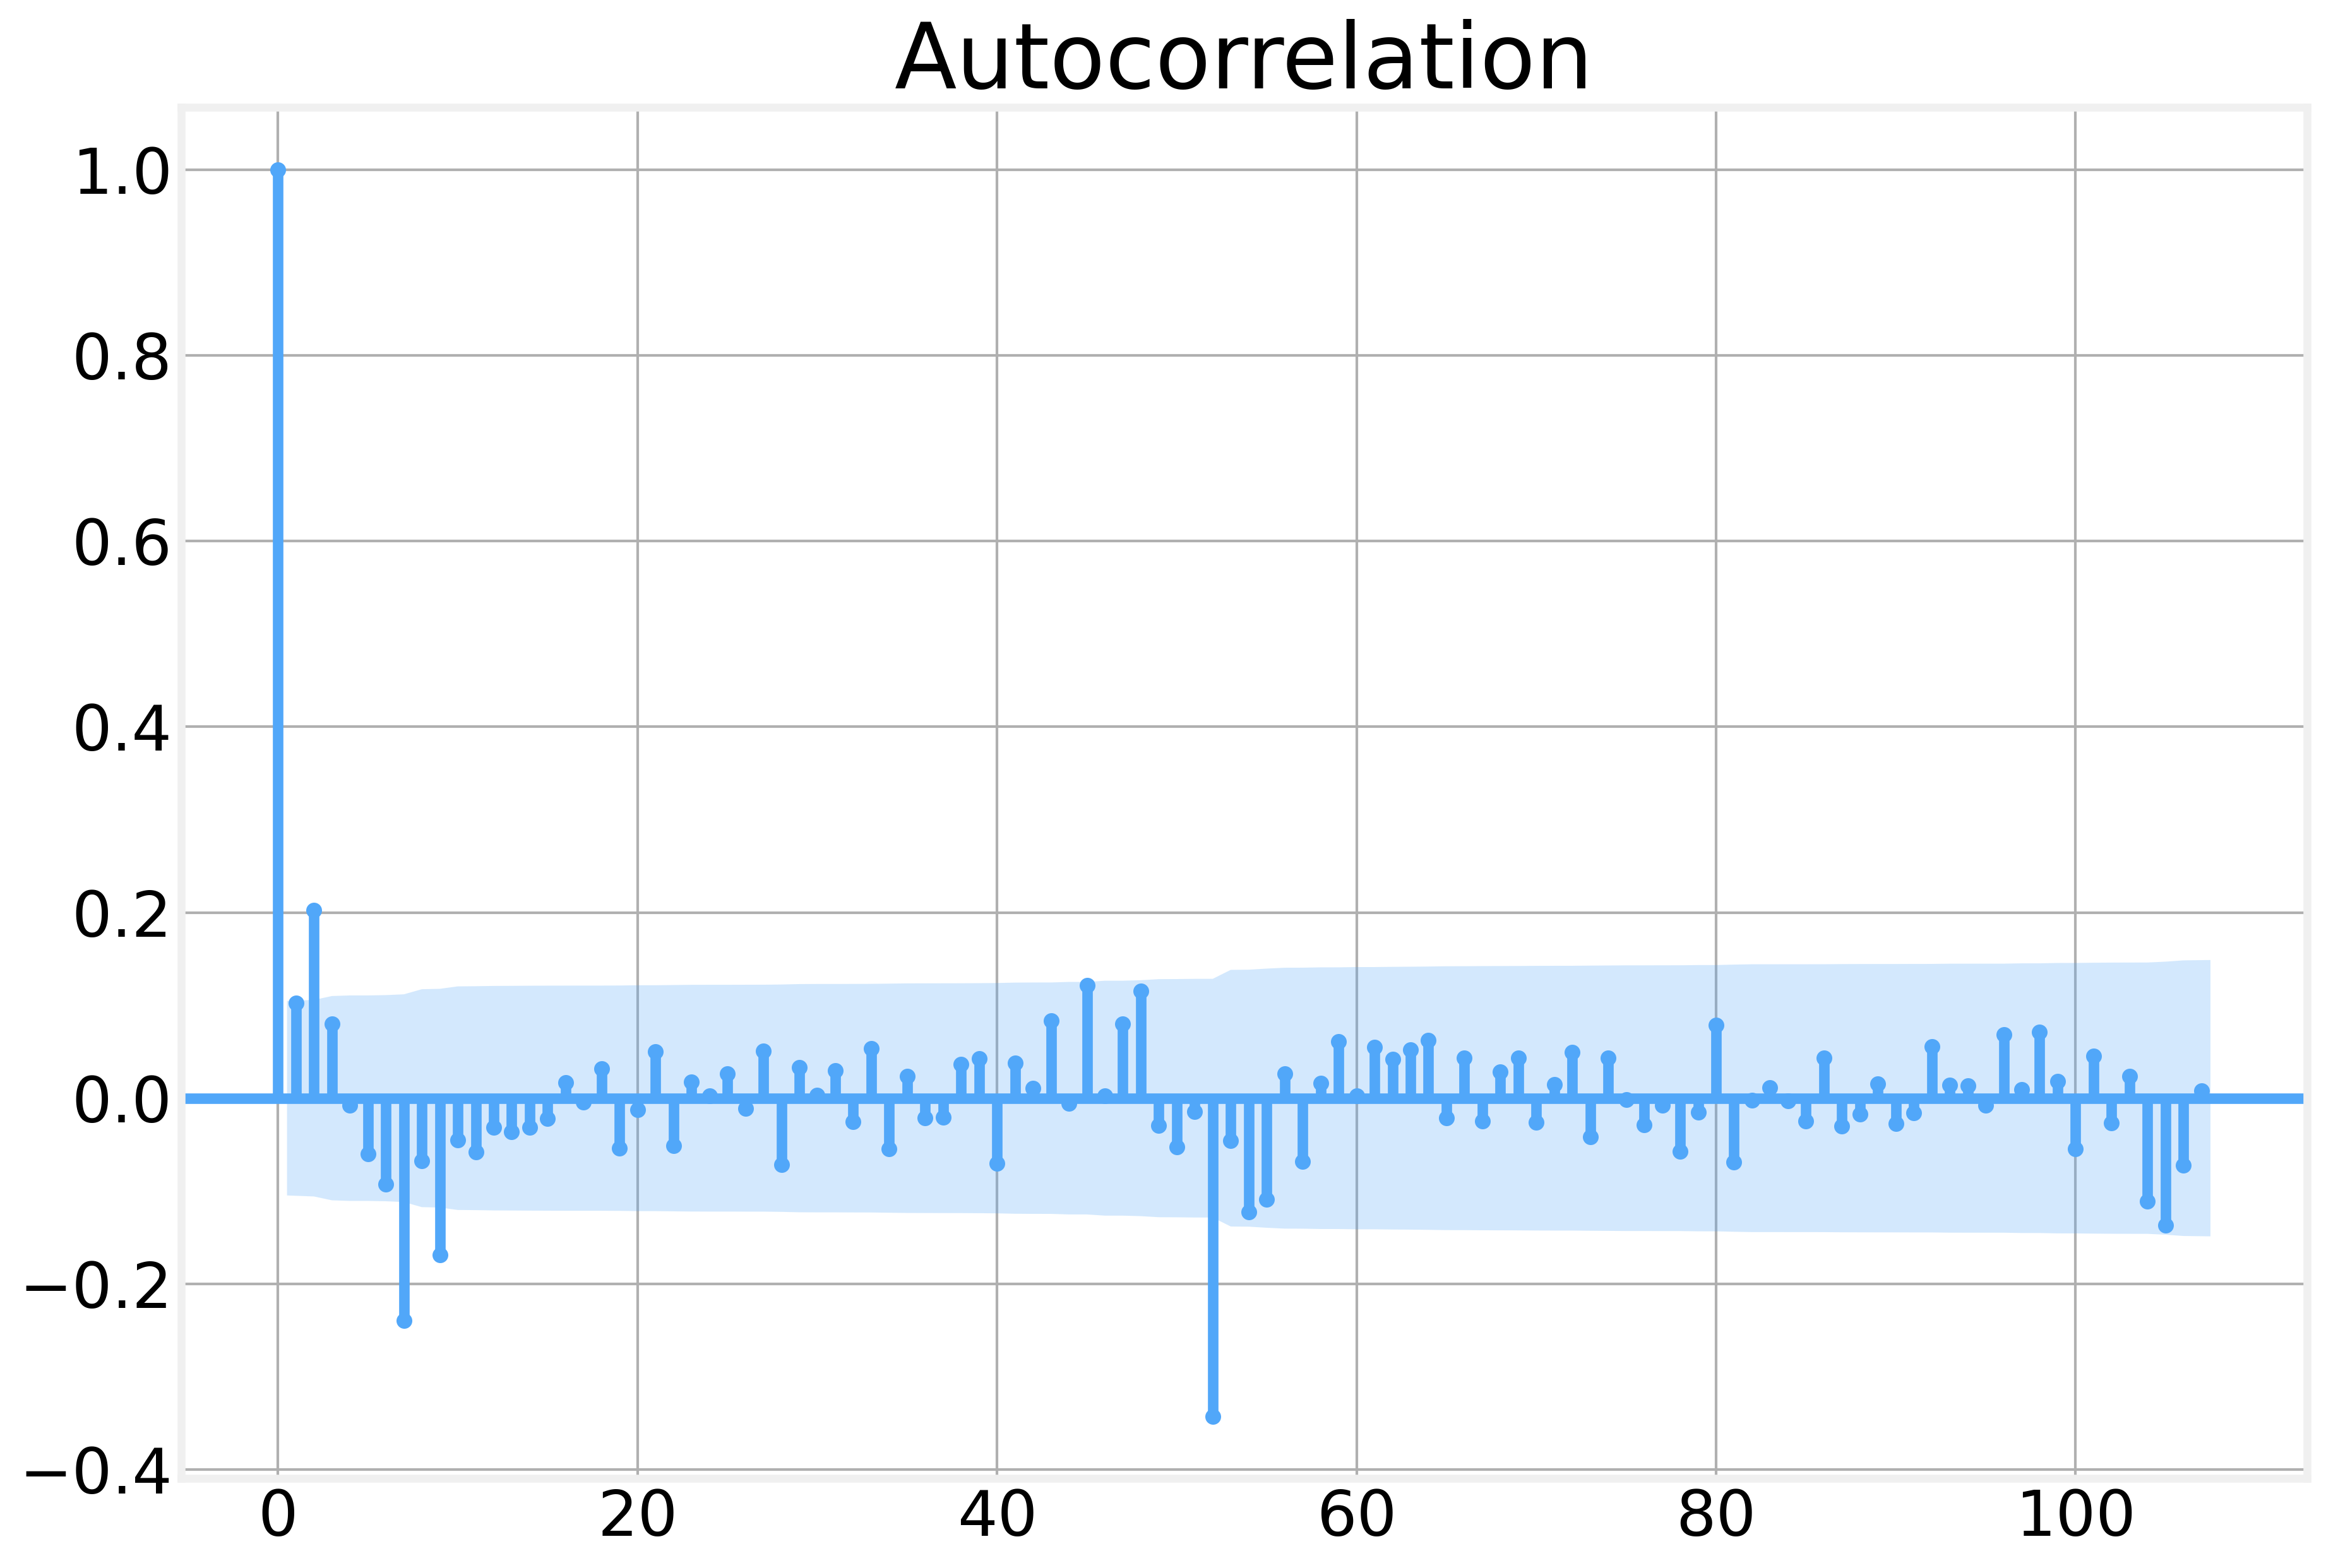

In [50]:
sm.graphics.tsa.plot_acf(seasonal_ILI, lags=107);

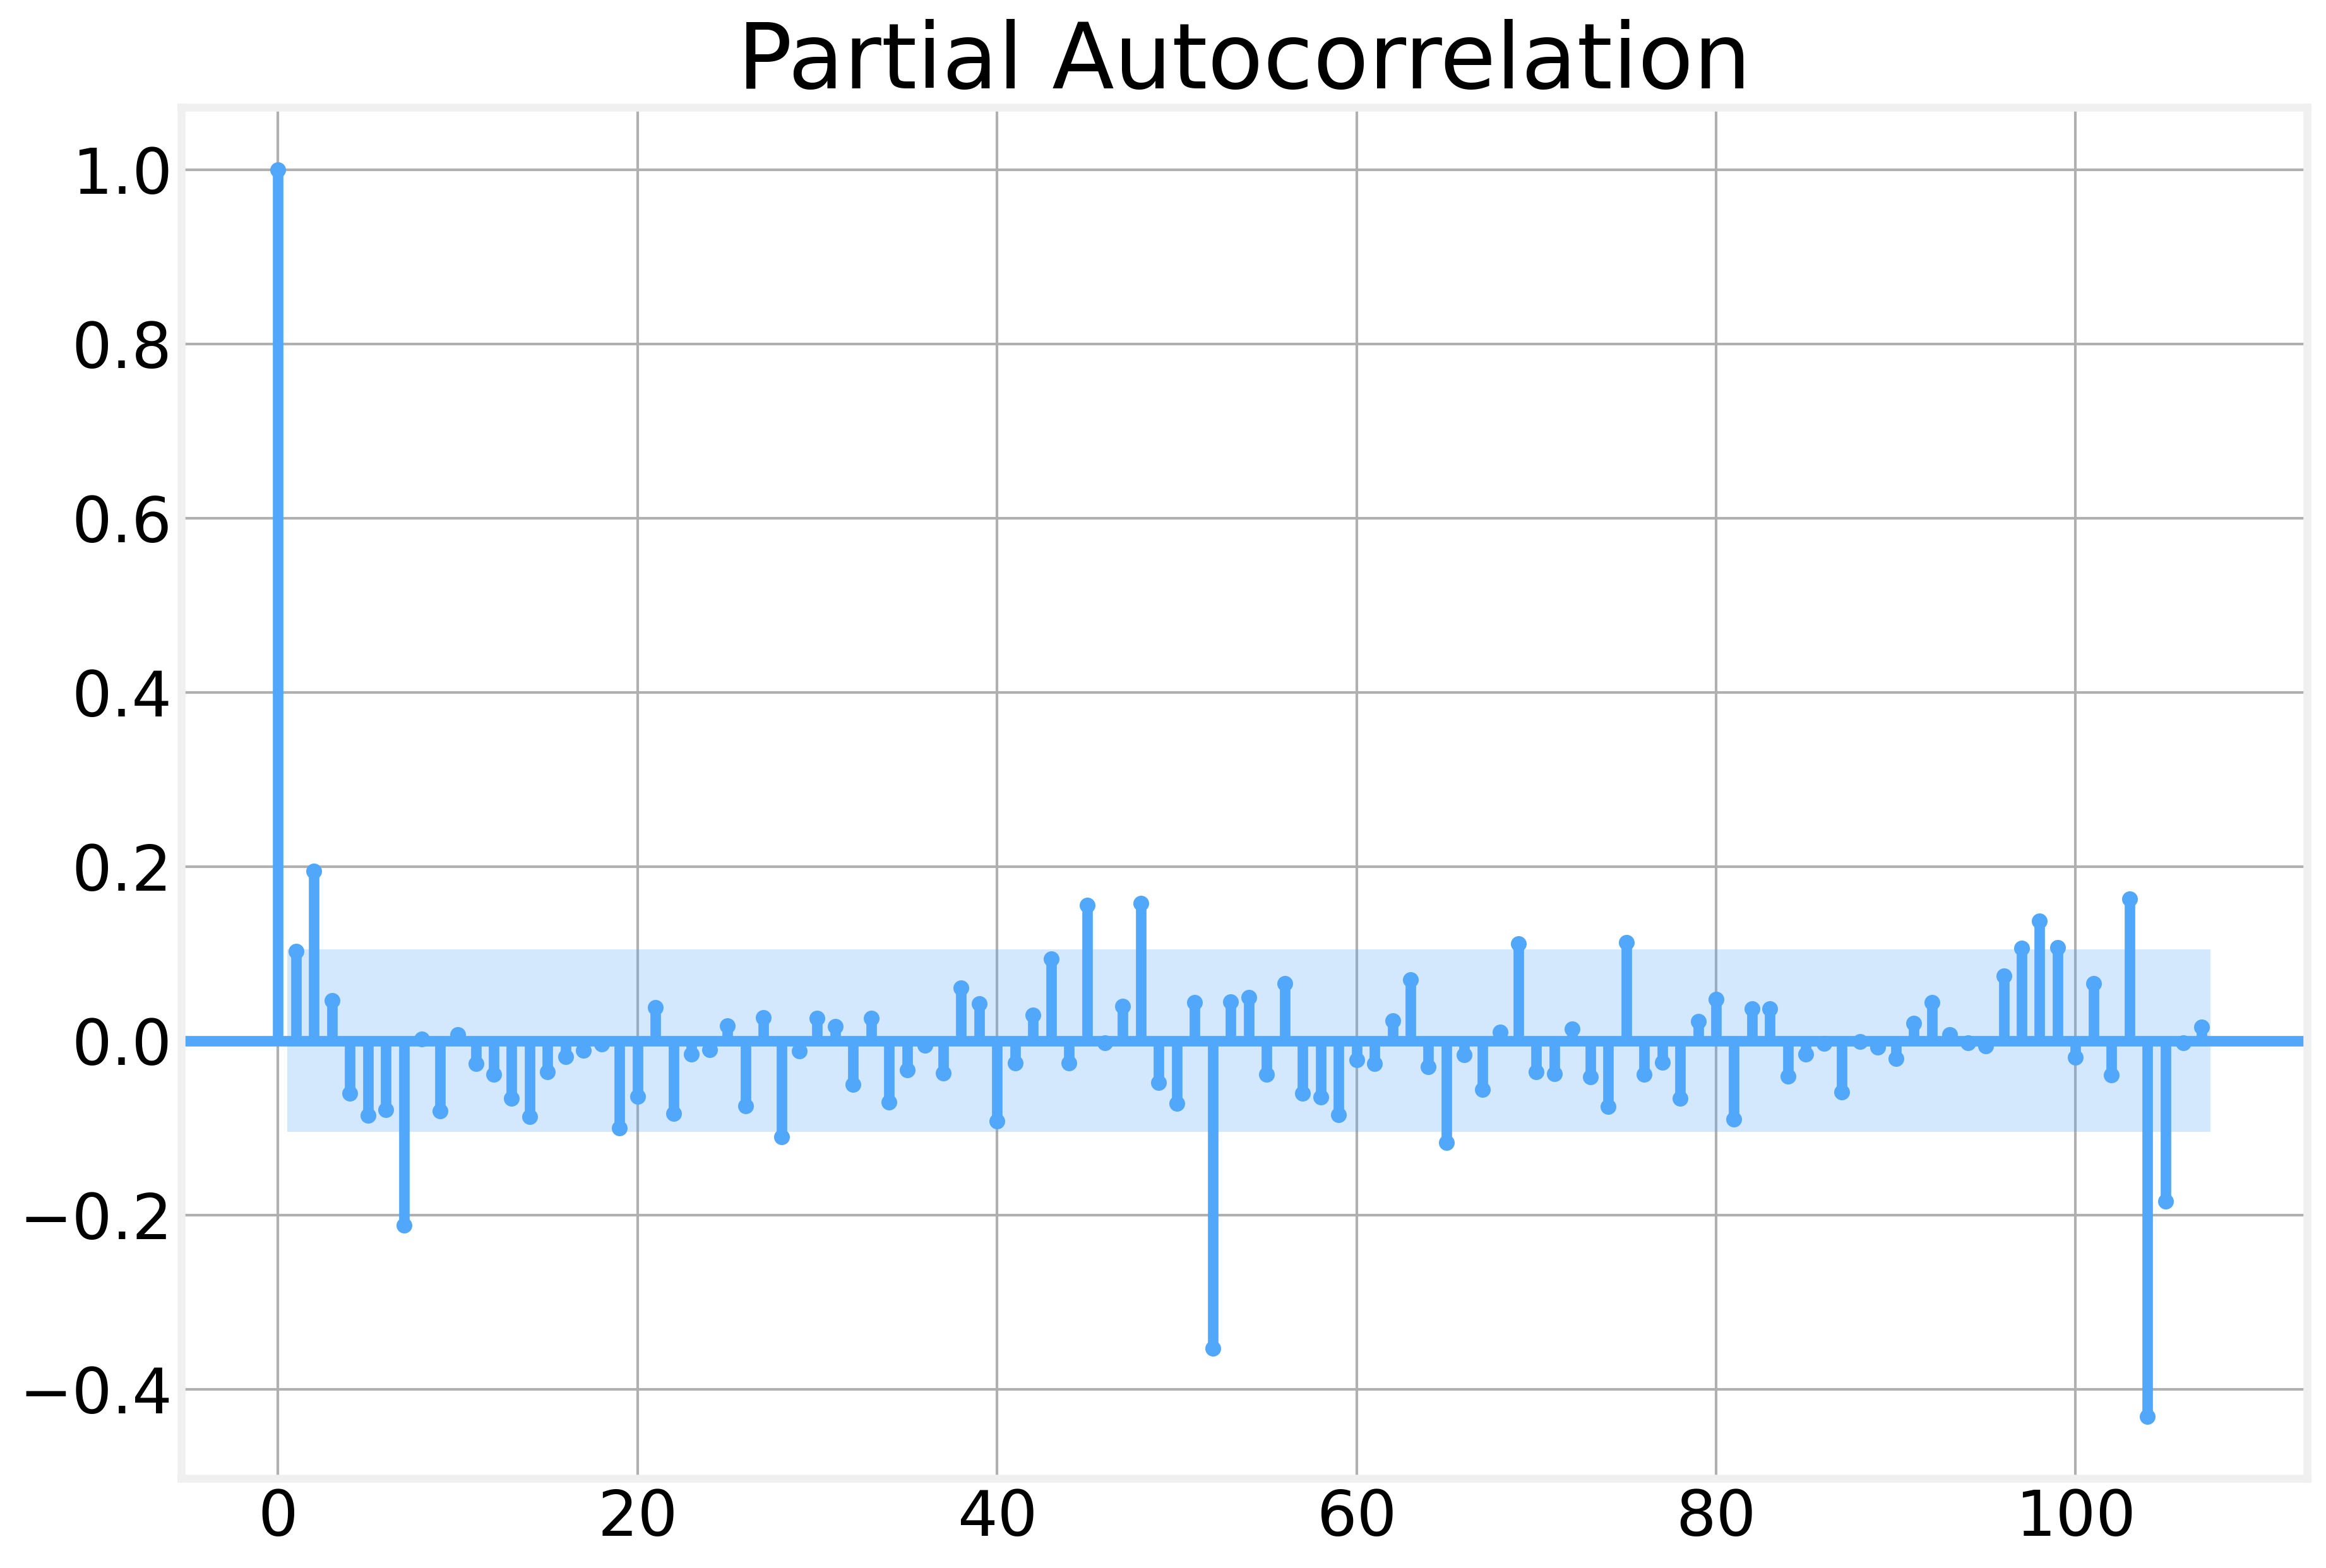

In [51]:
sm.graphics.tsa.plot_pacf(seasonal_ILI, lags=107);

In [52]:
mod = sm.tsa.statespace.SARIMAX(ILI.values,
                                order=(2, 1, 2),
                                seasonal_order=(1, 1, 1, 52),
                                simple_differencing=False)

In [53]:
res = mod.fit()

In [54]:
ILI.shape

(403, 1)

In [55]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  403
Model:             SARIMAX(2, 1, 2)x(1, 1, [1], 52)   Log Likelihood                   3.377
Date:                              Mon, 16 Aug 2021   AIC                              7.247
Time:                                      15:33:50   BIC                             34.252
Sample:                                           0   HQIC                            17.996
                                              - 403                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.4387      0.141     10.189      0.000       1.162       1.715
ar.L2         -0.7703      0.119     -6.452      0.000      -1.004      -0.536
ma.L1         -1.3420      0.140     -9.617      0.000      -1.615      -1.068
ma.L2          0.7651      0.109      7.049      0.000       0.552       0.978
ar.S.L52       0.1716      0.094      1.827      0.068      -0.012       0.356
ma.S.L52      -0.9930      3.394     -0.293      0.770      -7.646       5.660
sigma2         0.0446      0.148      0.301      0.763      -0.246       0.335
===================================================================================
Ljung-Box (L1) (Q):                   0.98   Jarque-Bera (JB):                38.30
Prob(Q):                              0.32   Prob(JB):                         0.00
Heteroskedasticity (H):               1.10   Skew:                             0.47
Prob(H) (two-sided):                  0.61   Kurtosis:                         4.32
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

And we can visualize our extrapolation

In [51]:
new_weeks = ILI.index[-1]+pd.timedelta_range('7 day', periods=52, freq='7d')

Text(0.5, 0, '')

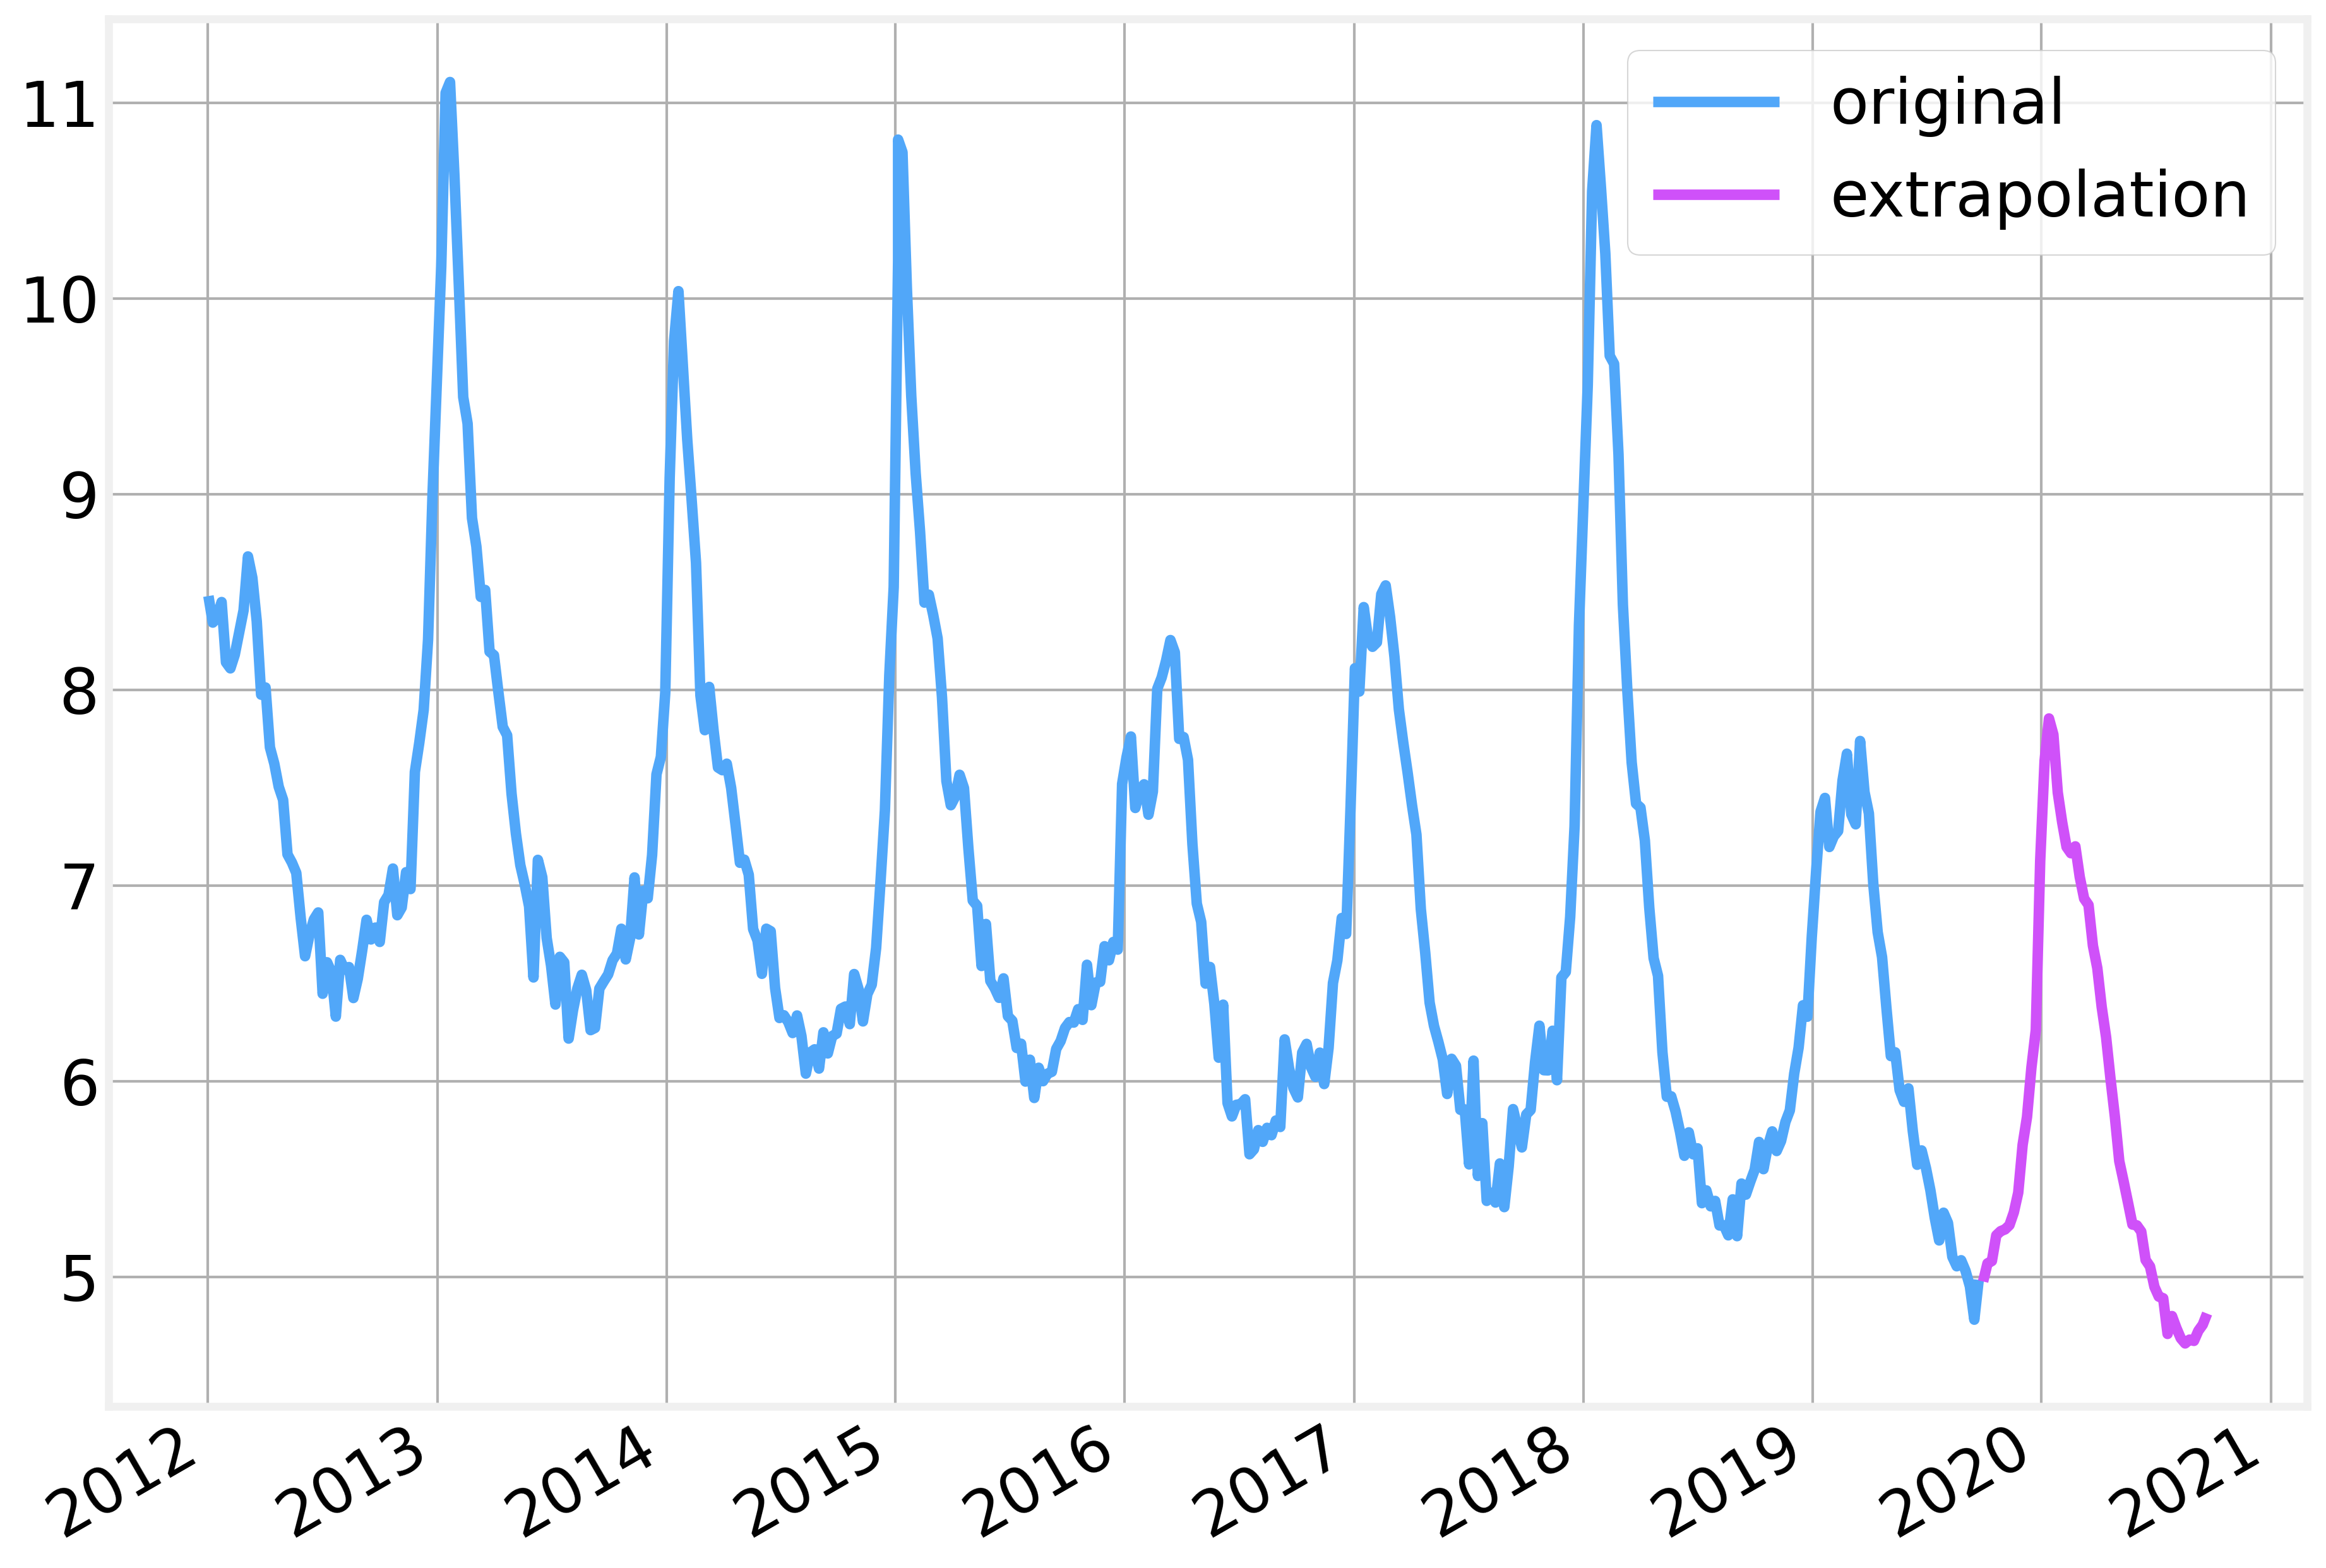

In [52]:
ax = ILI.plot()
forecast = res.forecast(52)
ax.plot(new_weeks, forecast)
ax.legend(['original', 'extrapolation'])
ax.set_xlabel(None)

<div style="width: 100%; overflow: hidden;">
     <img src="data/D4Sci_logo_full.png" alt="Data For Science, Inc" align="center" border="0" width=300px> 
</div>